In [172]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import scipy
import math
from scipy.stats import genextreme as gev, gumbel_r, norm, gompertz, genpareto
from scipy.special import gamma, factorial
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef

from constants import * 
from utils import *

陽明


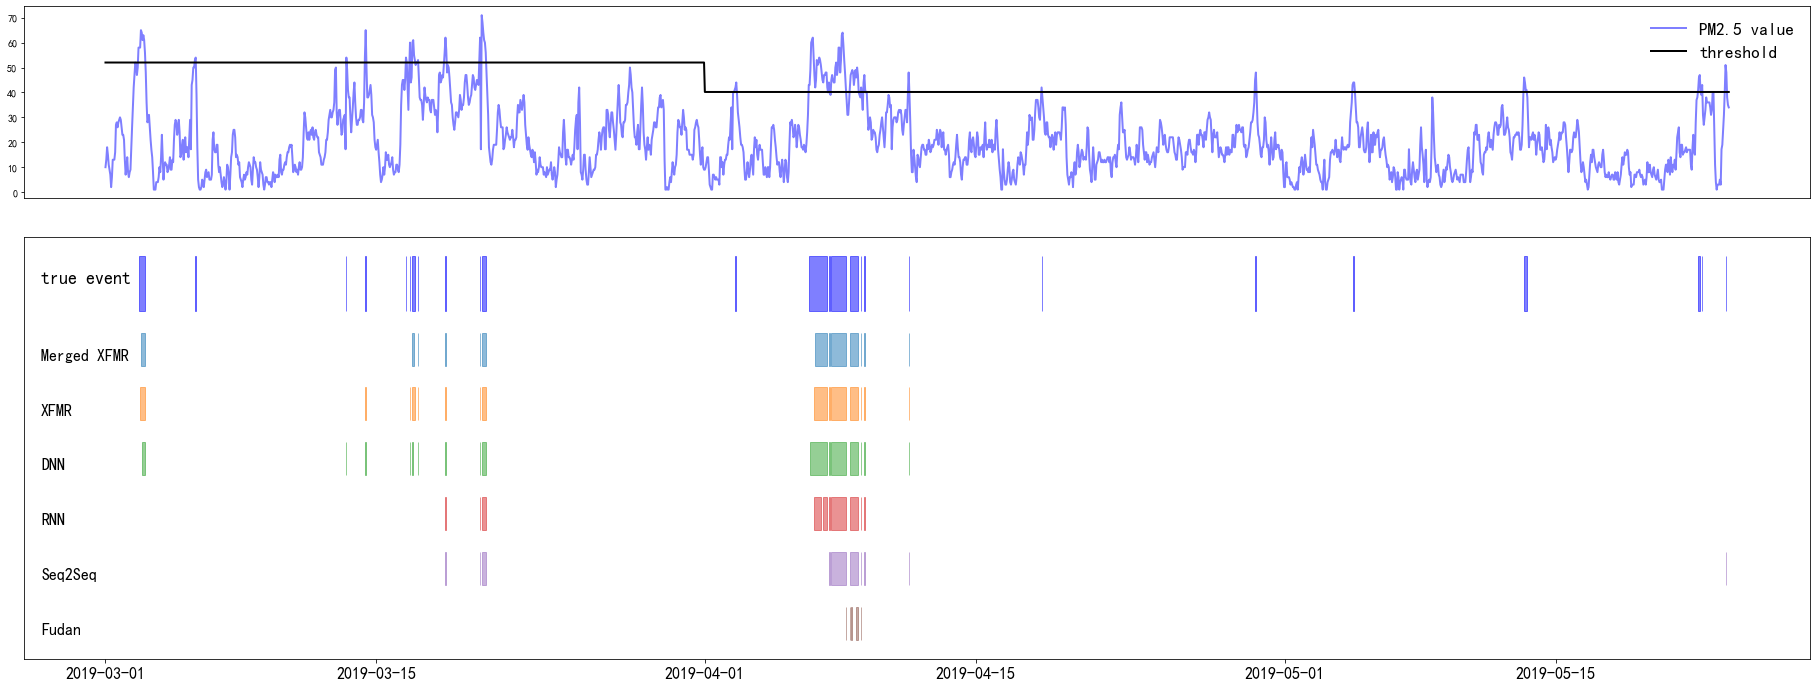

萬里


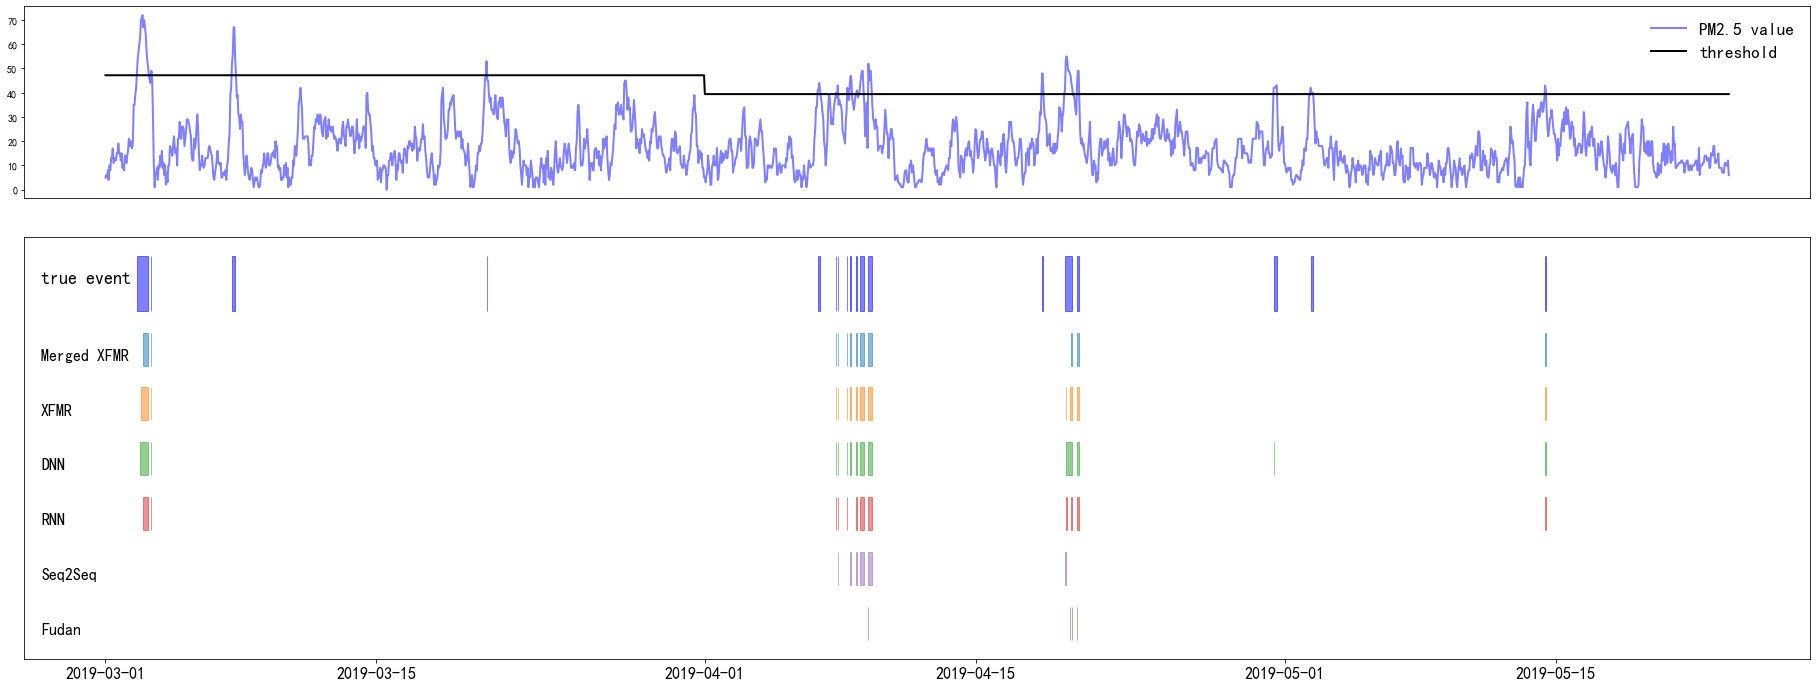

淡水


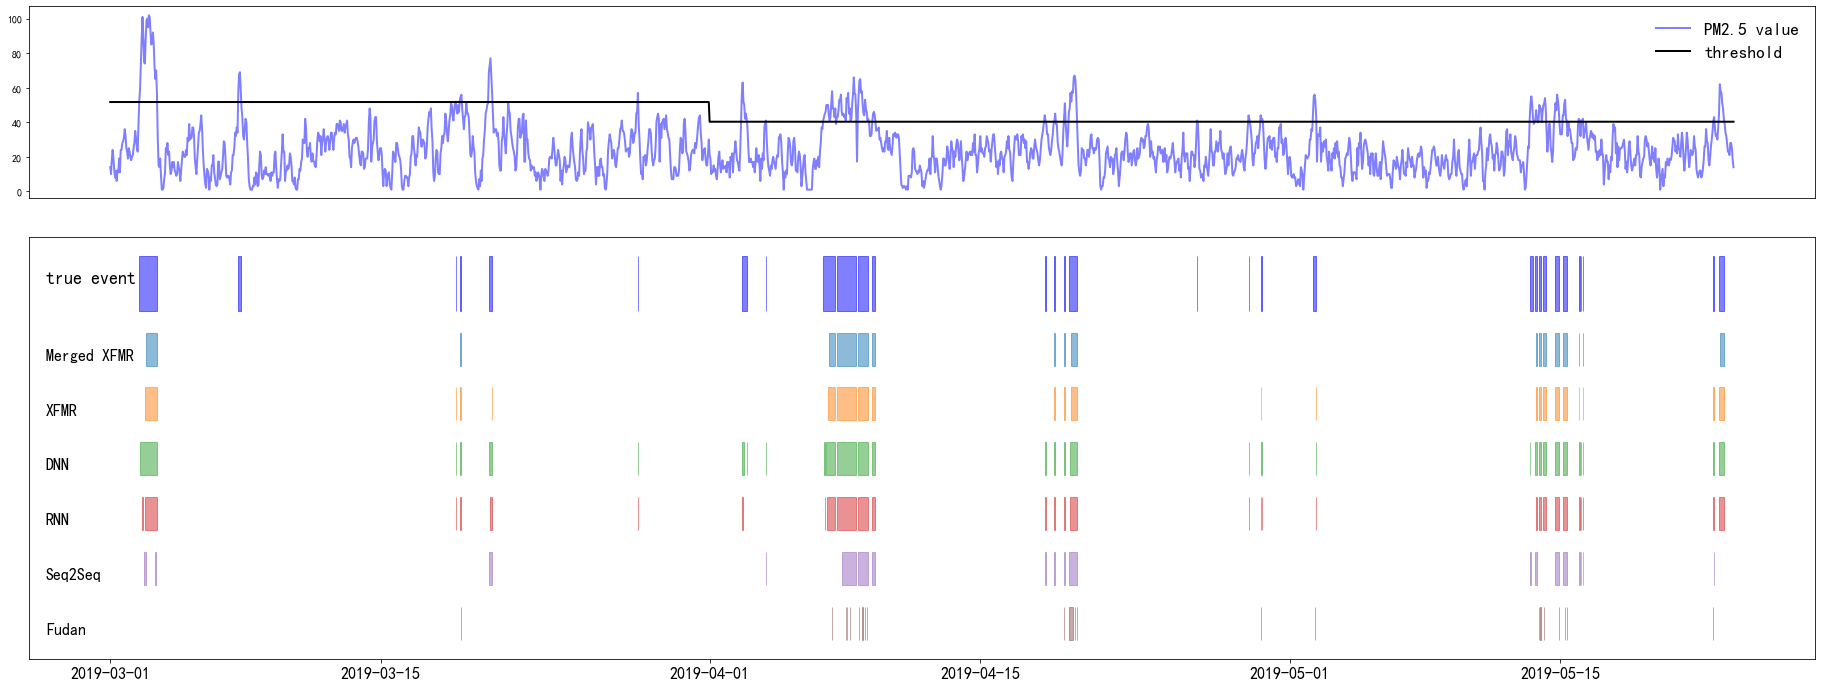

基隆


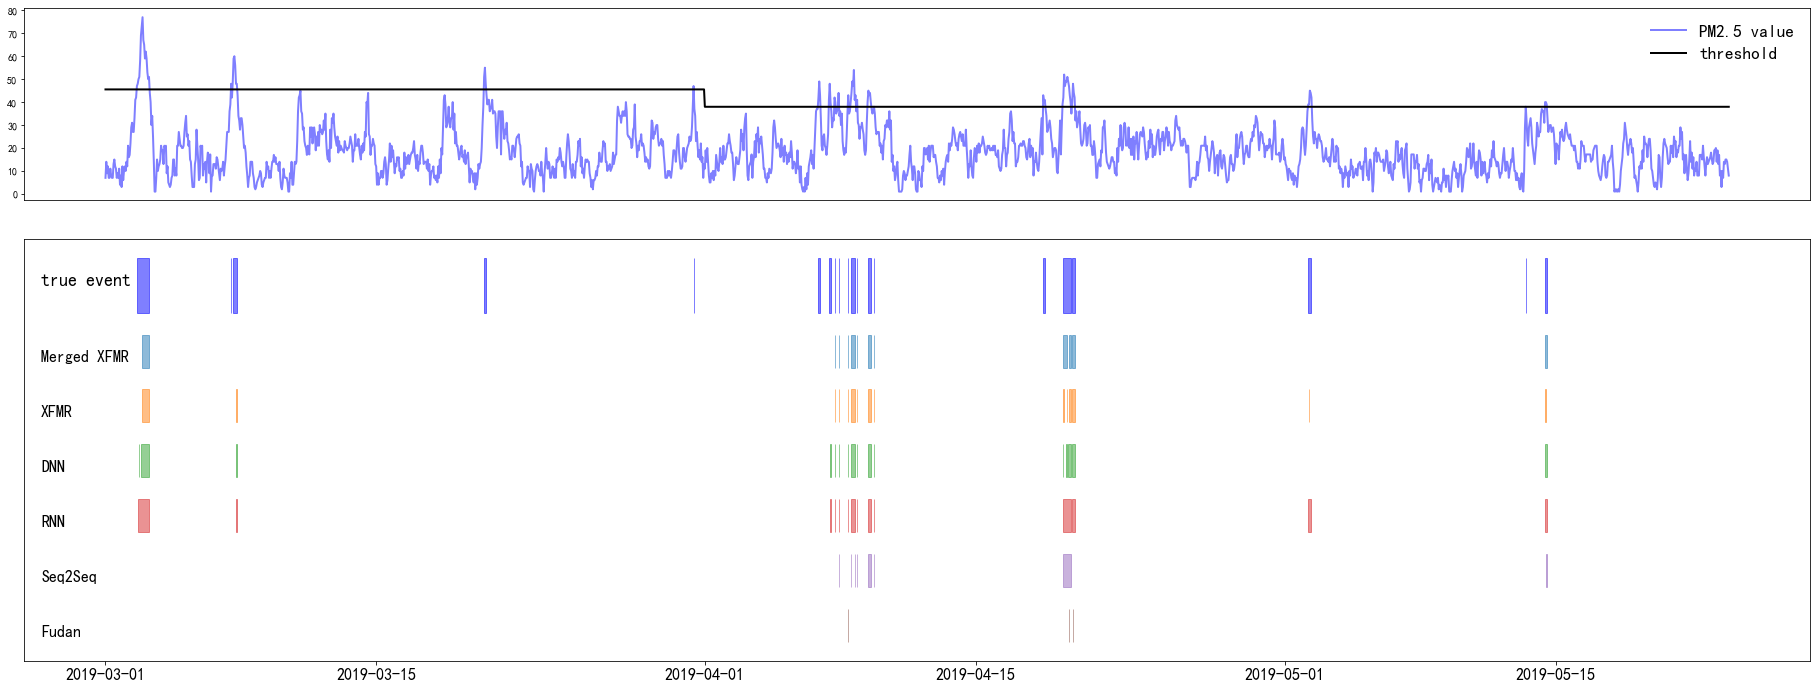

士林


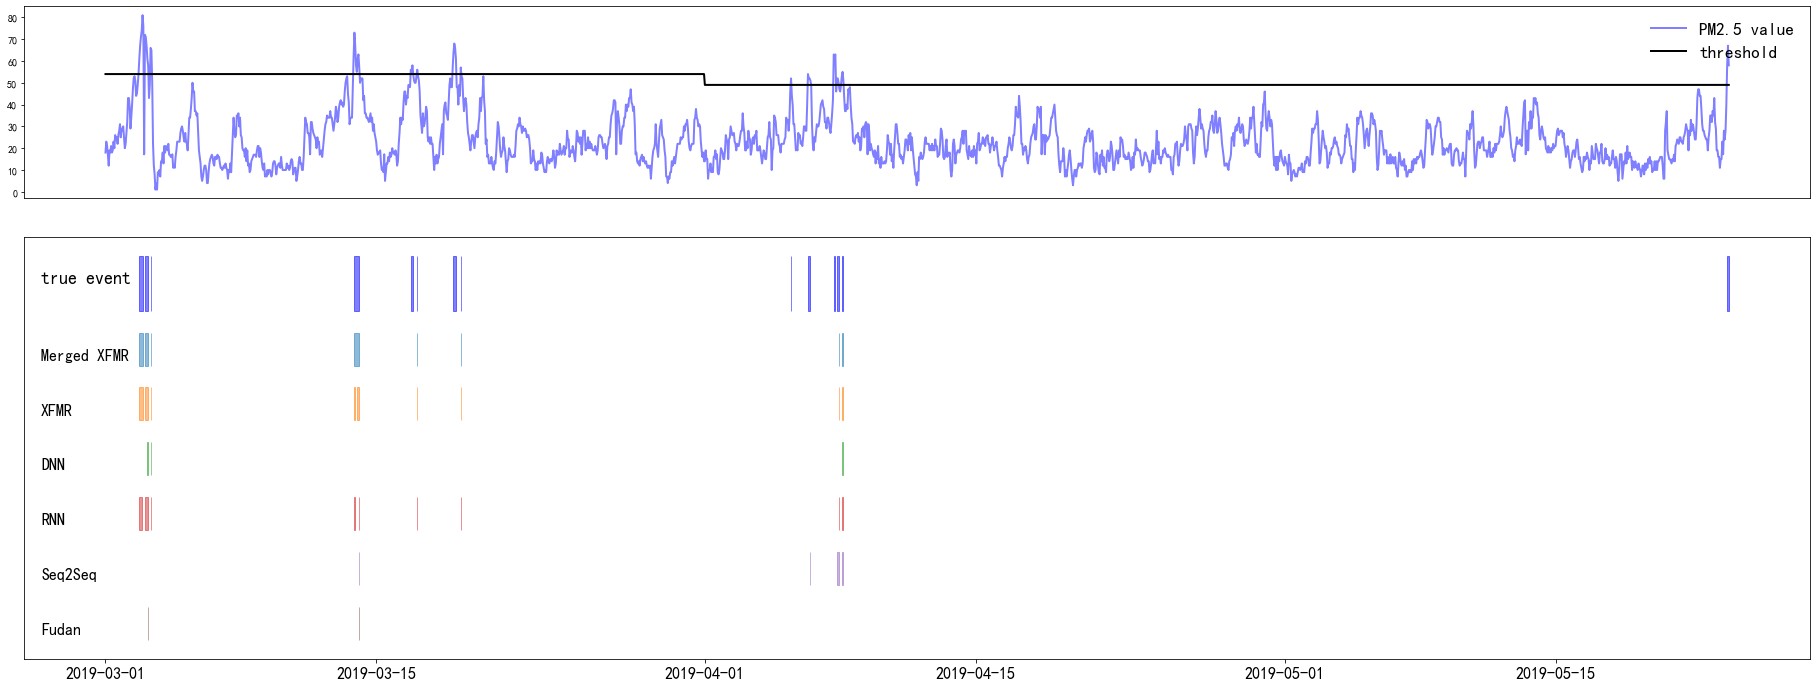

林口


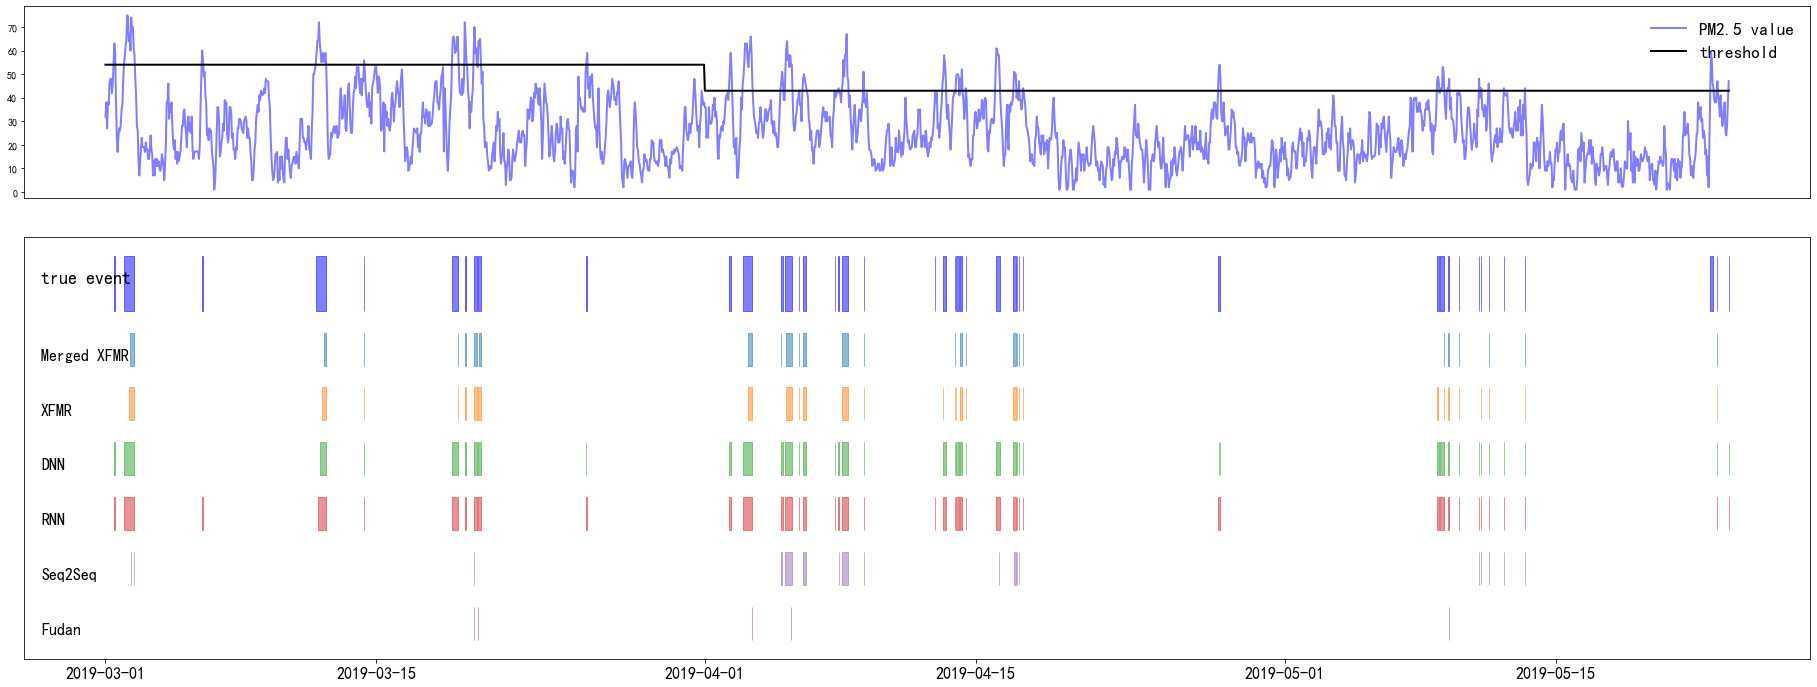

三重


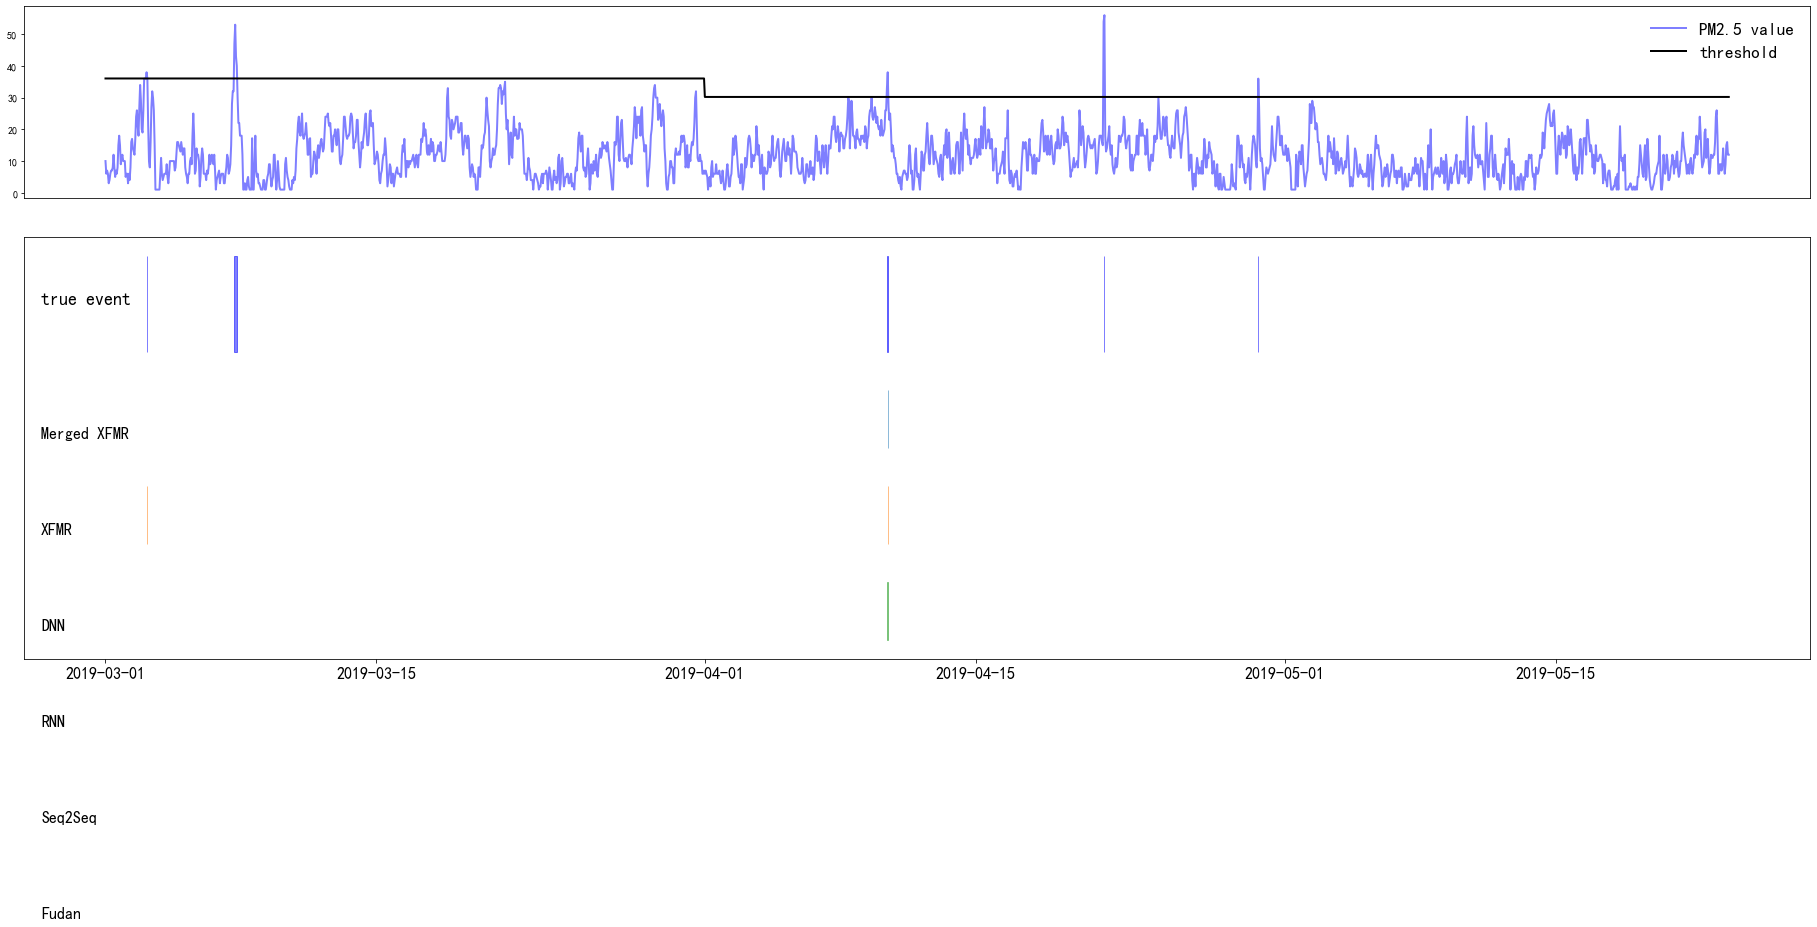

中山


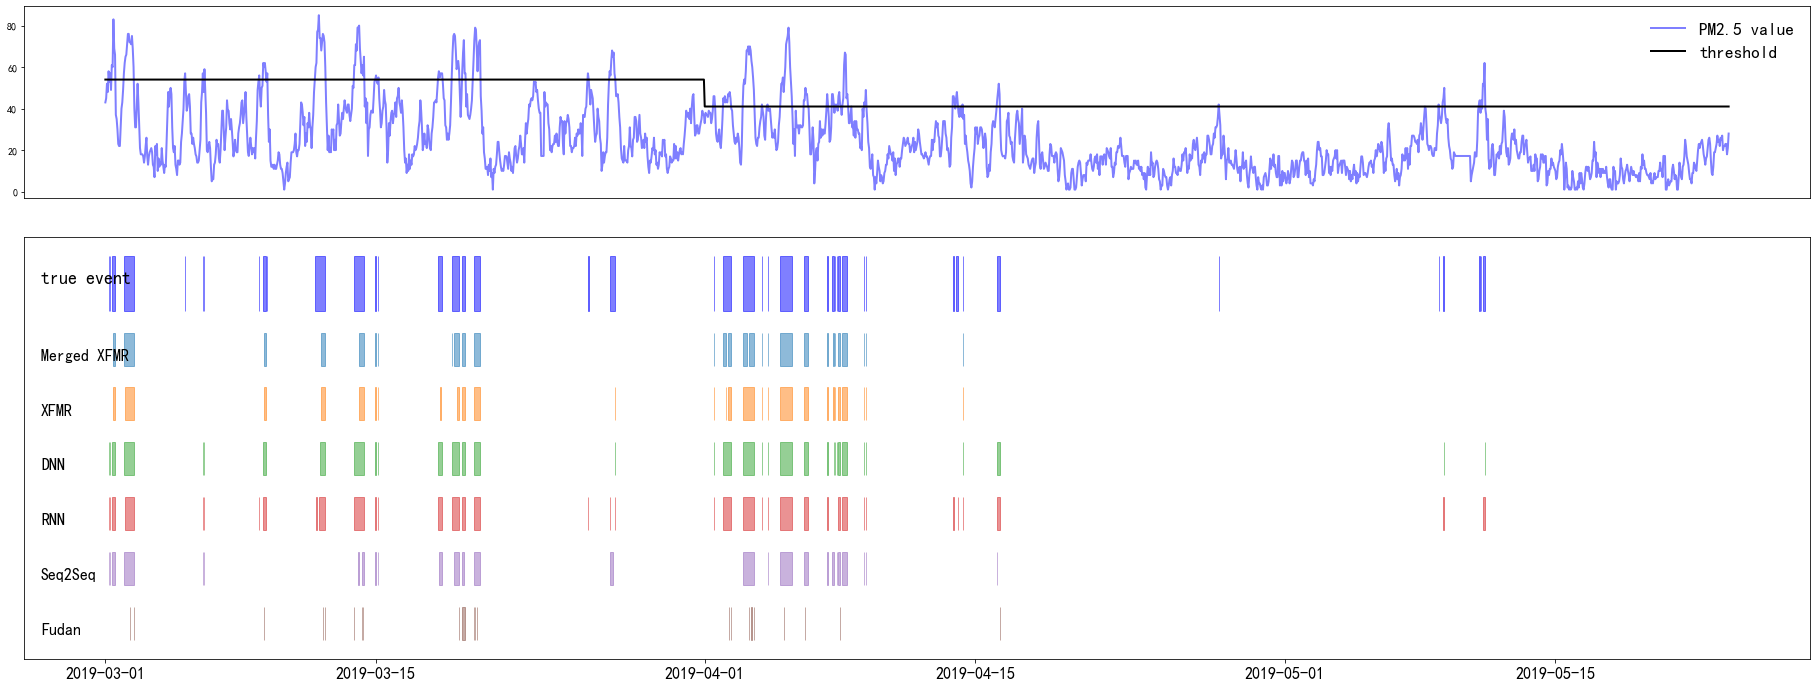

菜寮


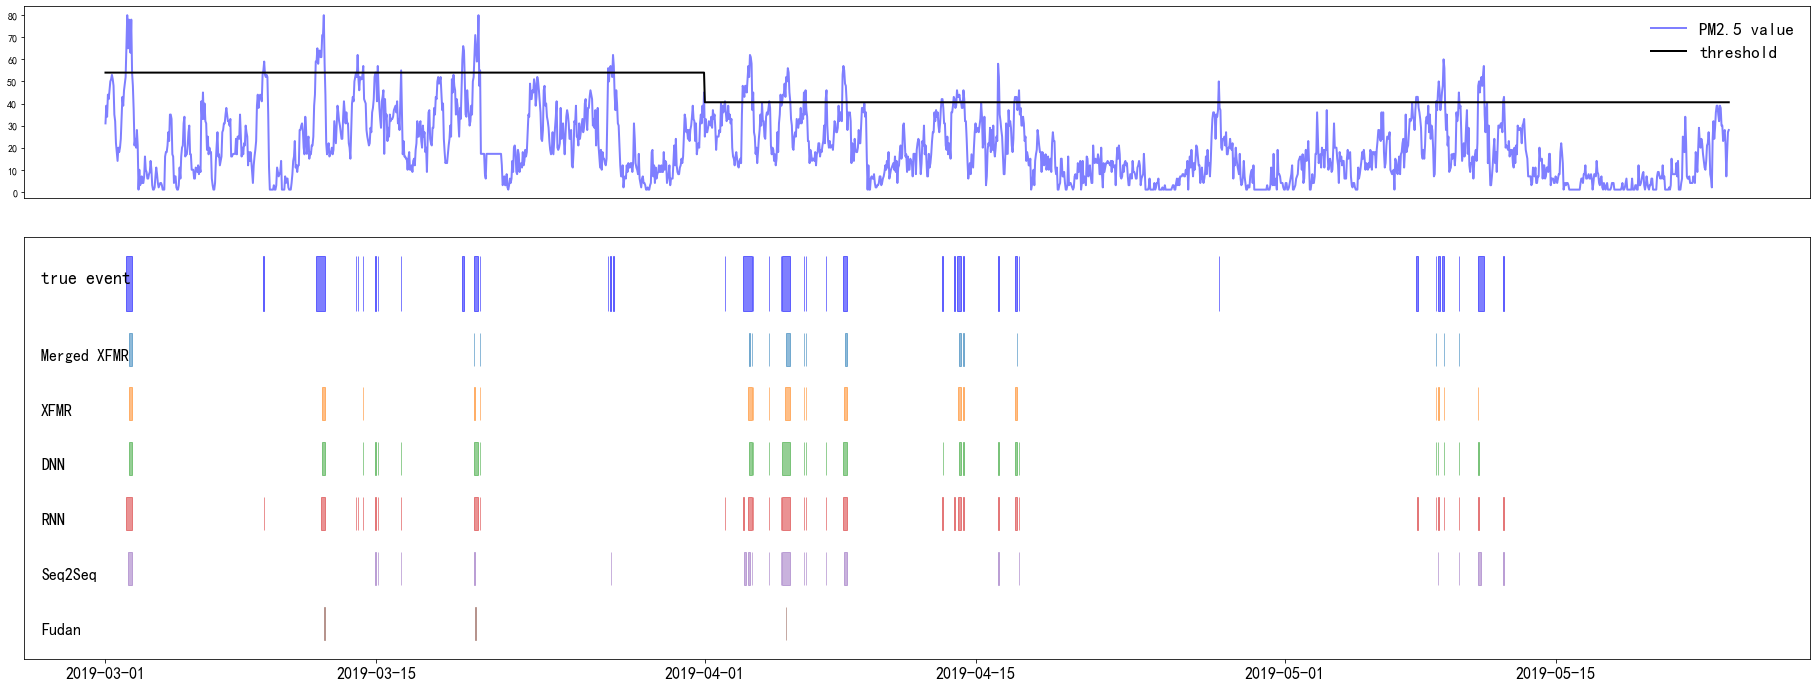

大園


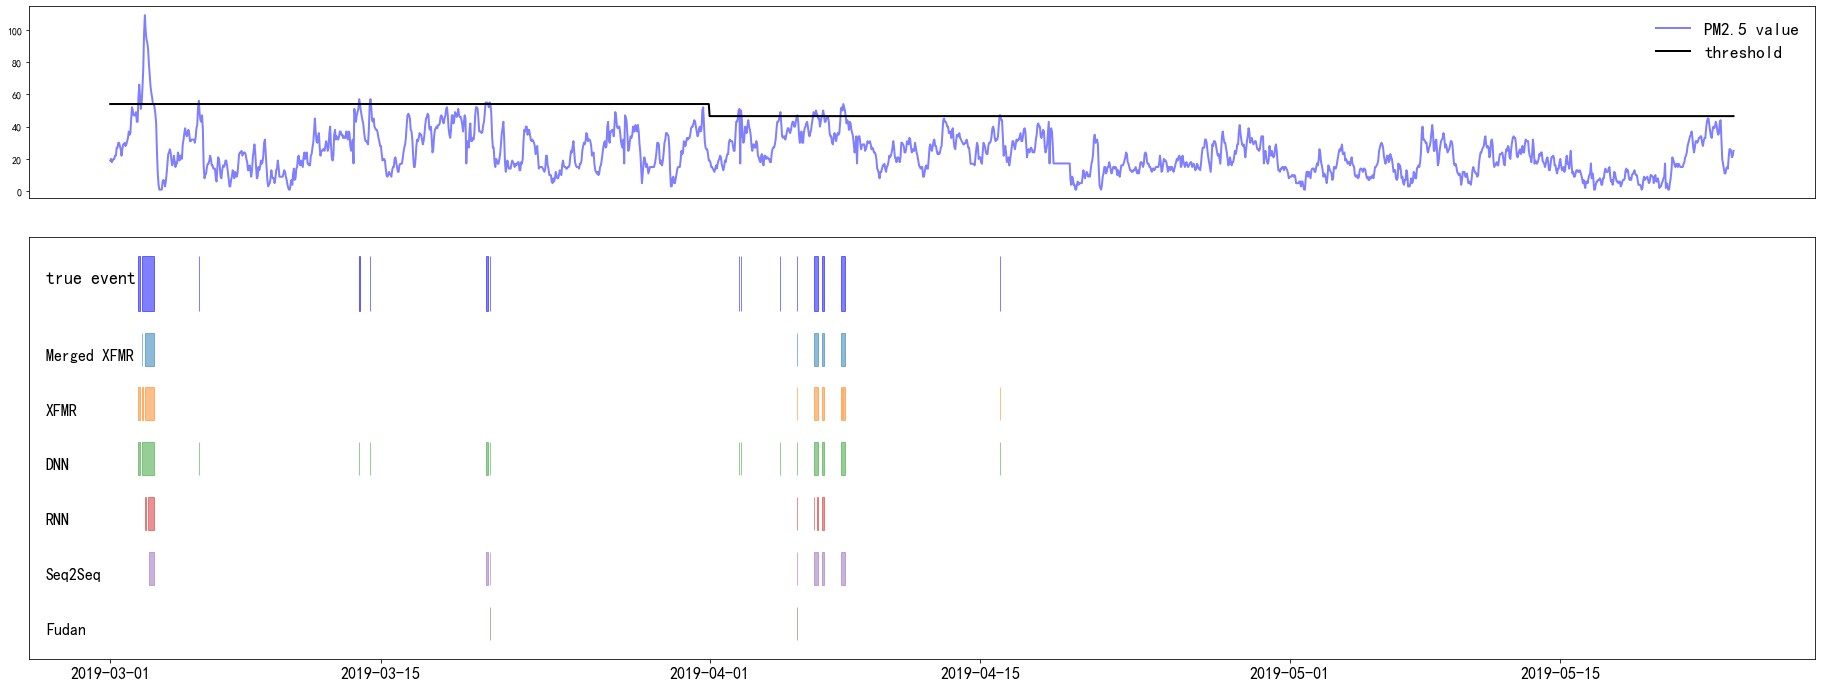

汐止


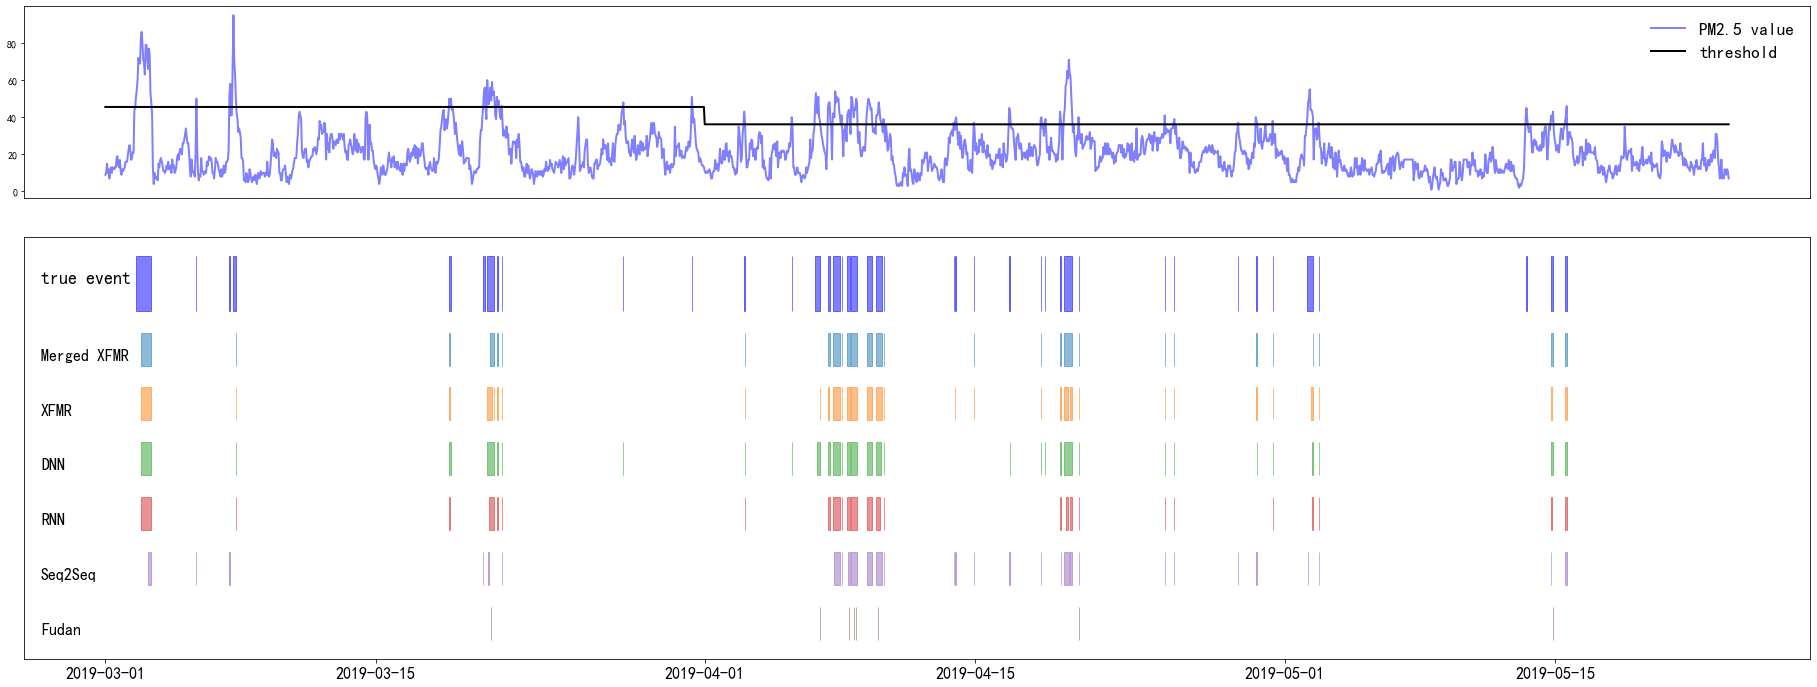

大同


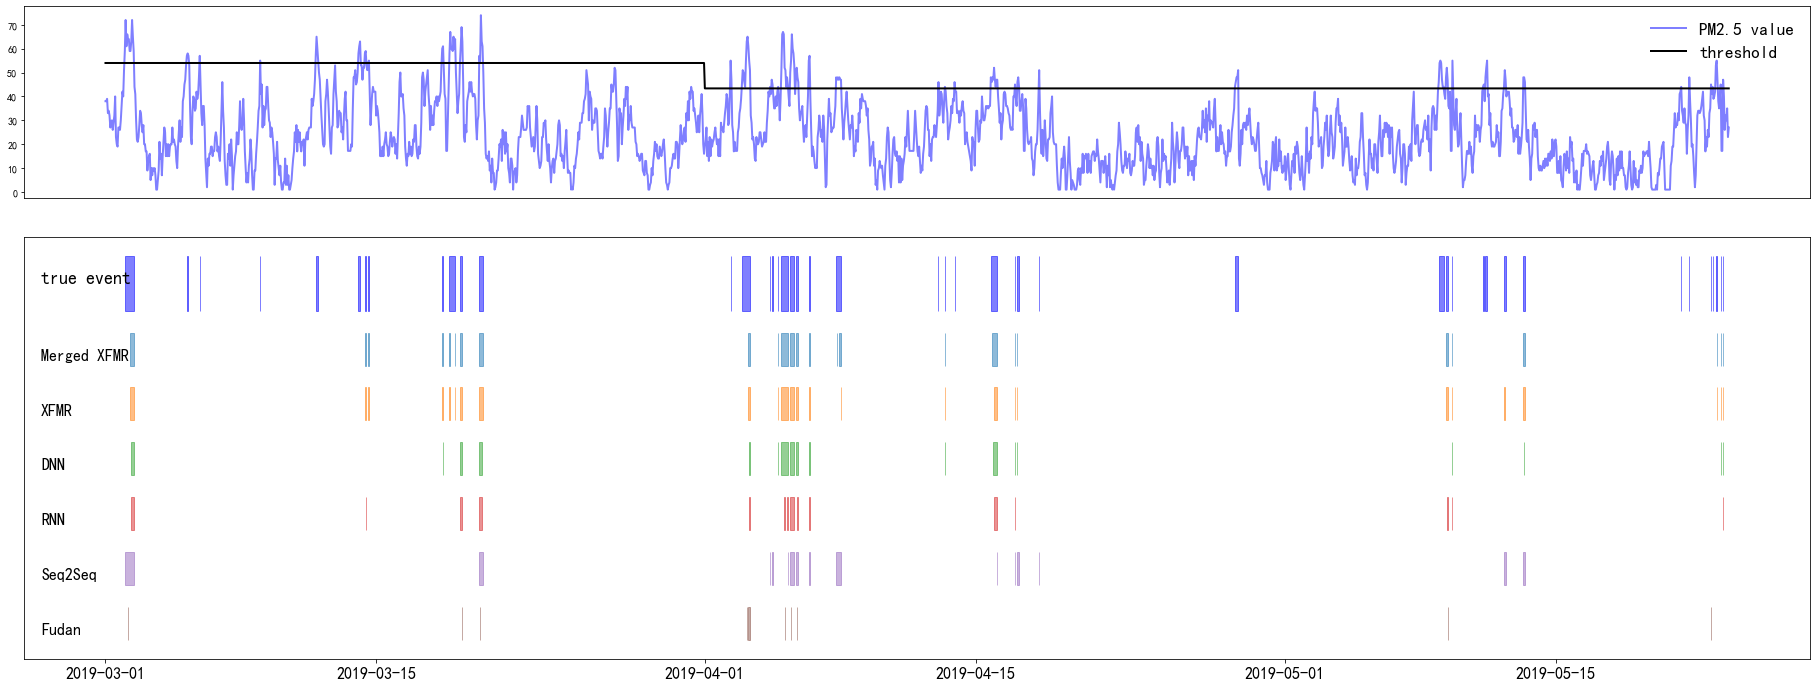

松山


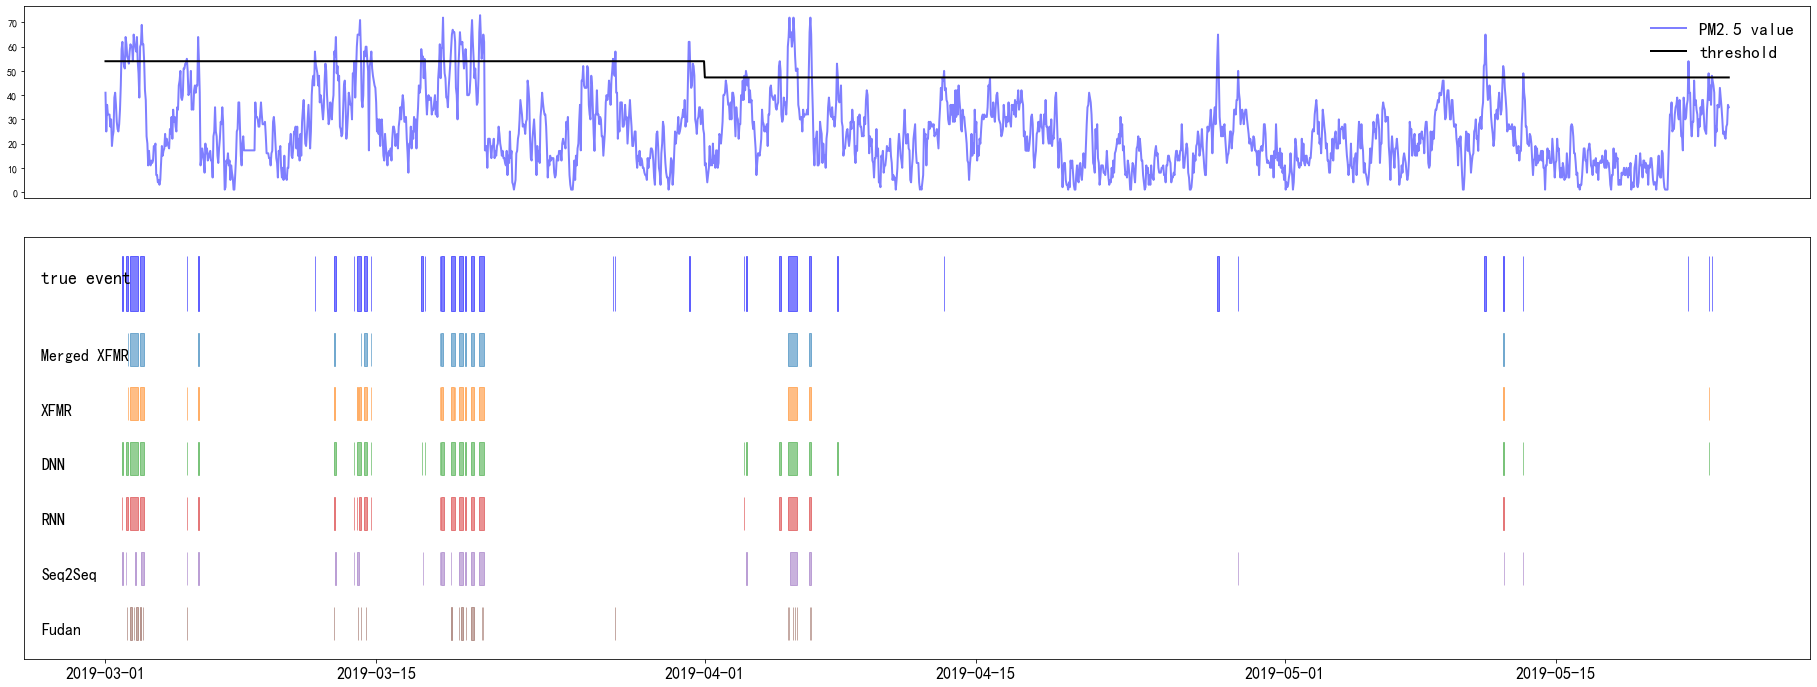

萬華


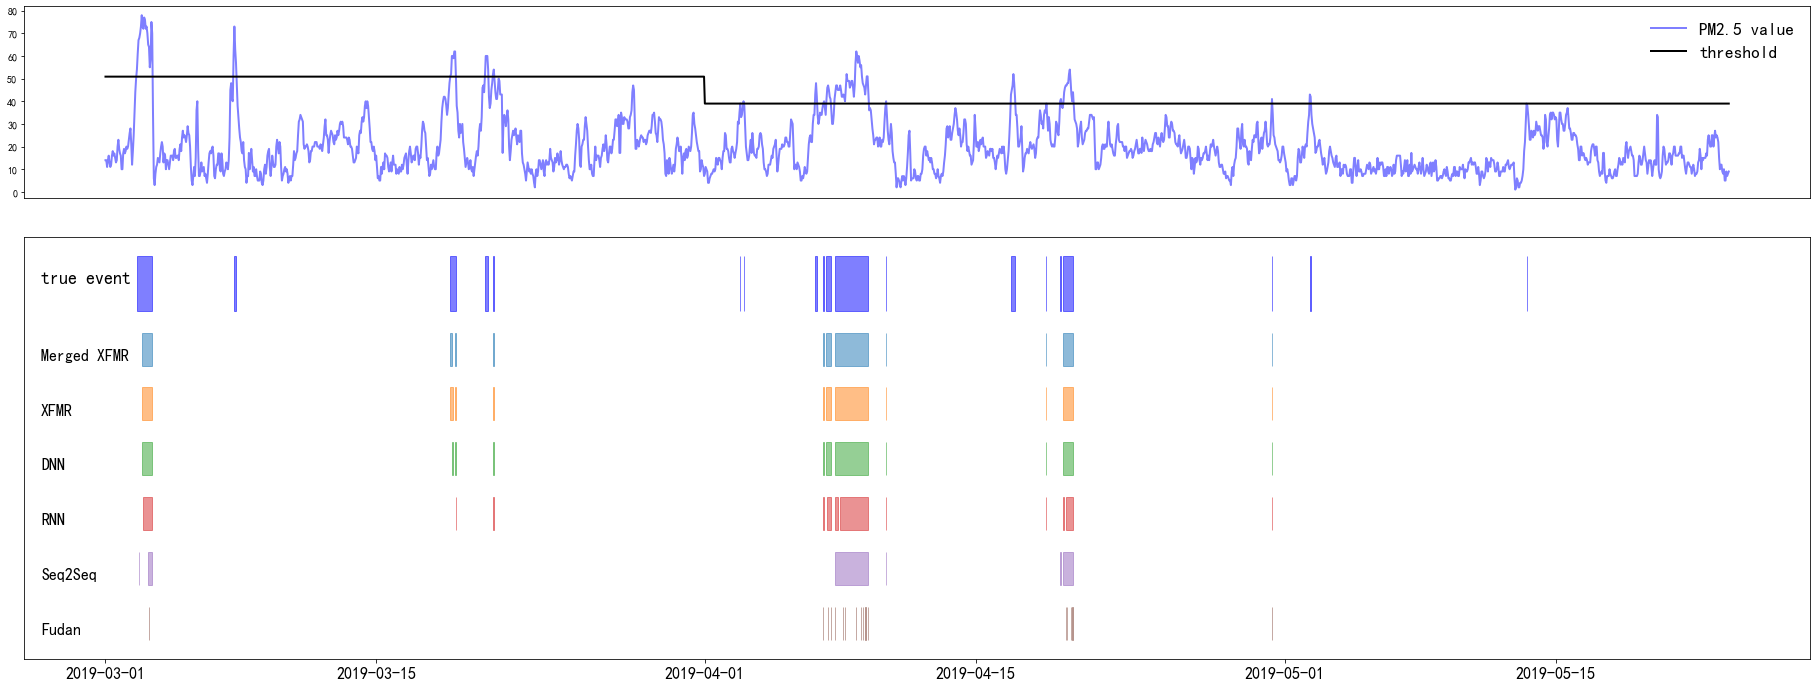

觀音


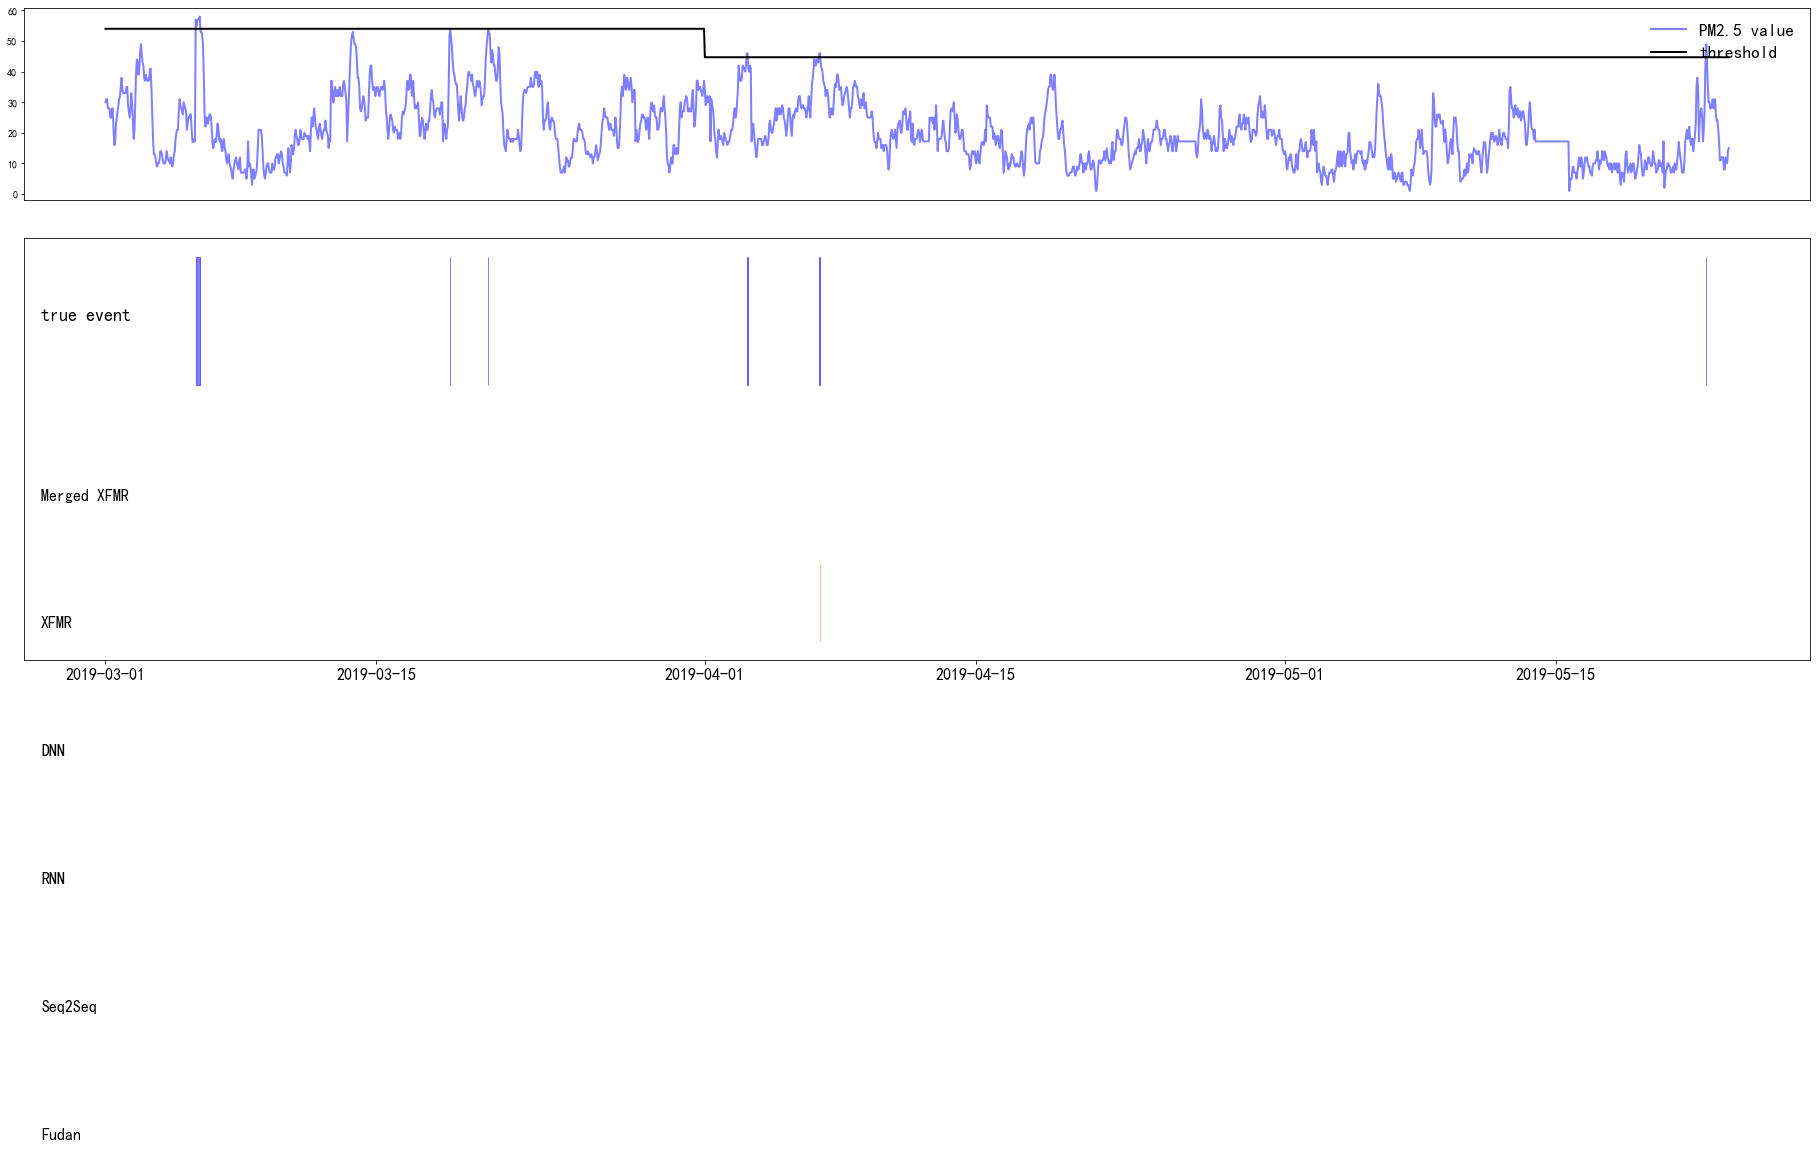

新莊


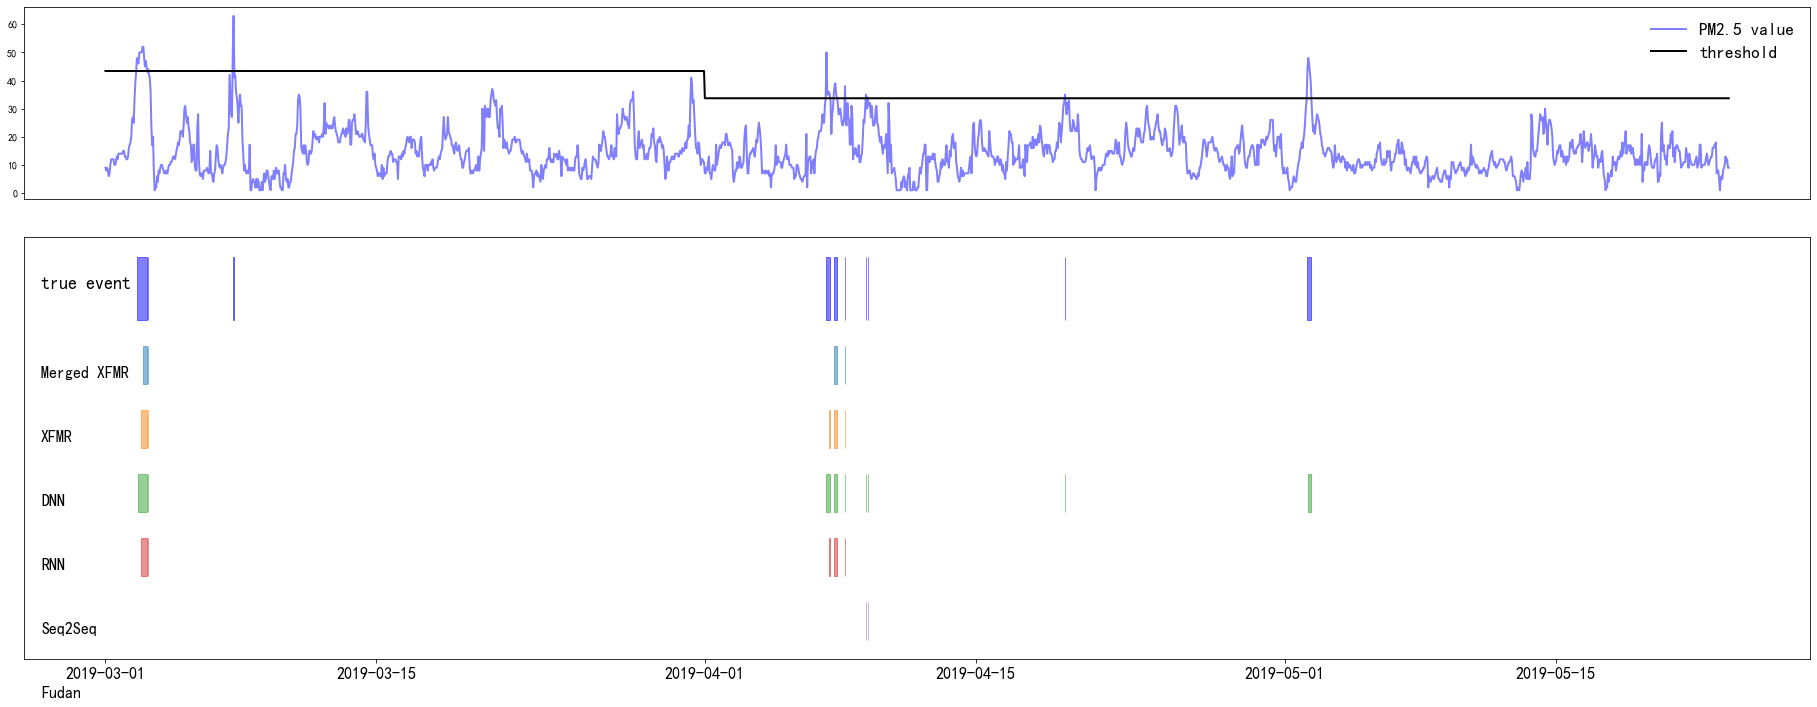

古亭


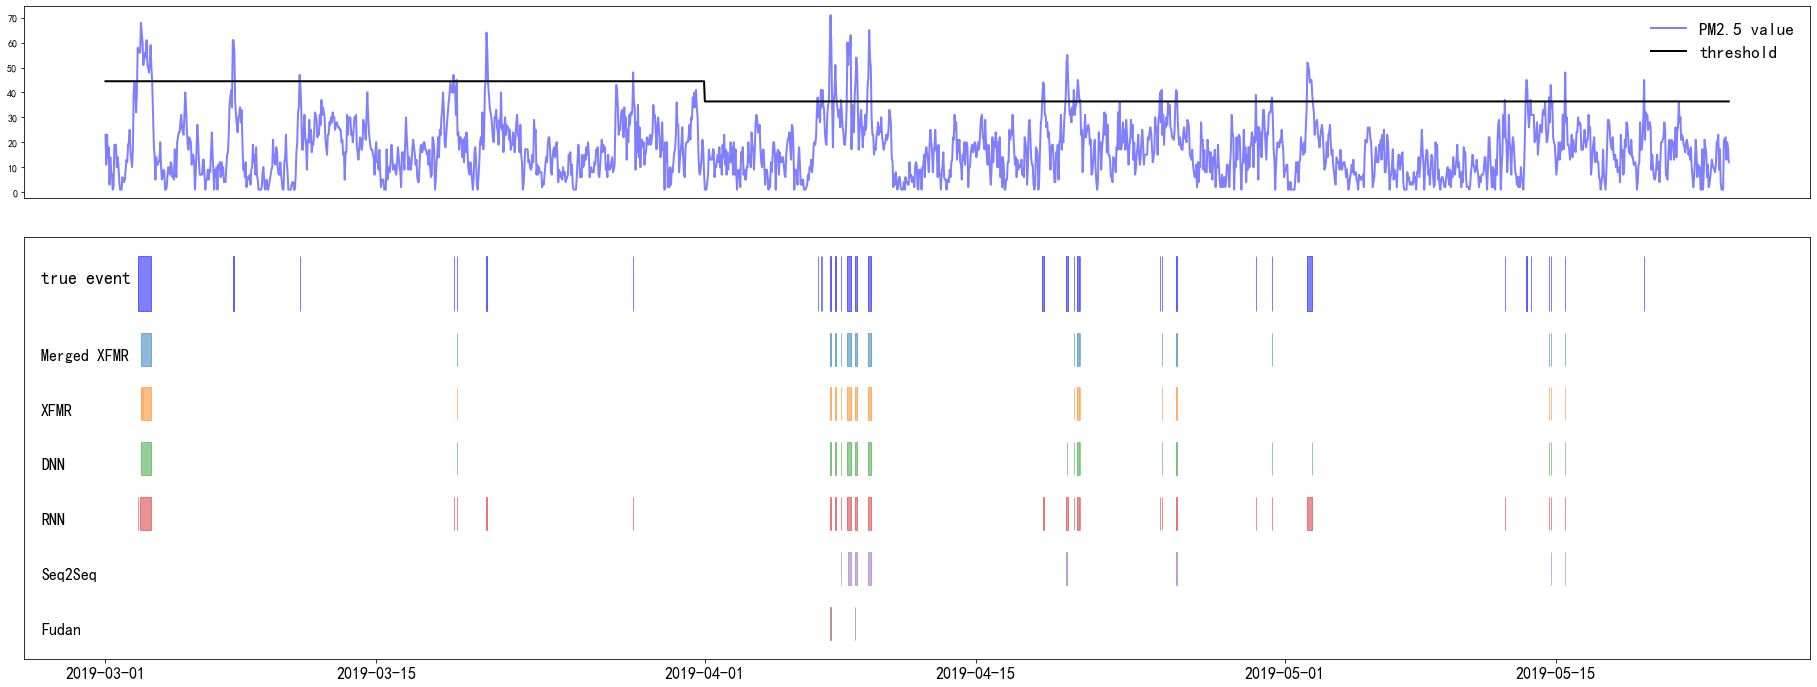

永和


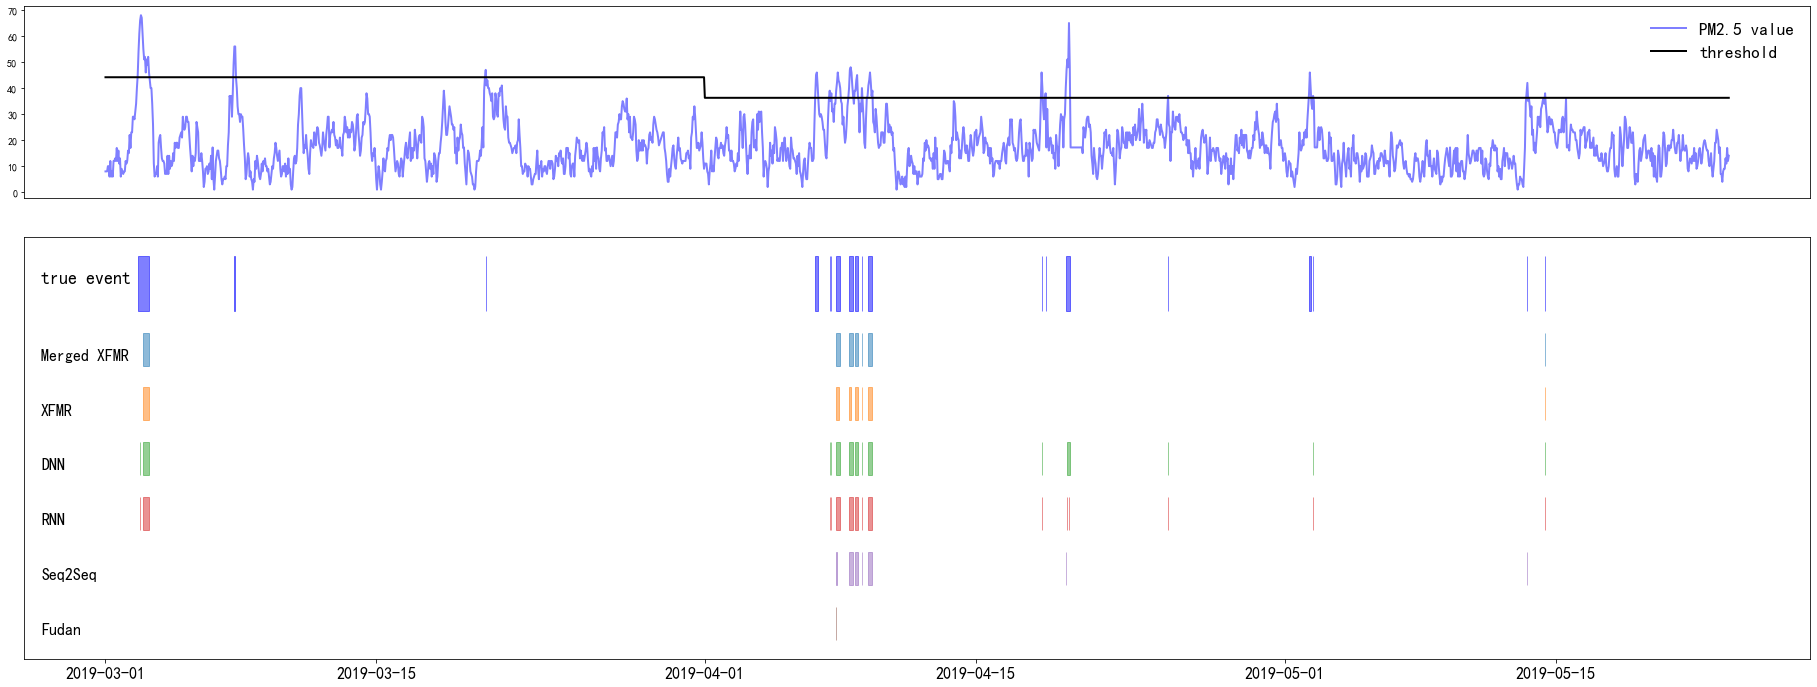

板橋


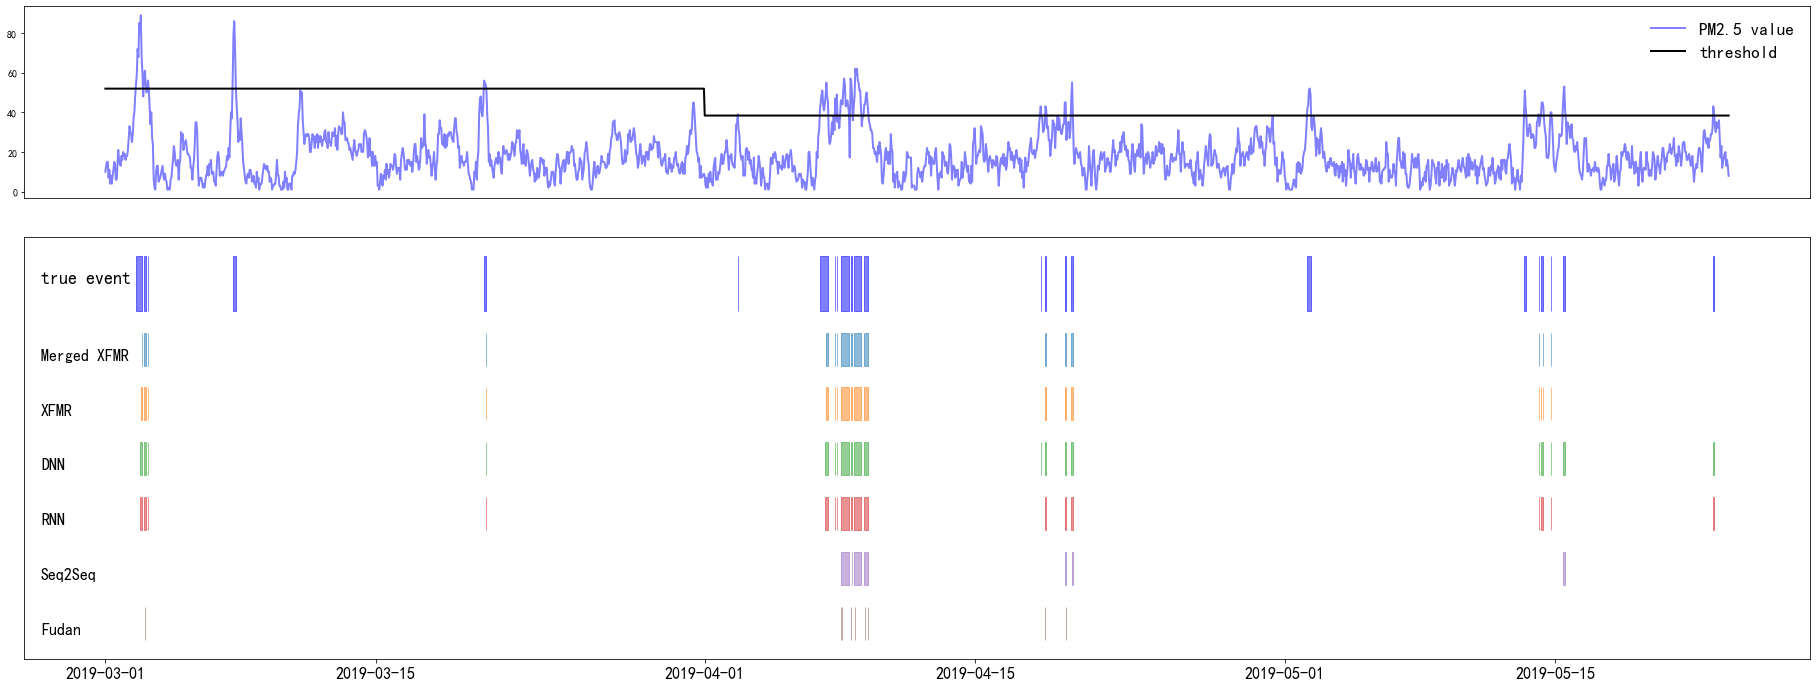

桃園


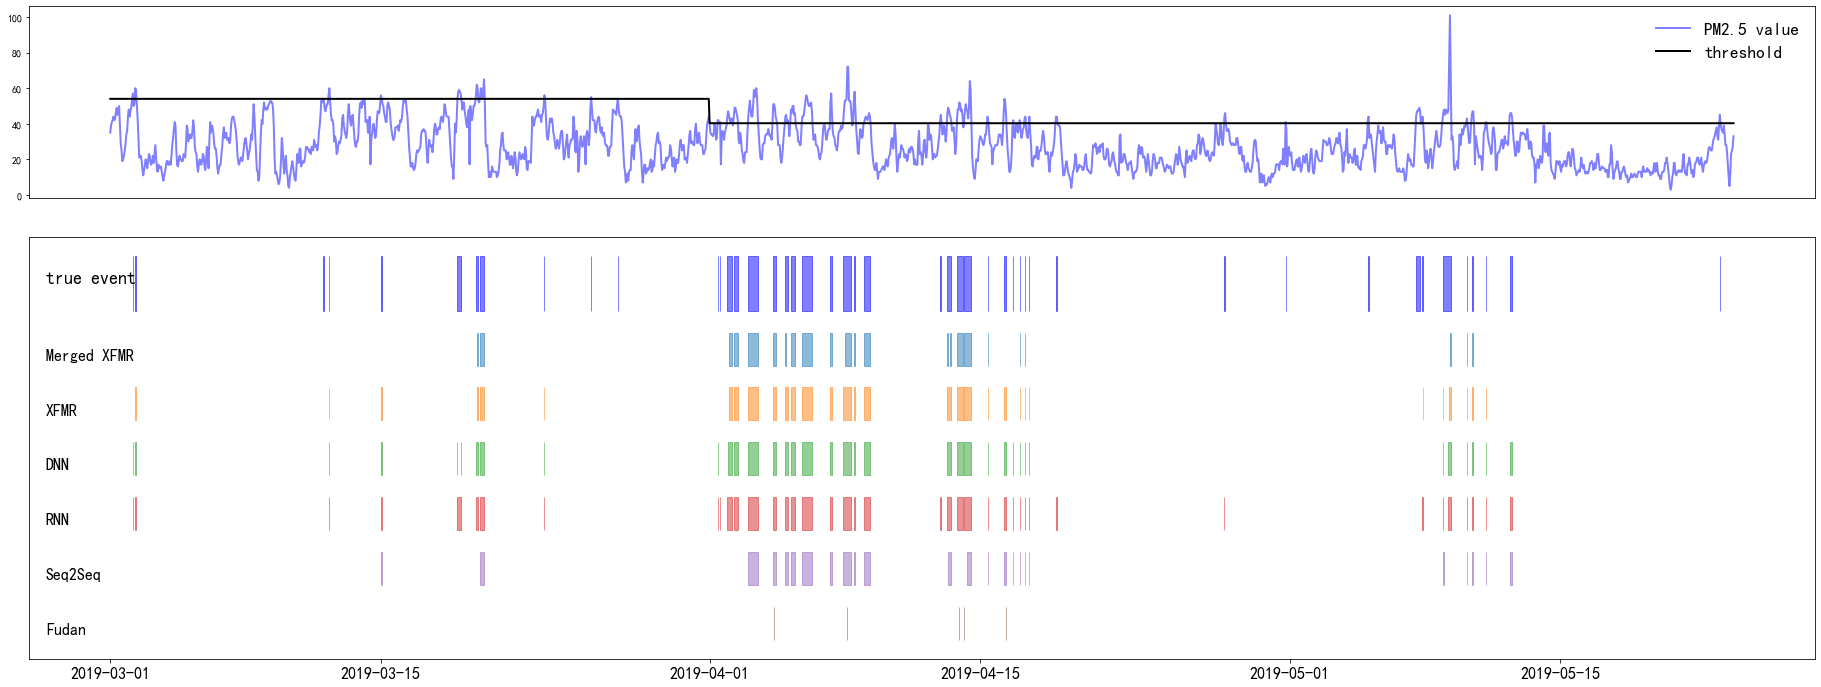

土城


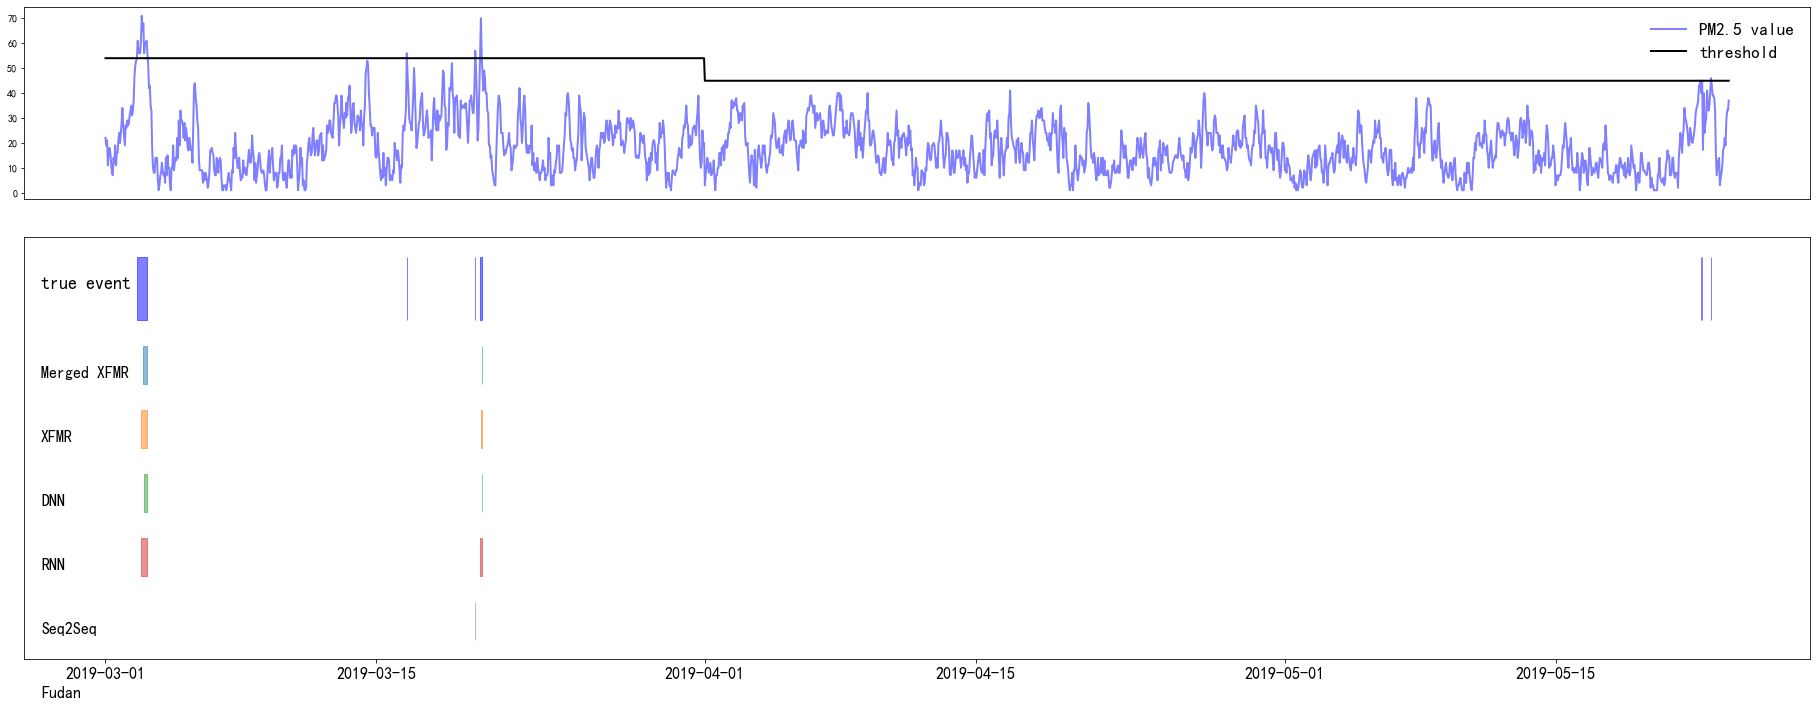

新店


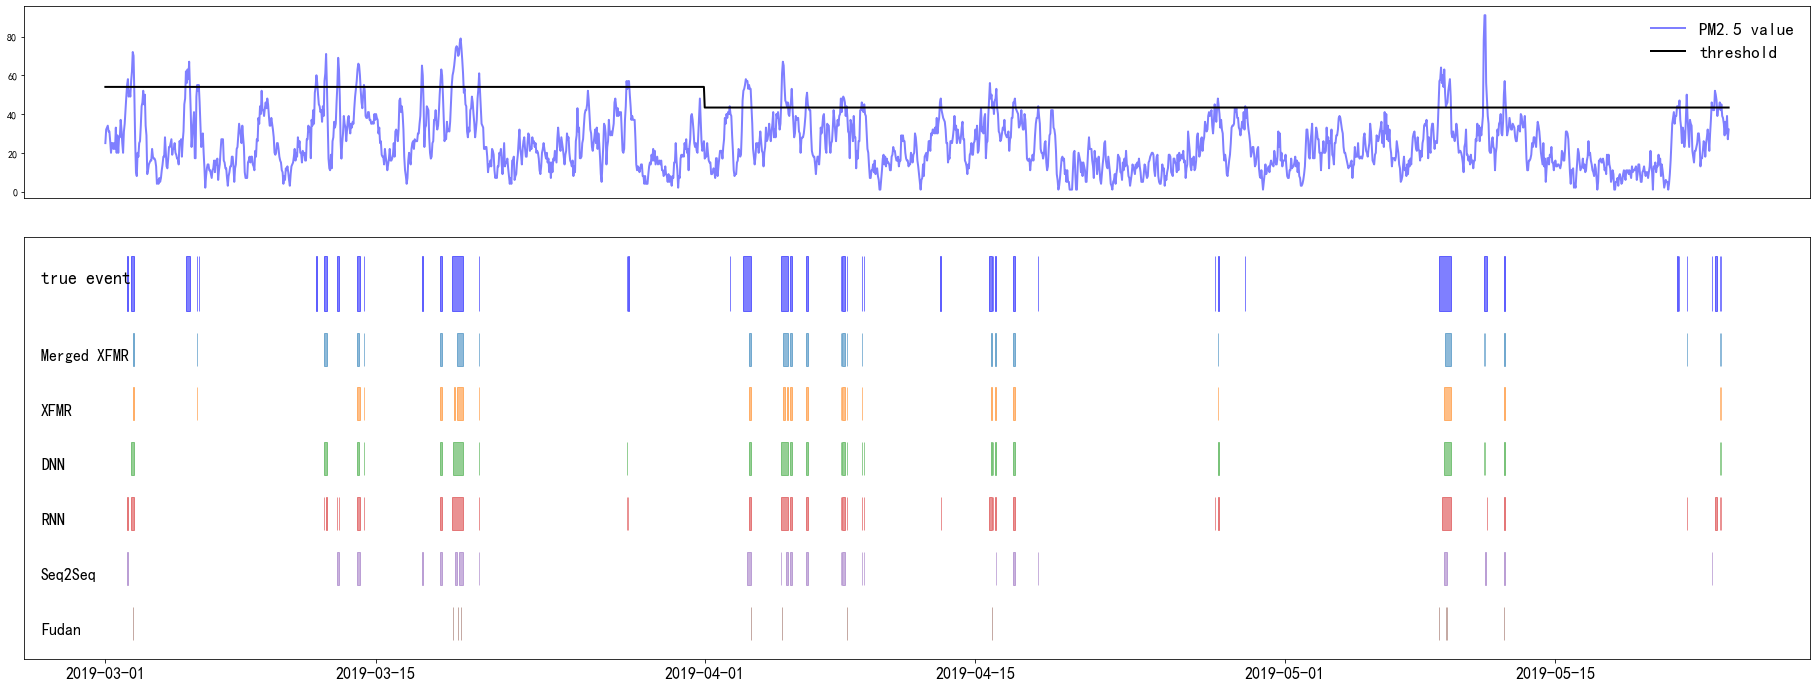

平鎮


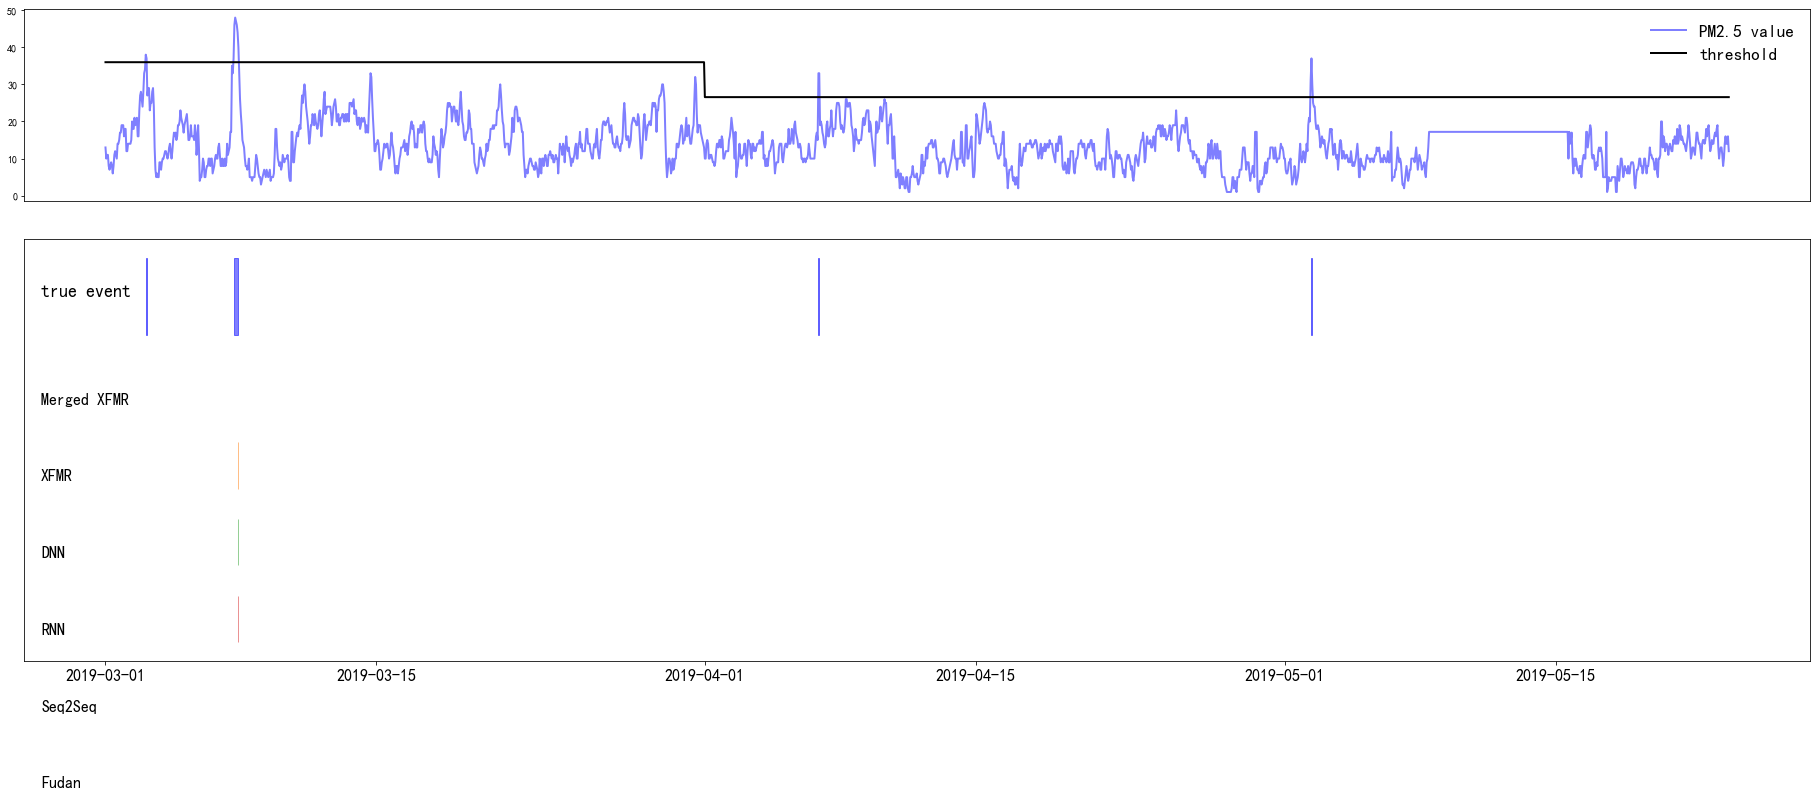

中壢


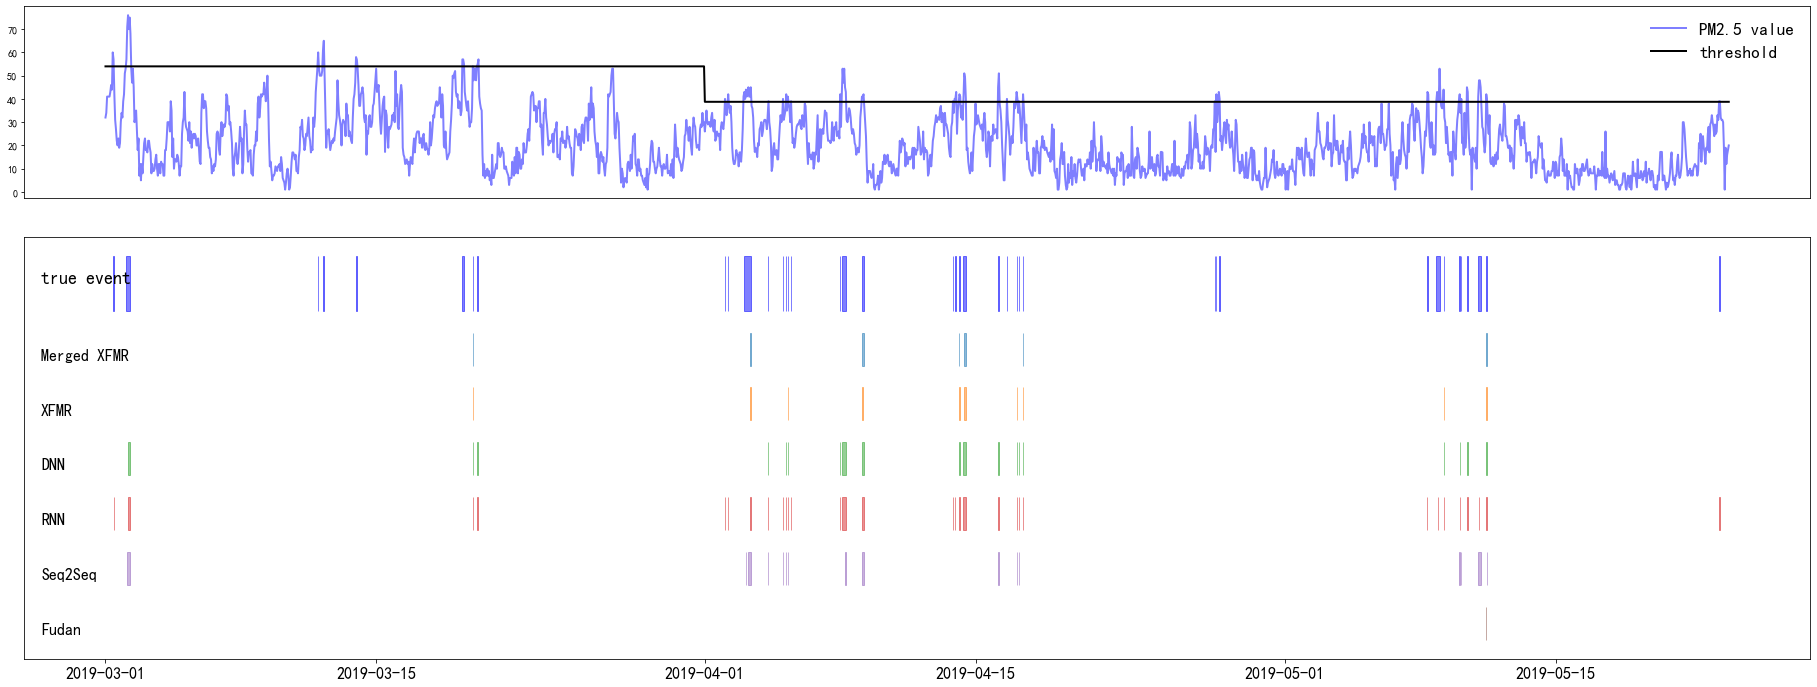

湖口


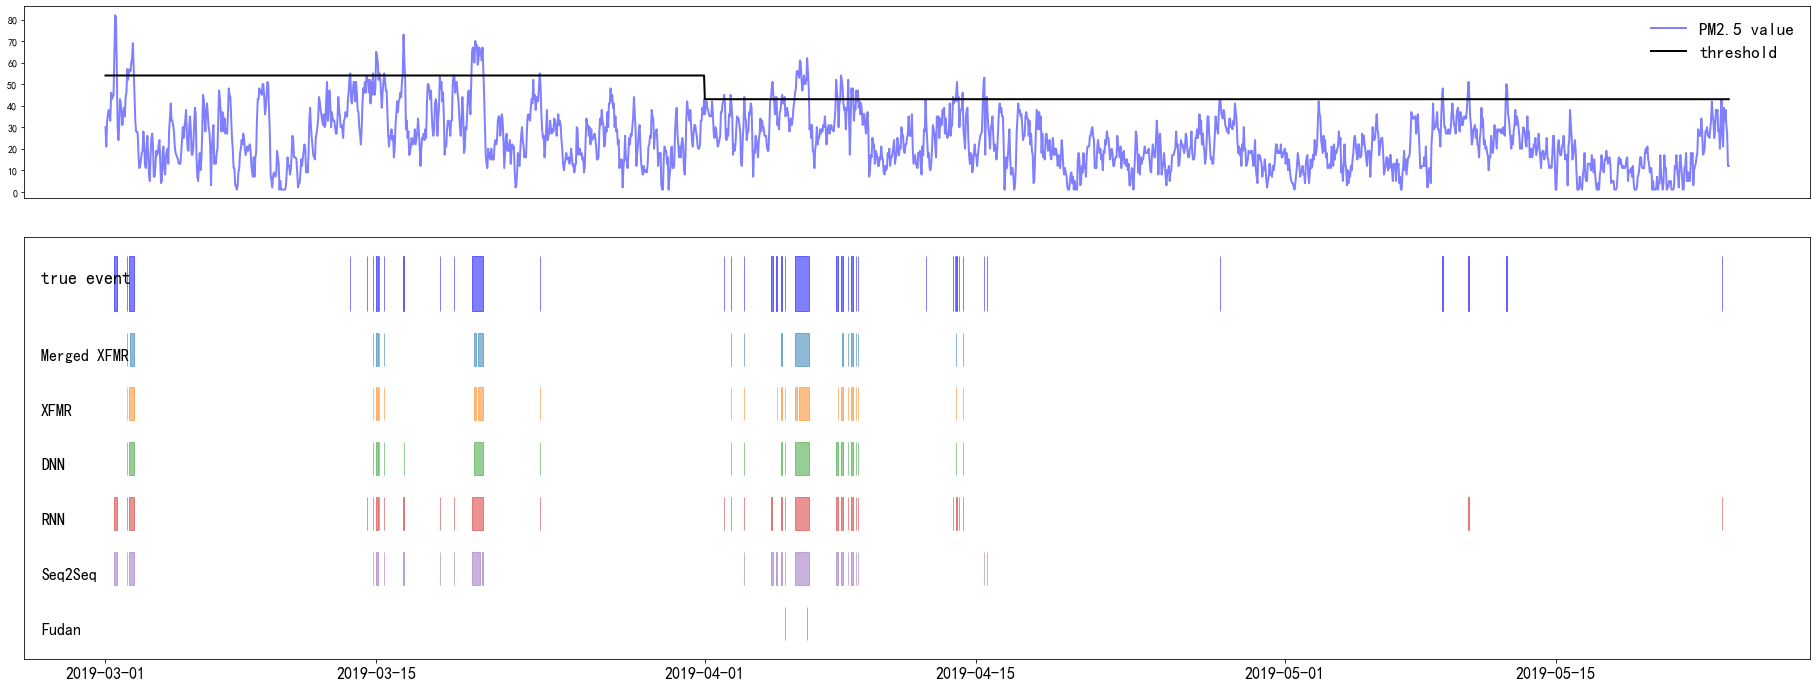

龍潭


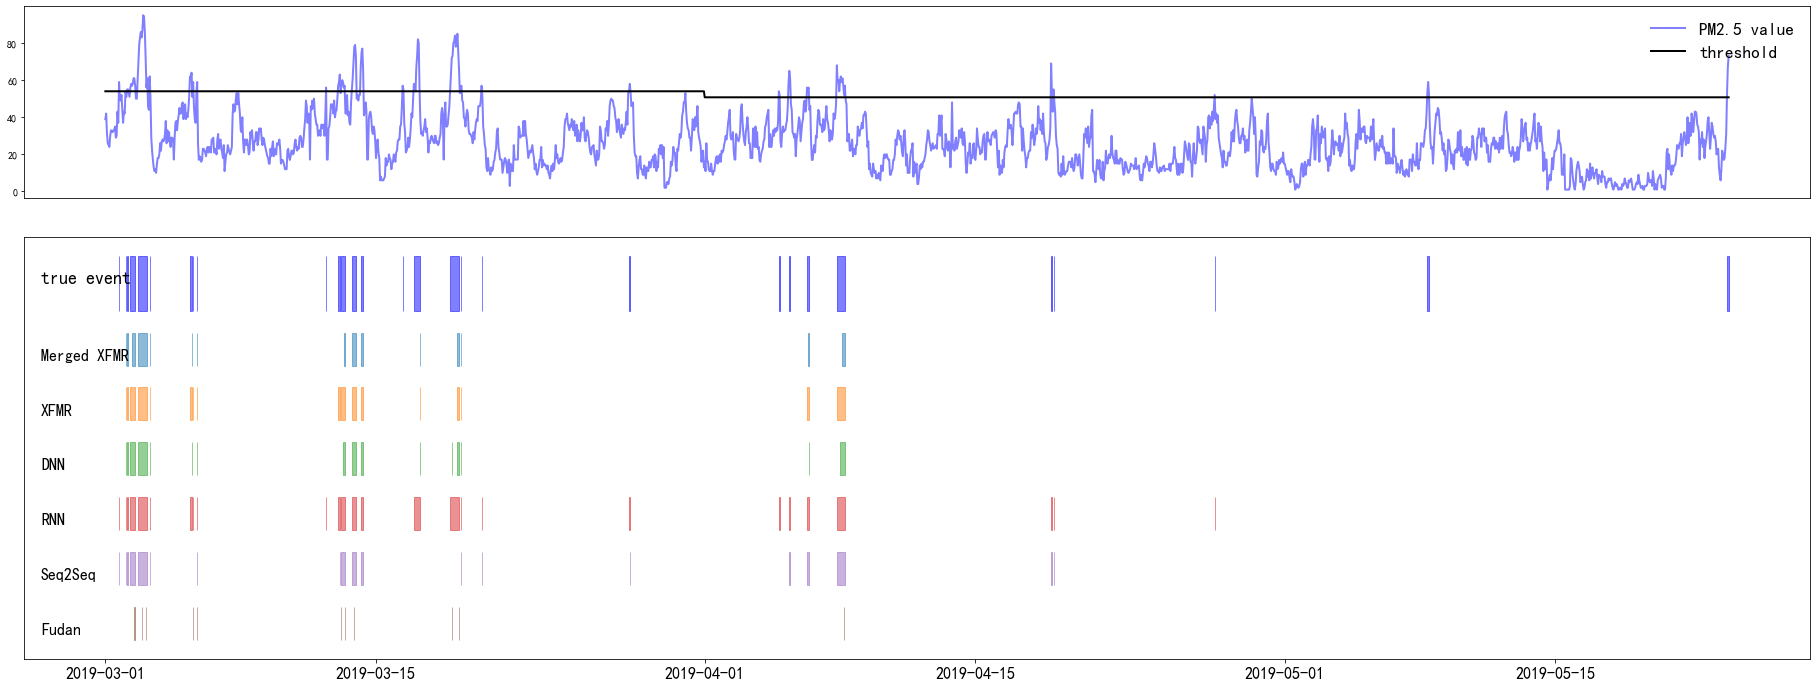

新竹


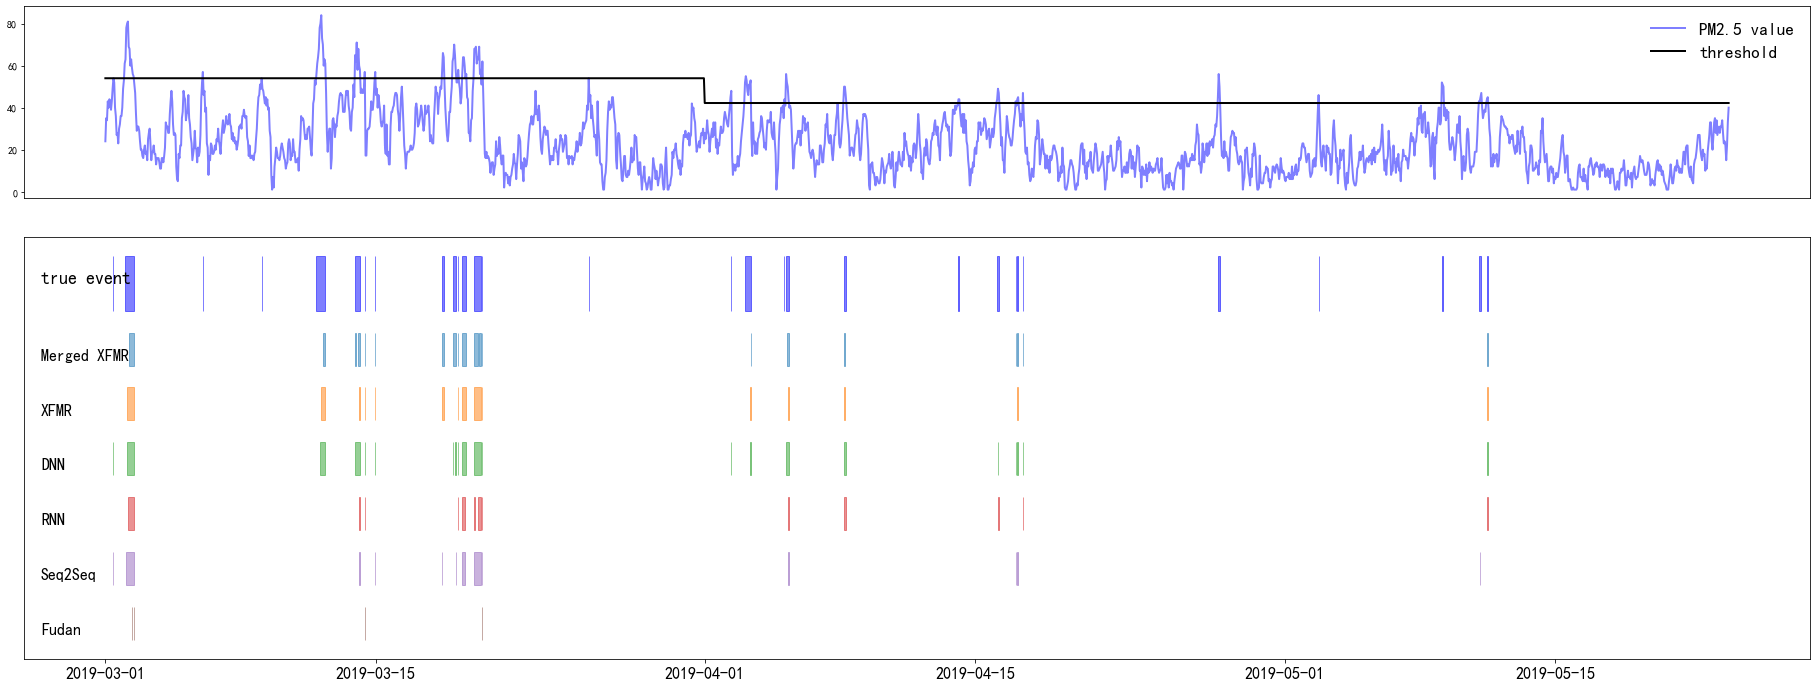

竹東


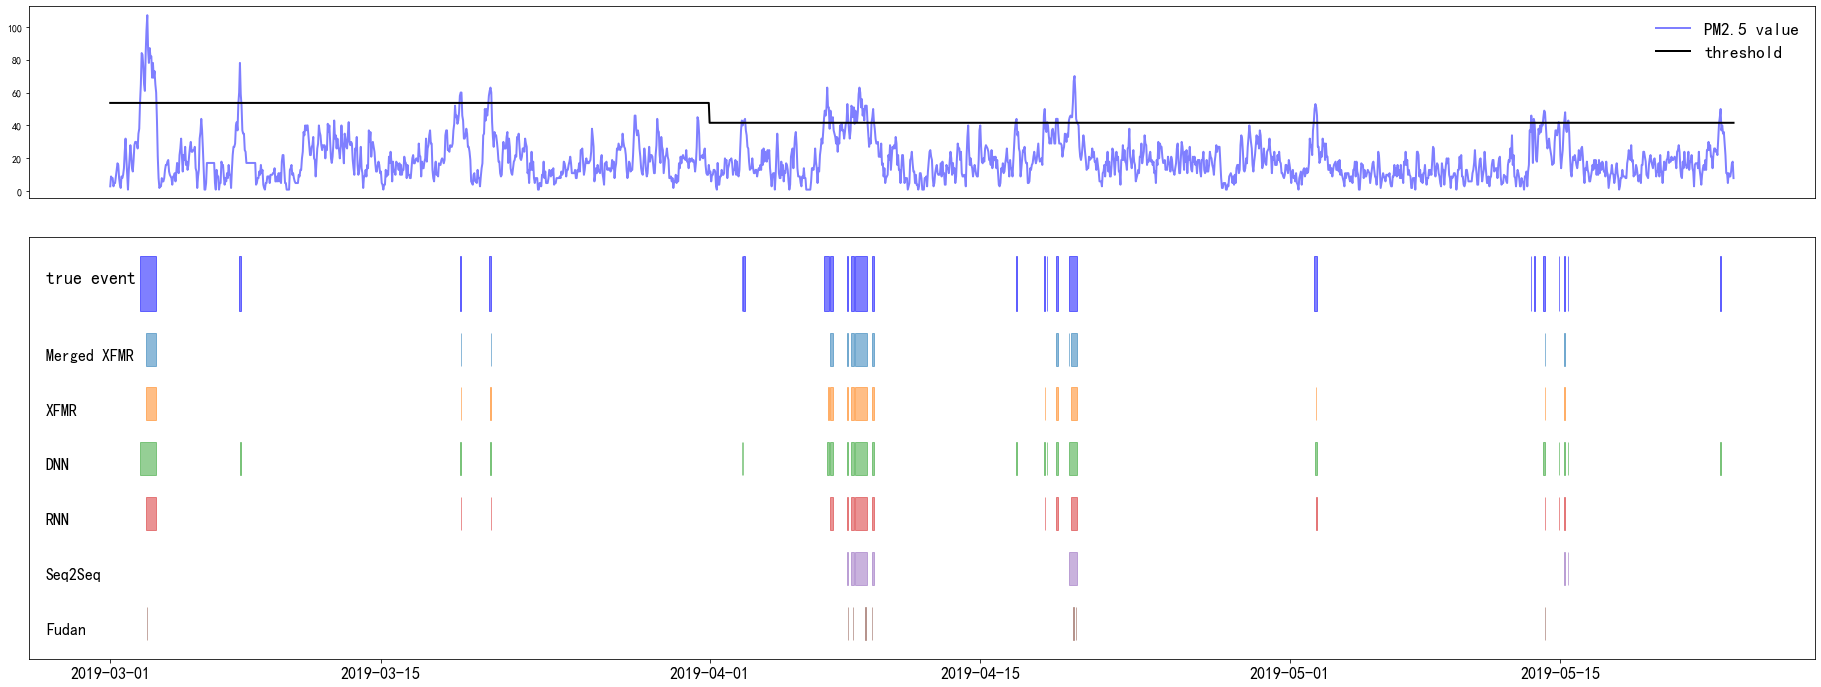

宜蘭


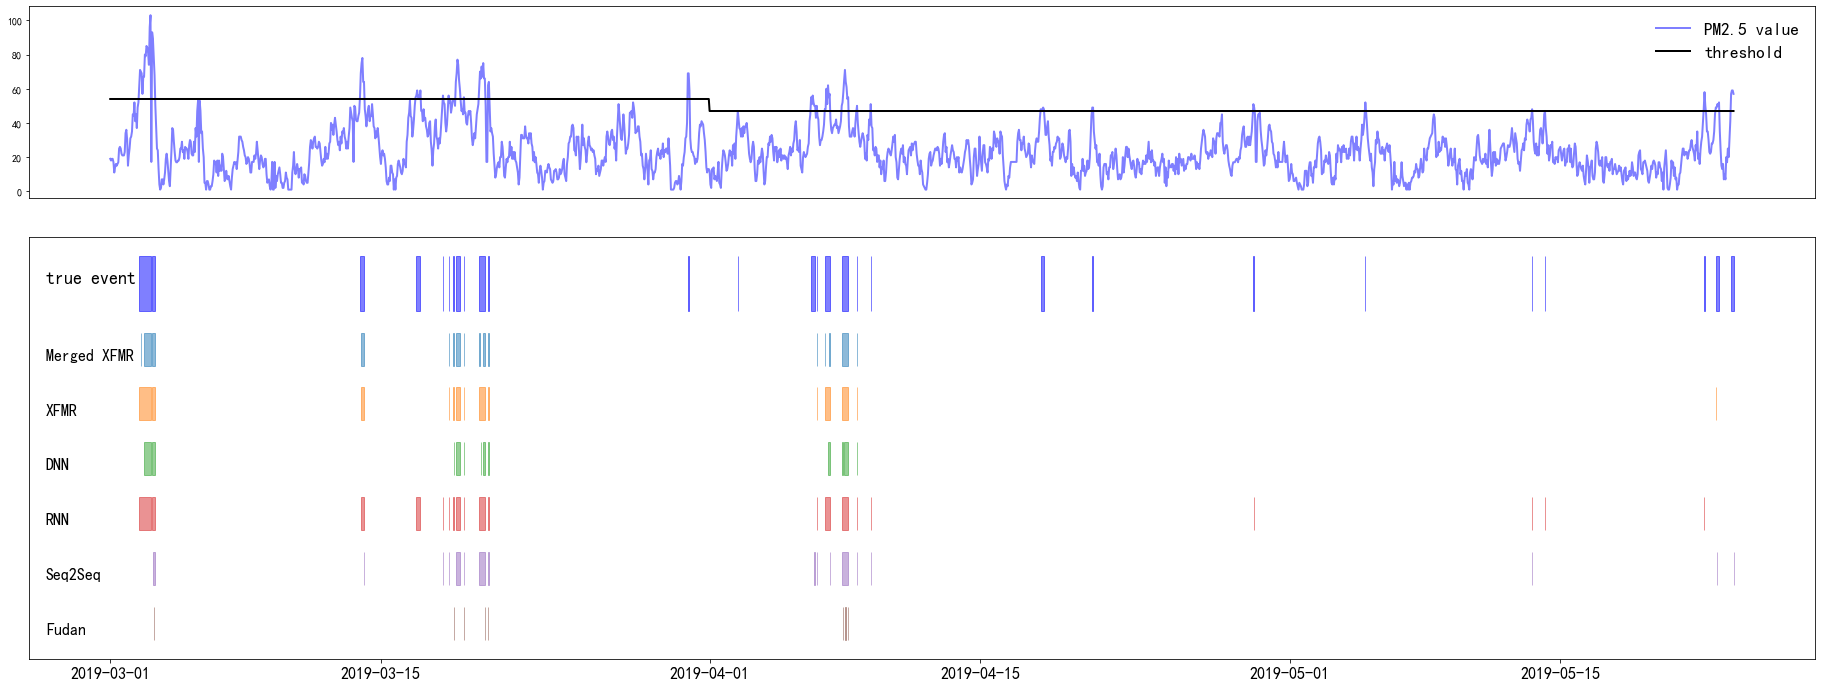

頭份


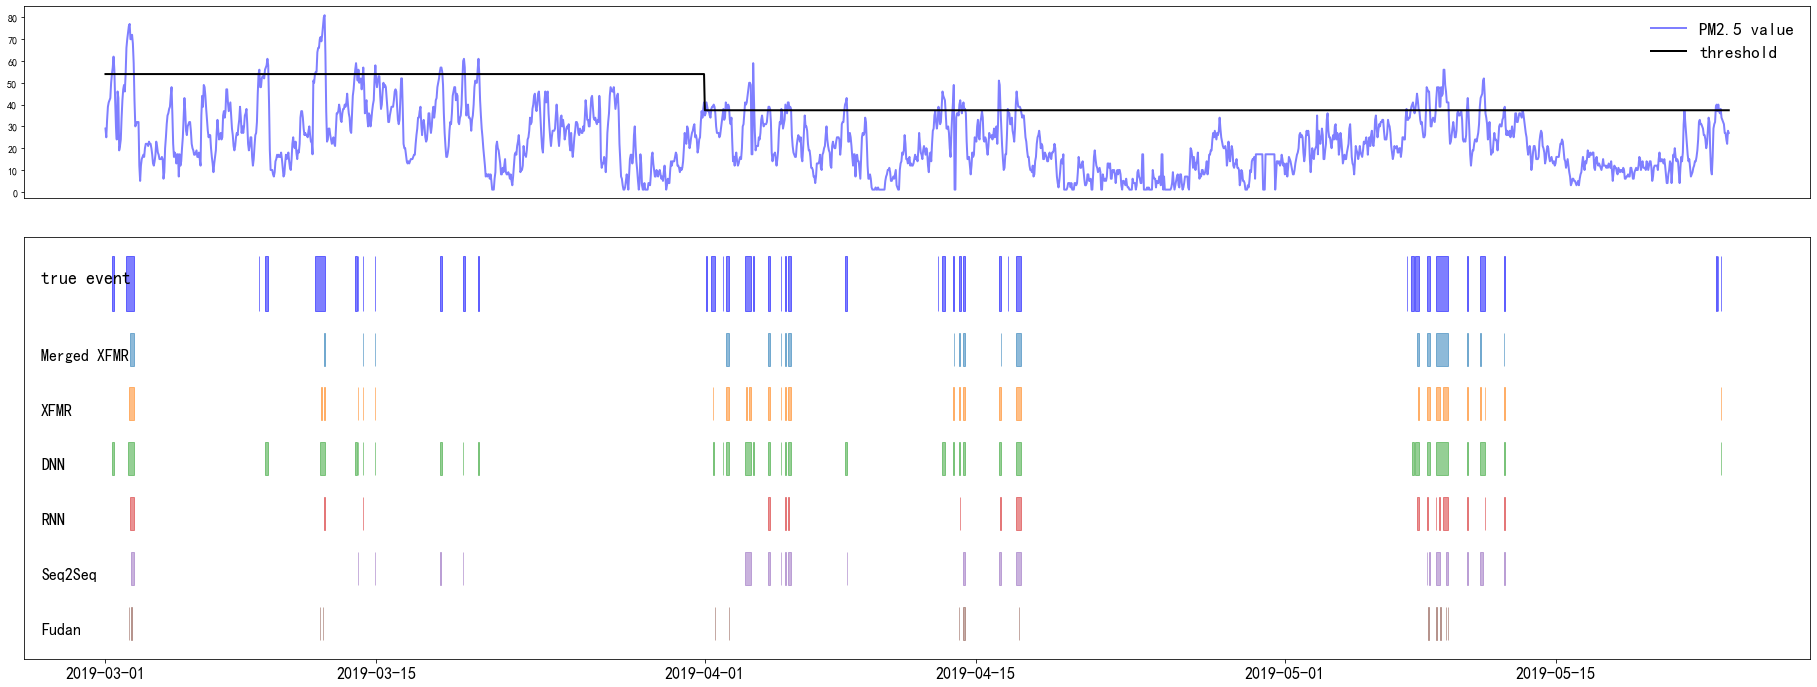

冬山


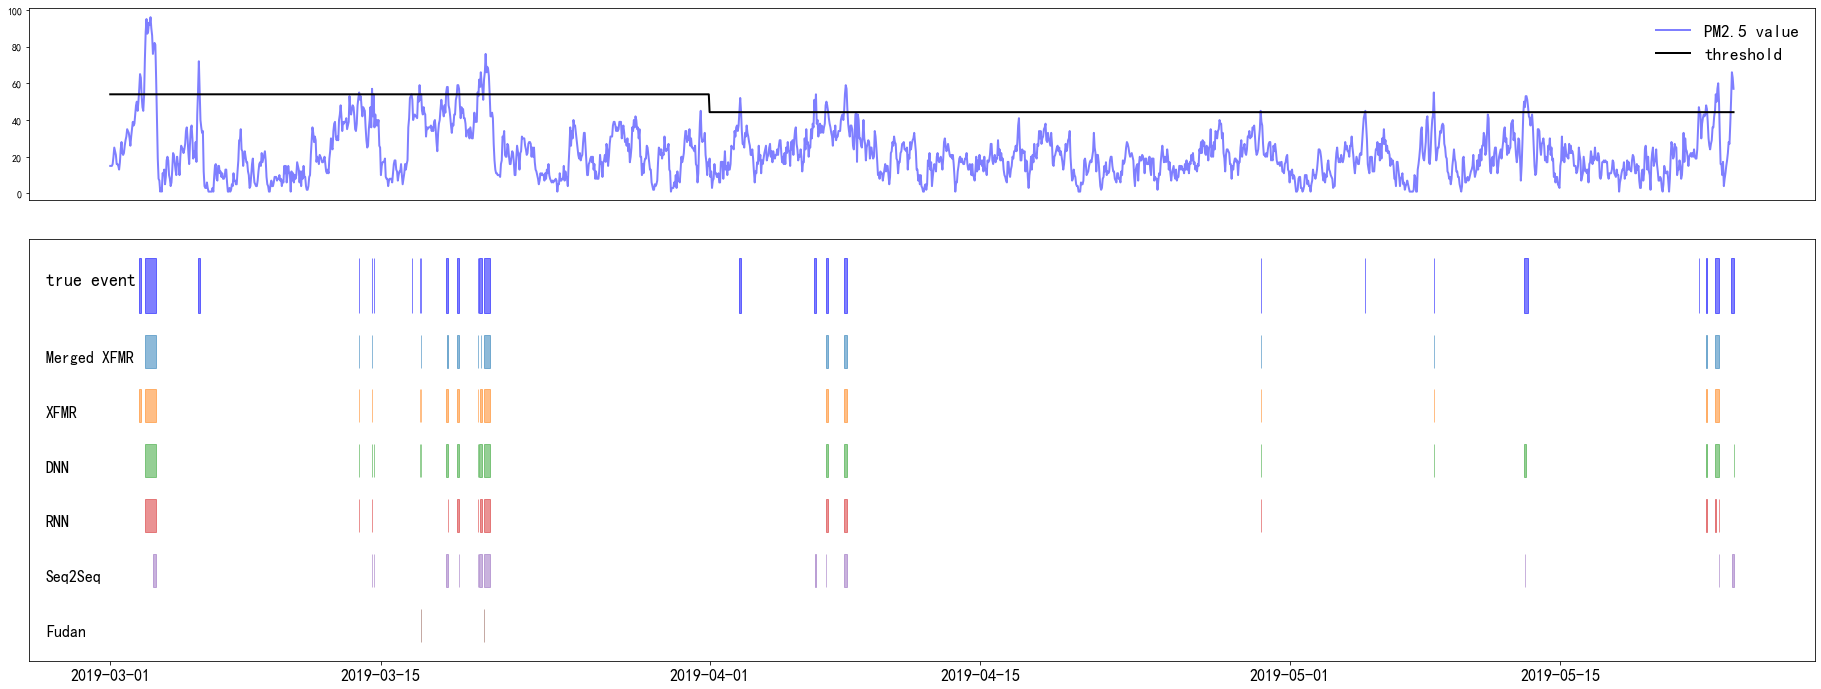

苗栗


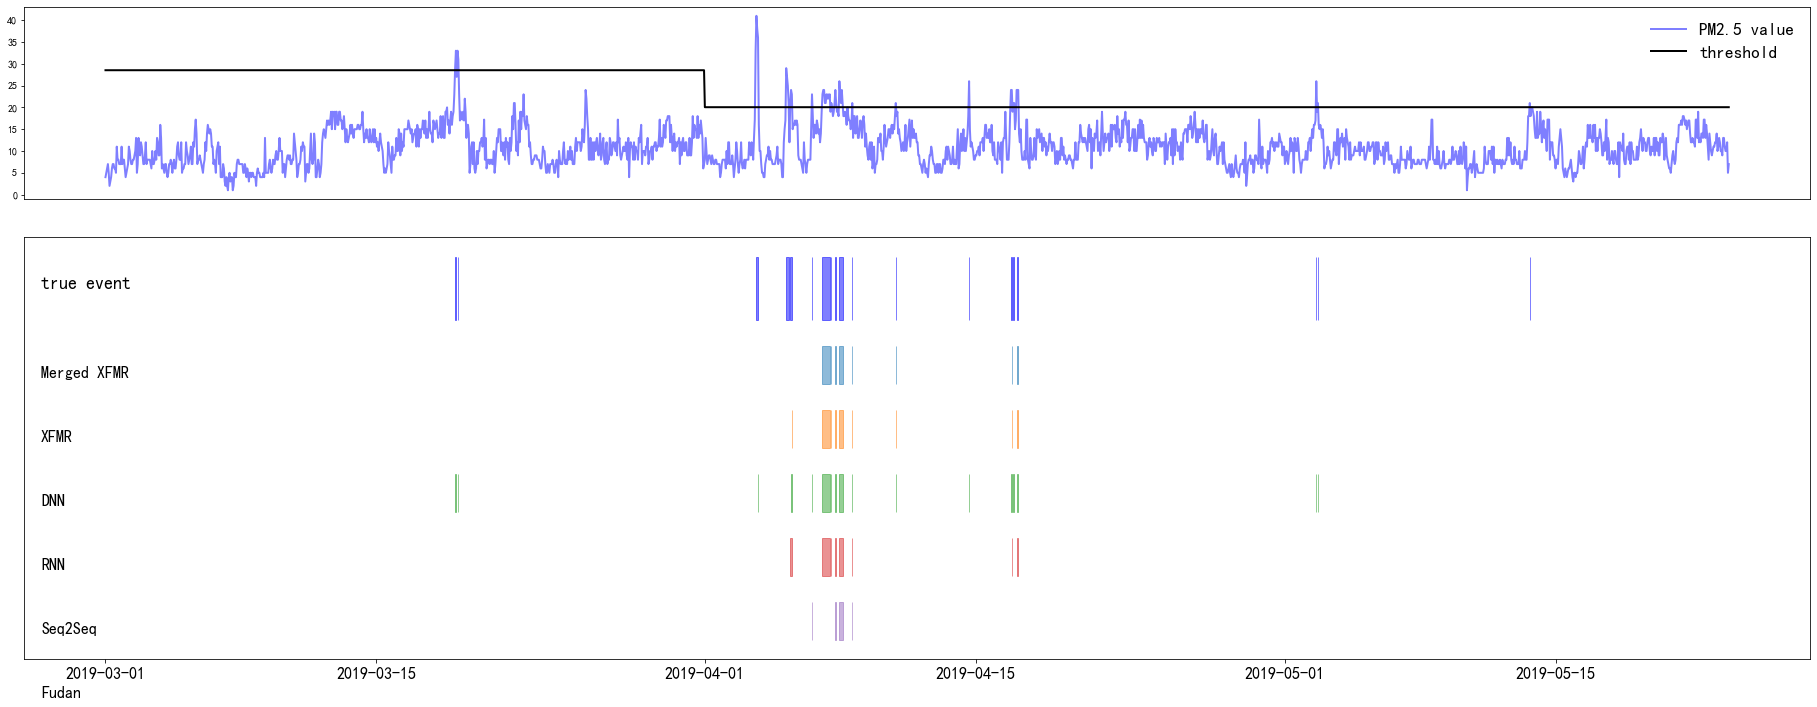

三義


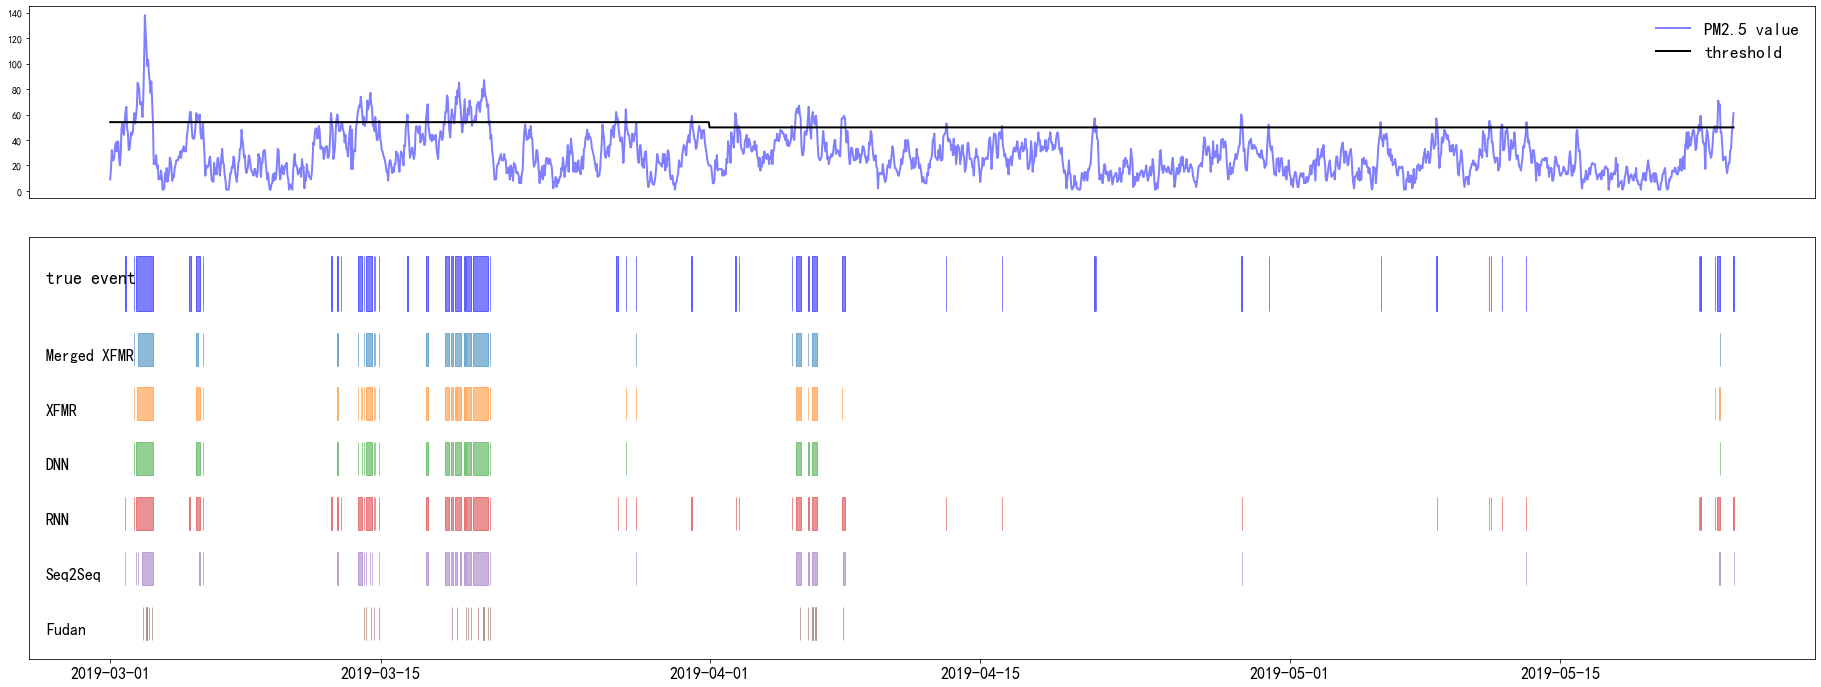

豐原


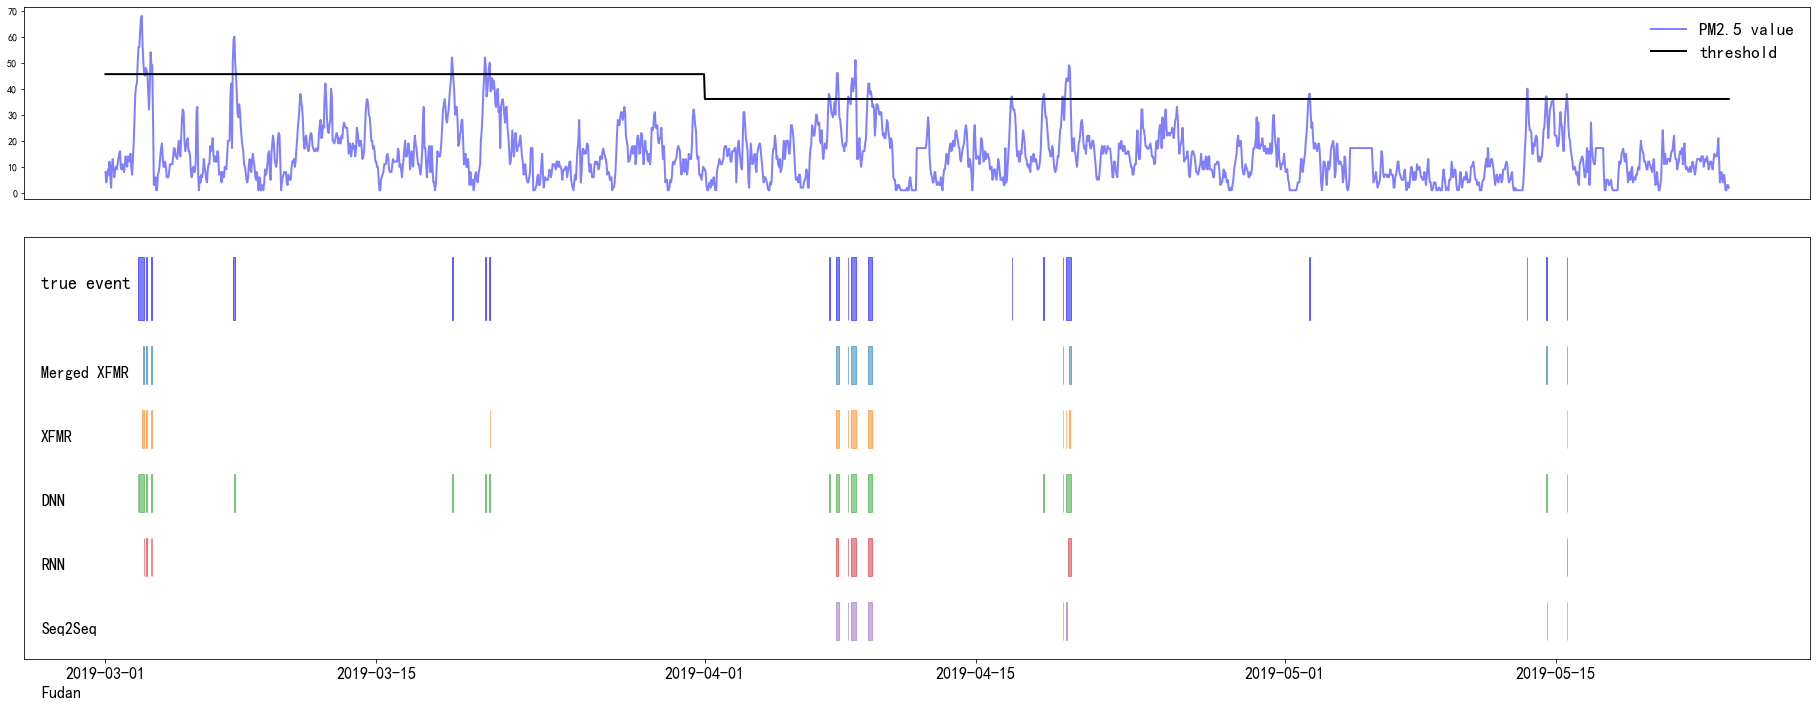

沙鹿


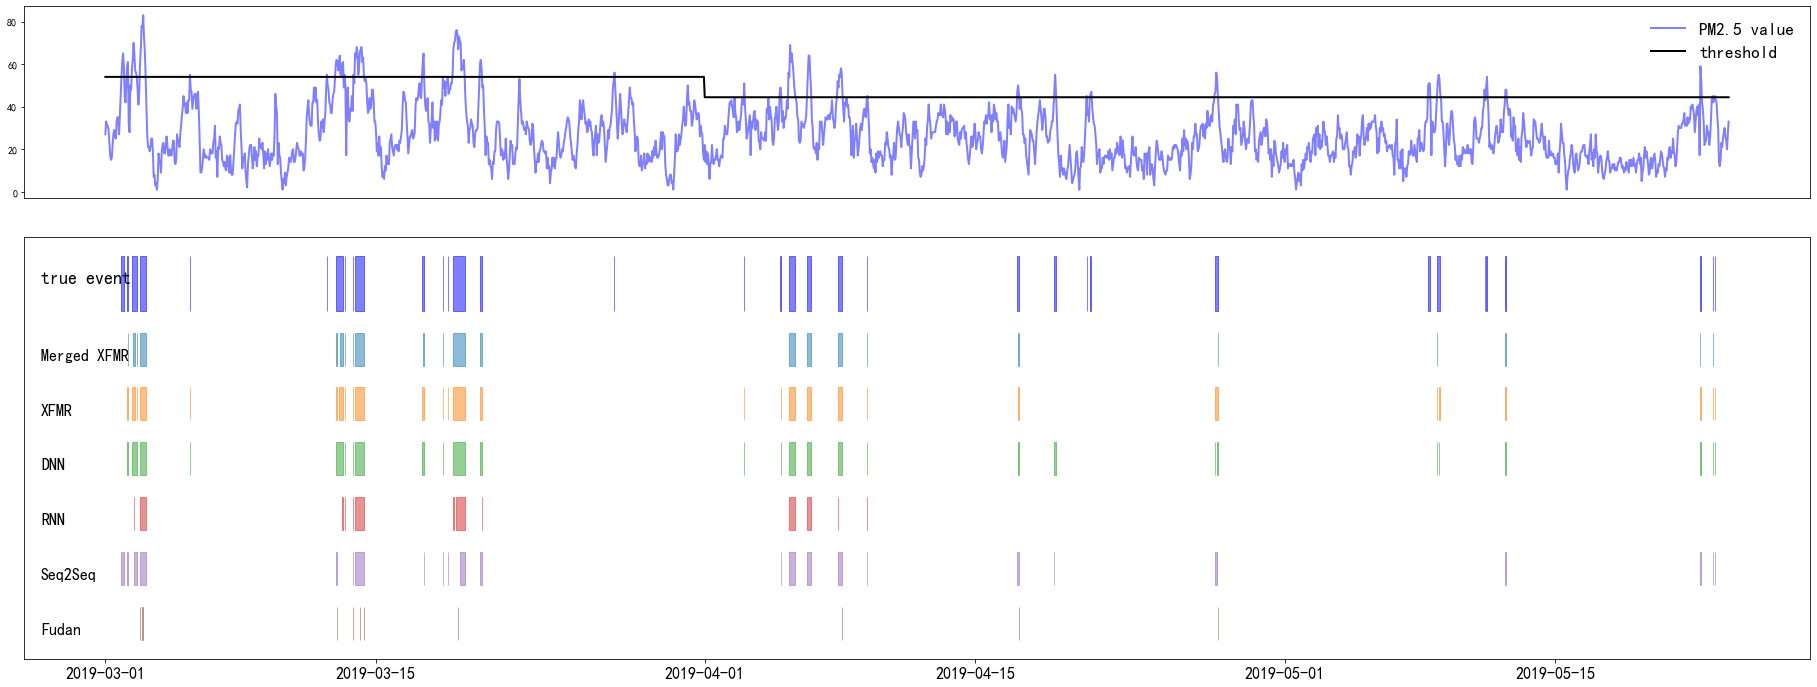

西屯


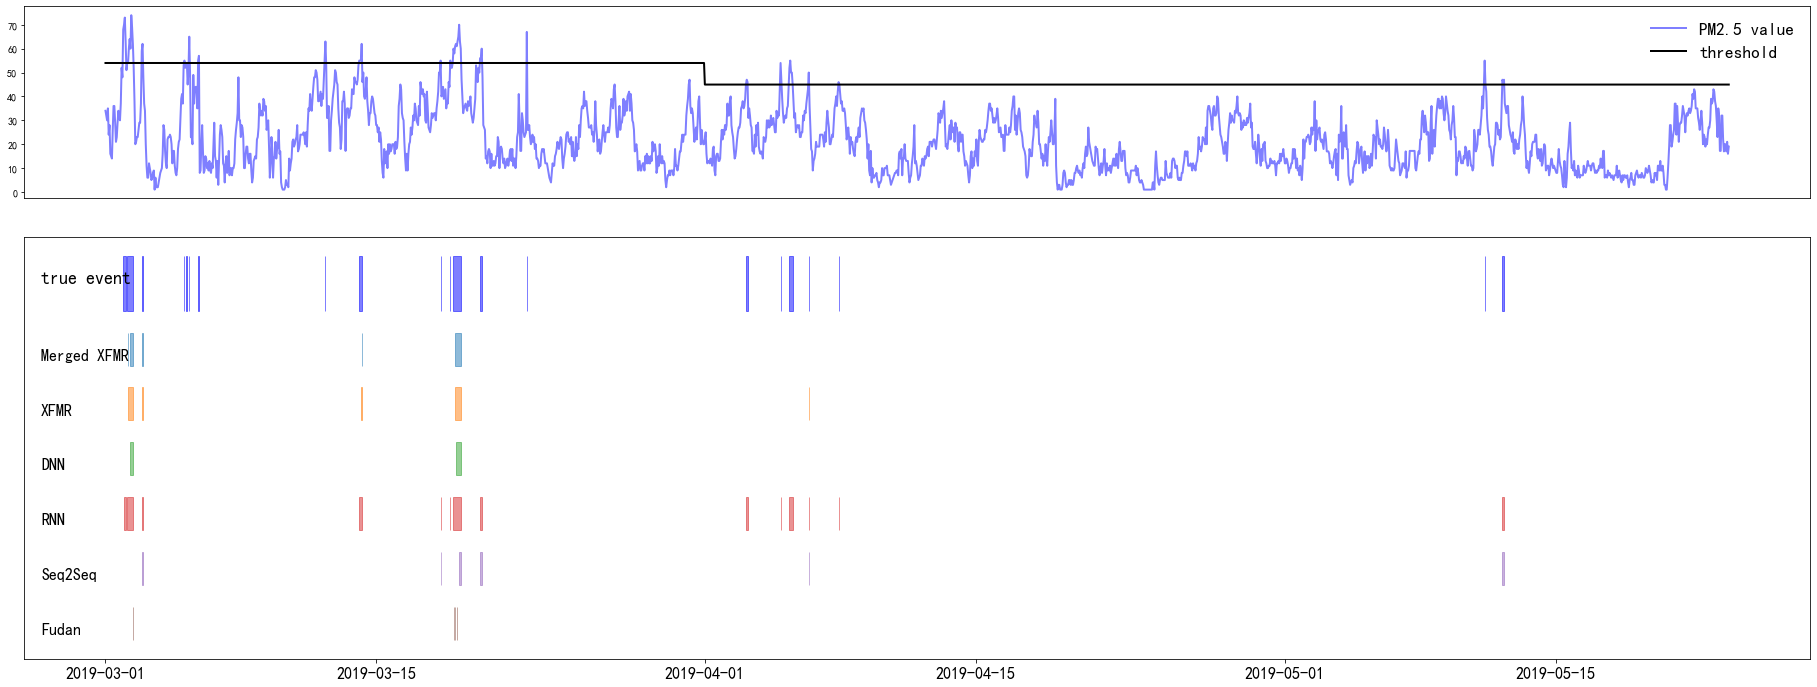

忠明


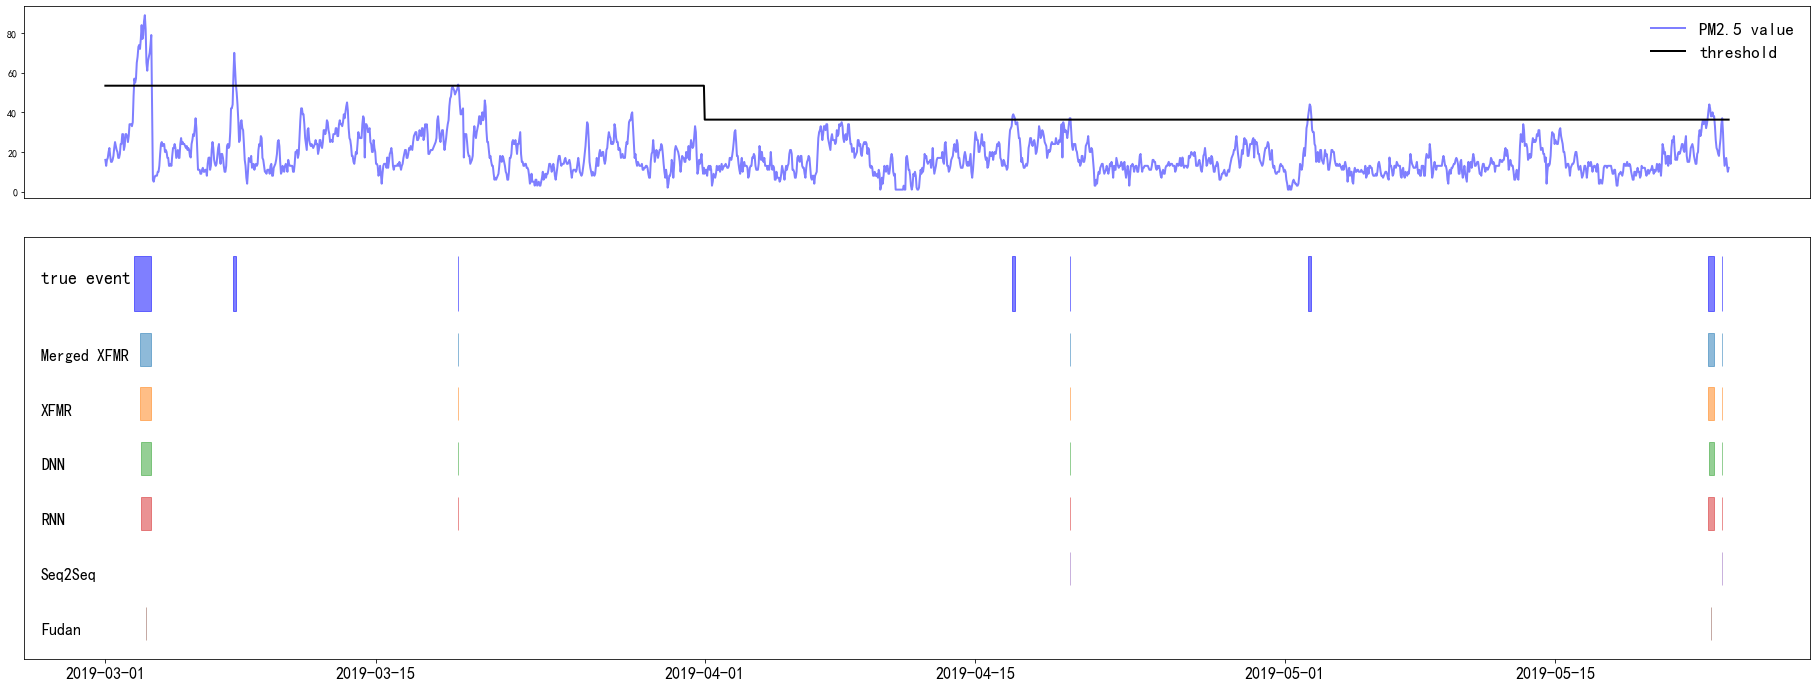

線西


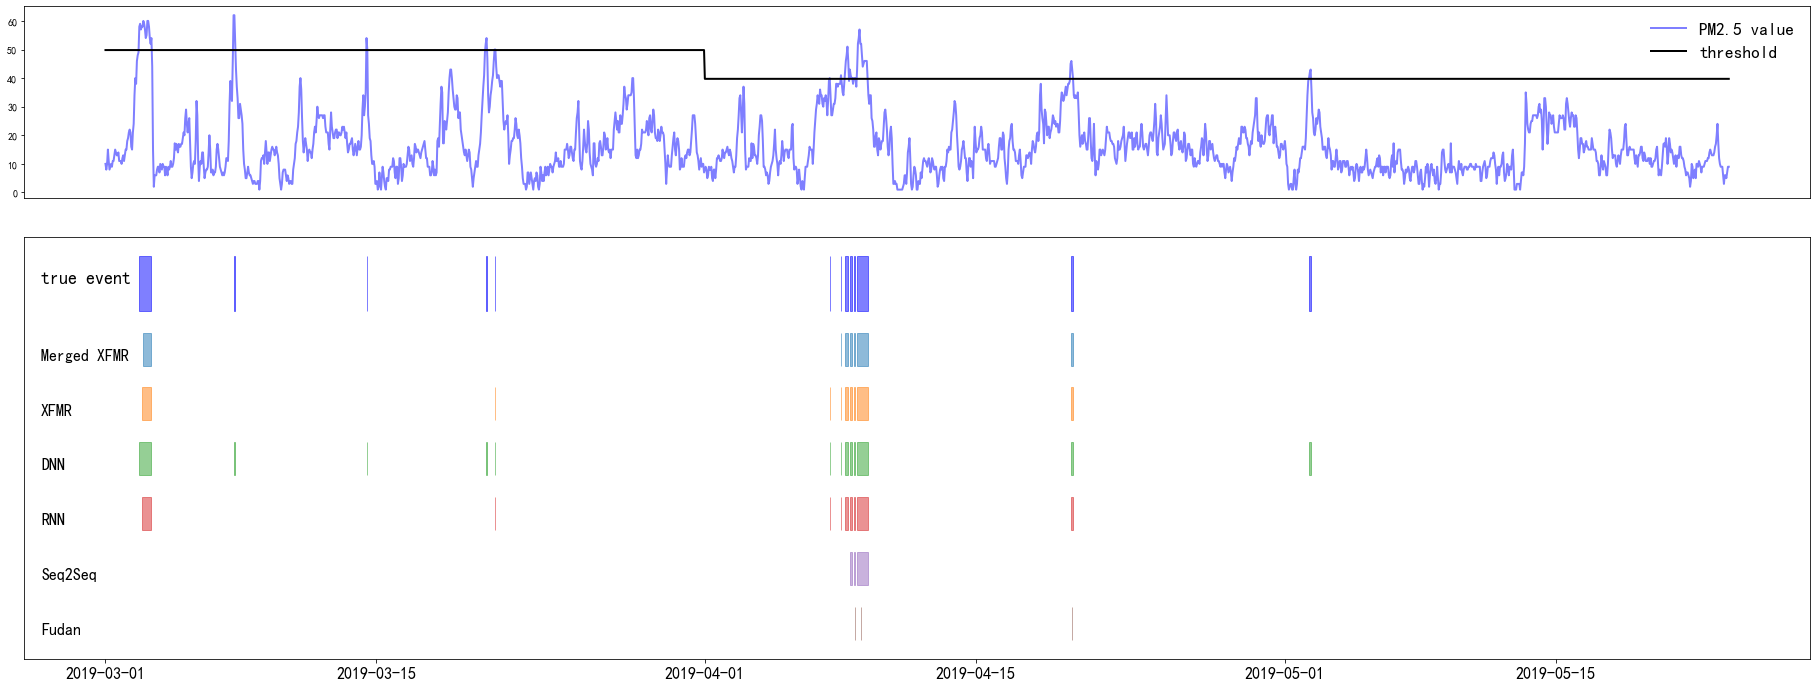

大里


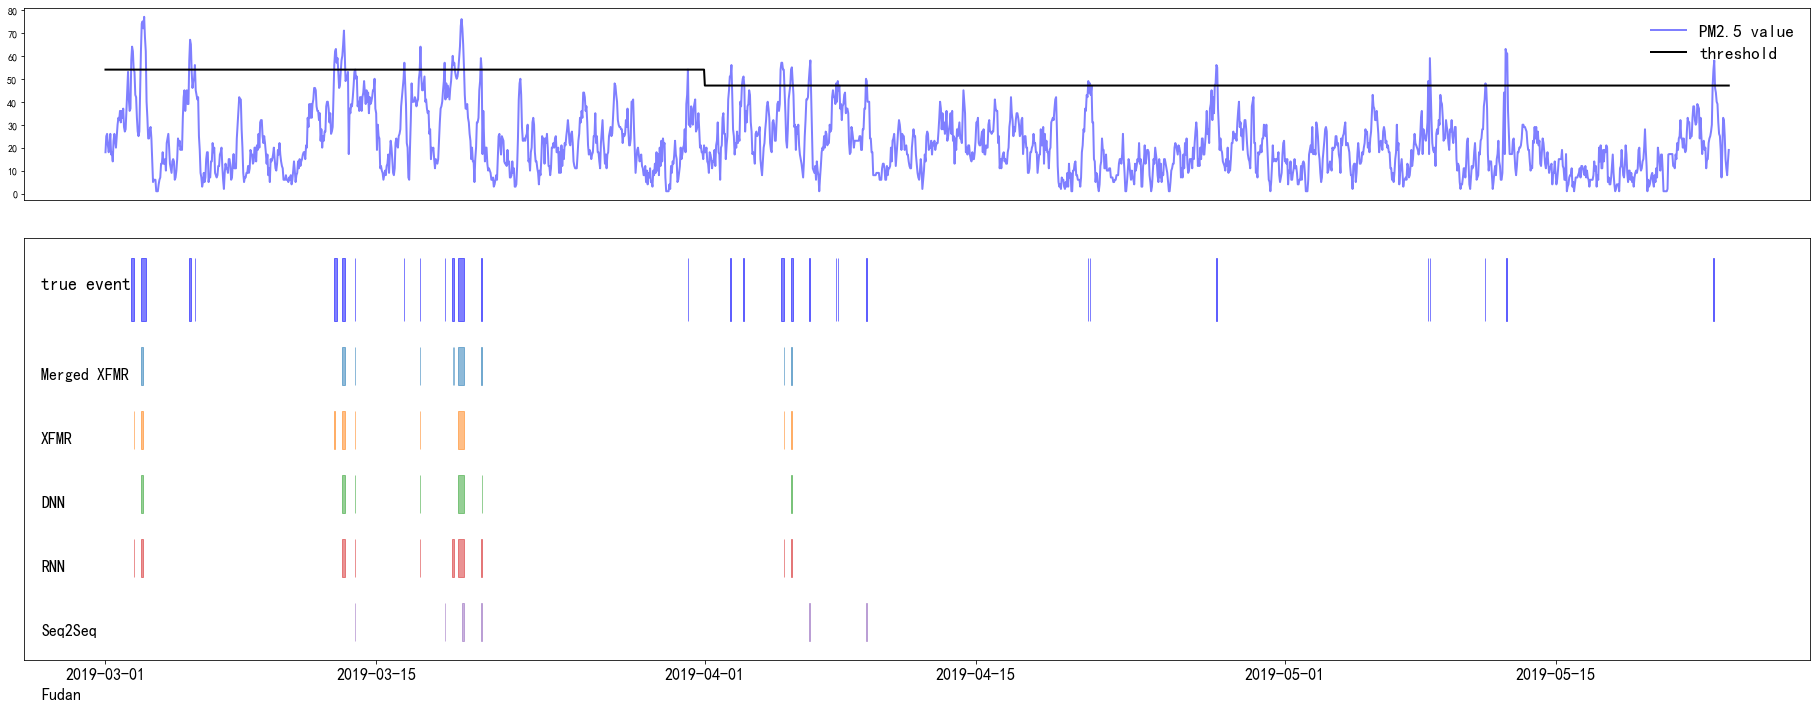

彰化


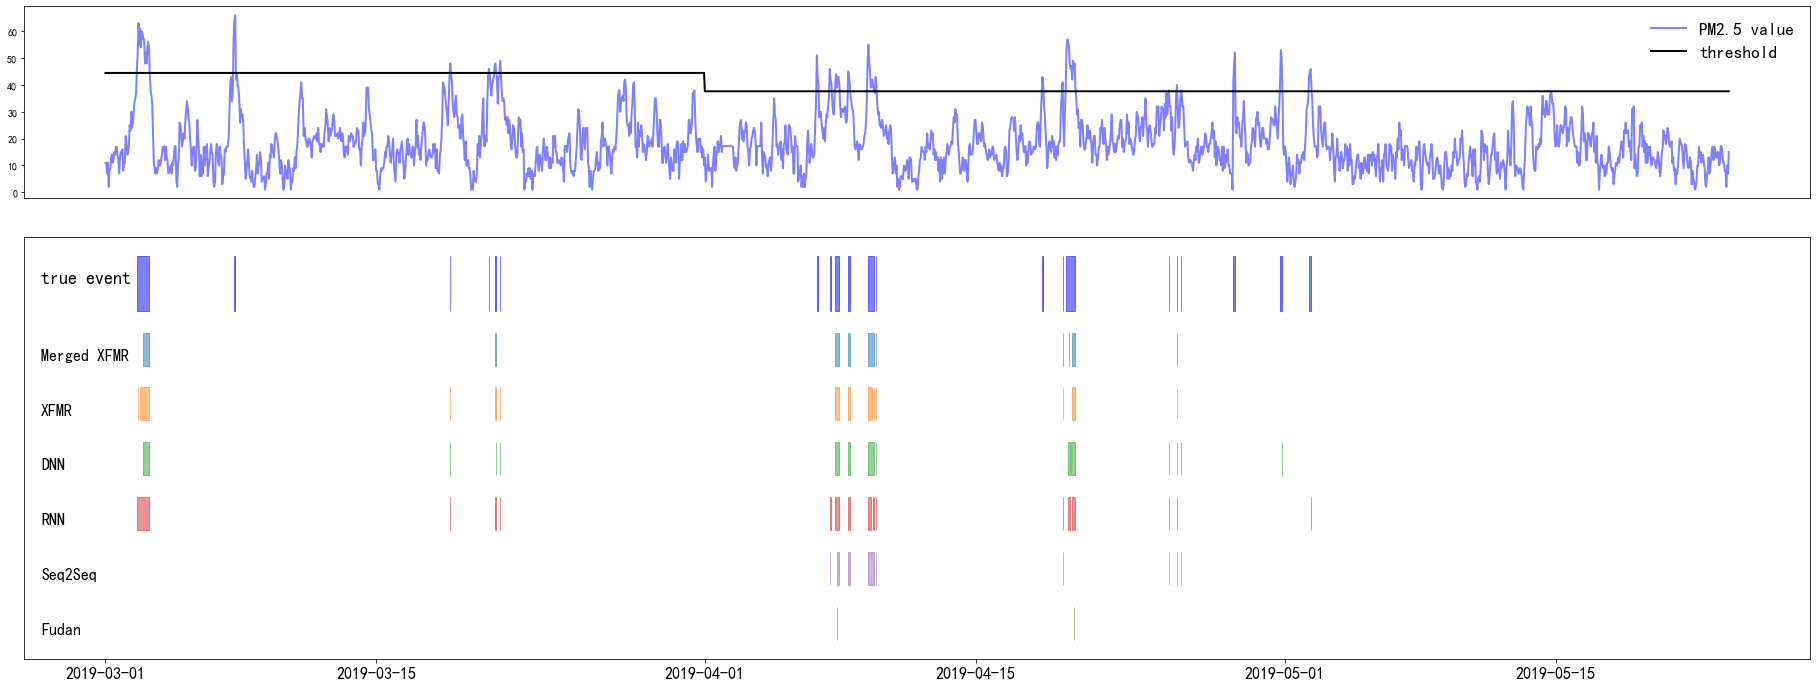

花蓮


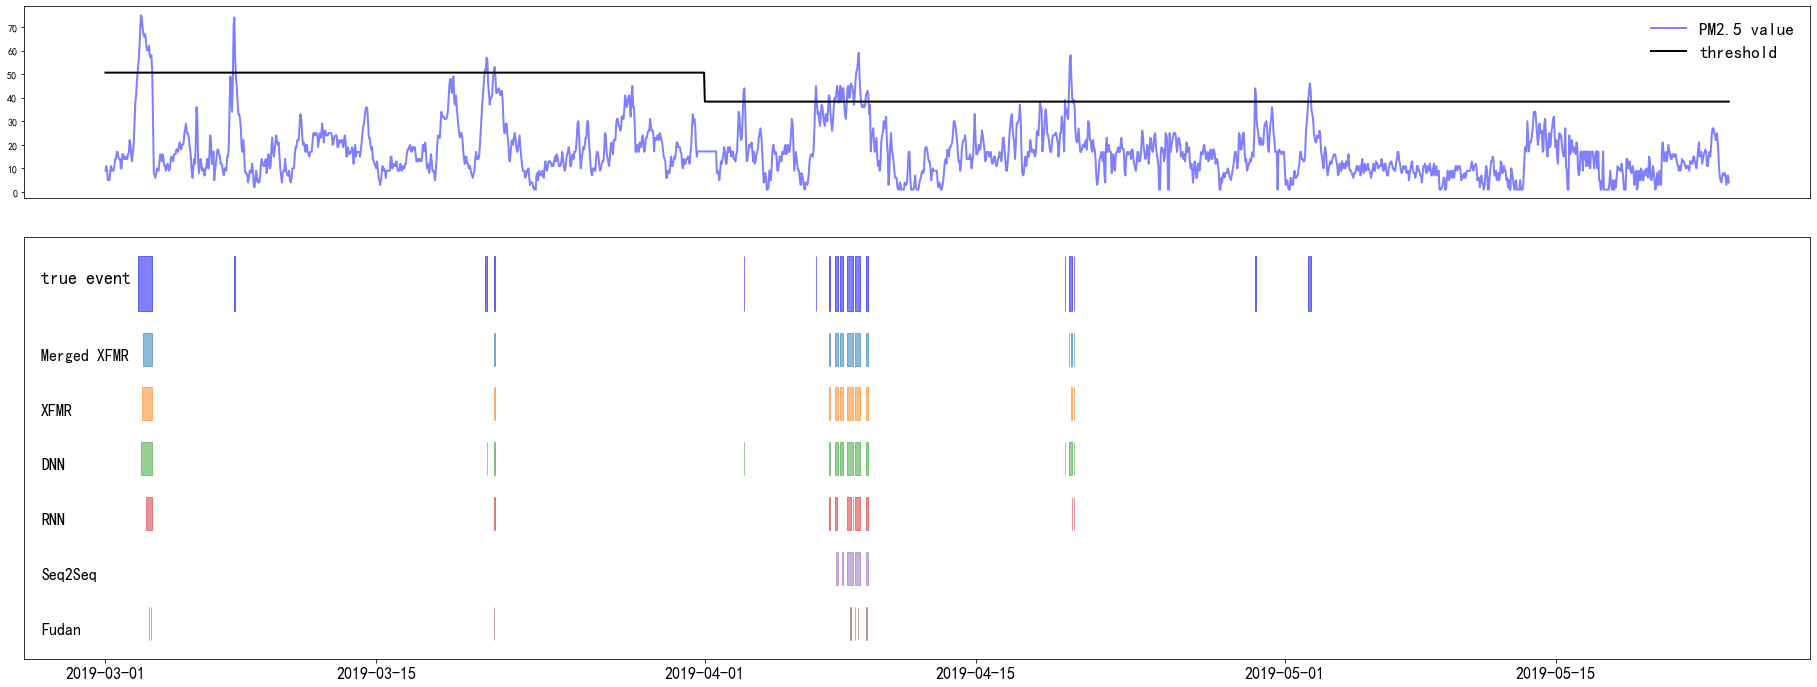

埔里


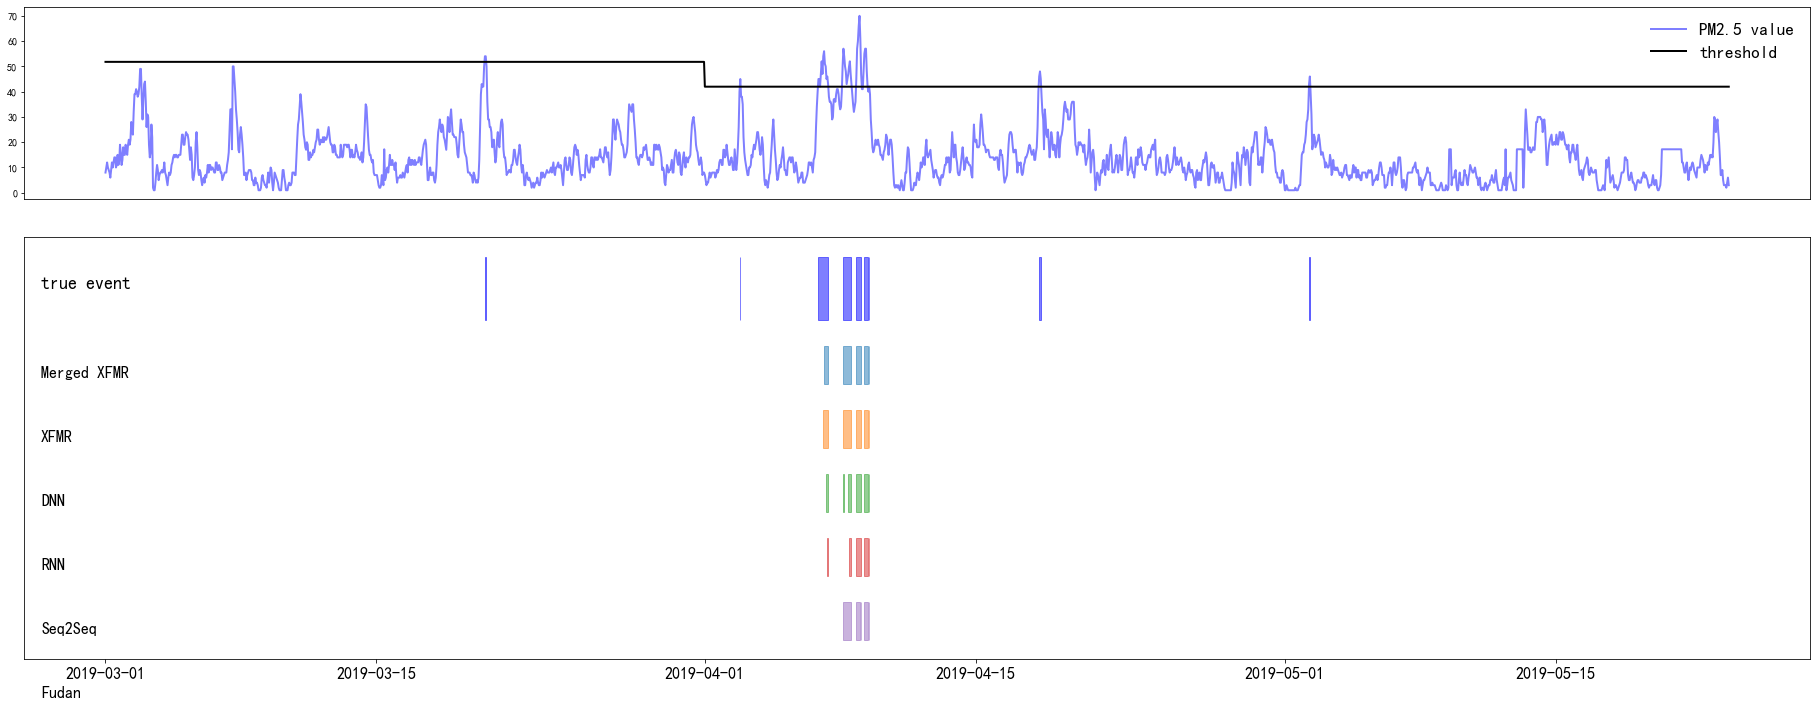

二林


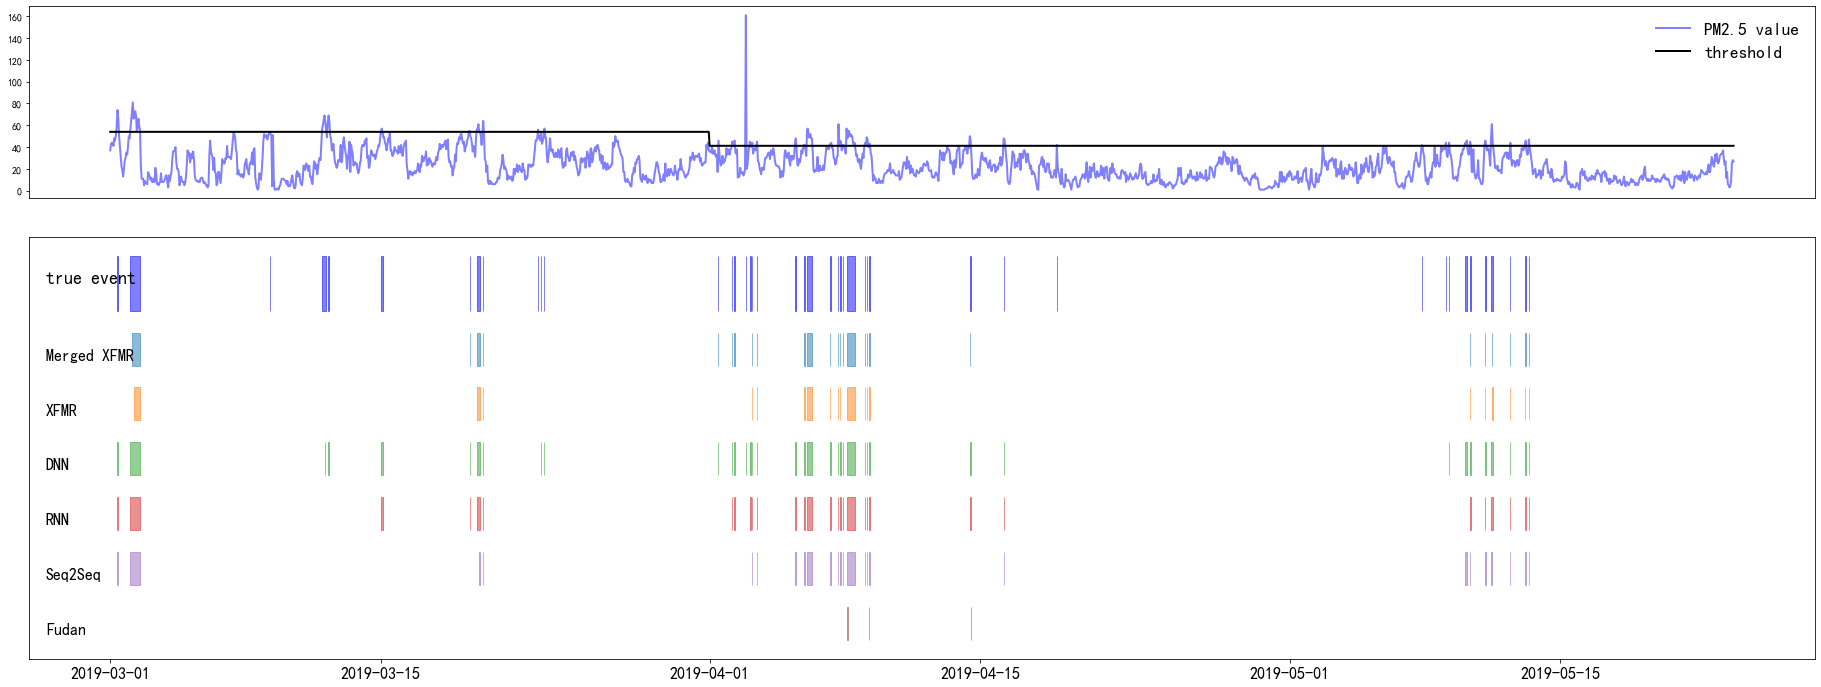

南投


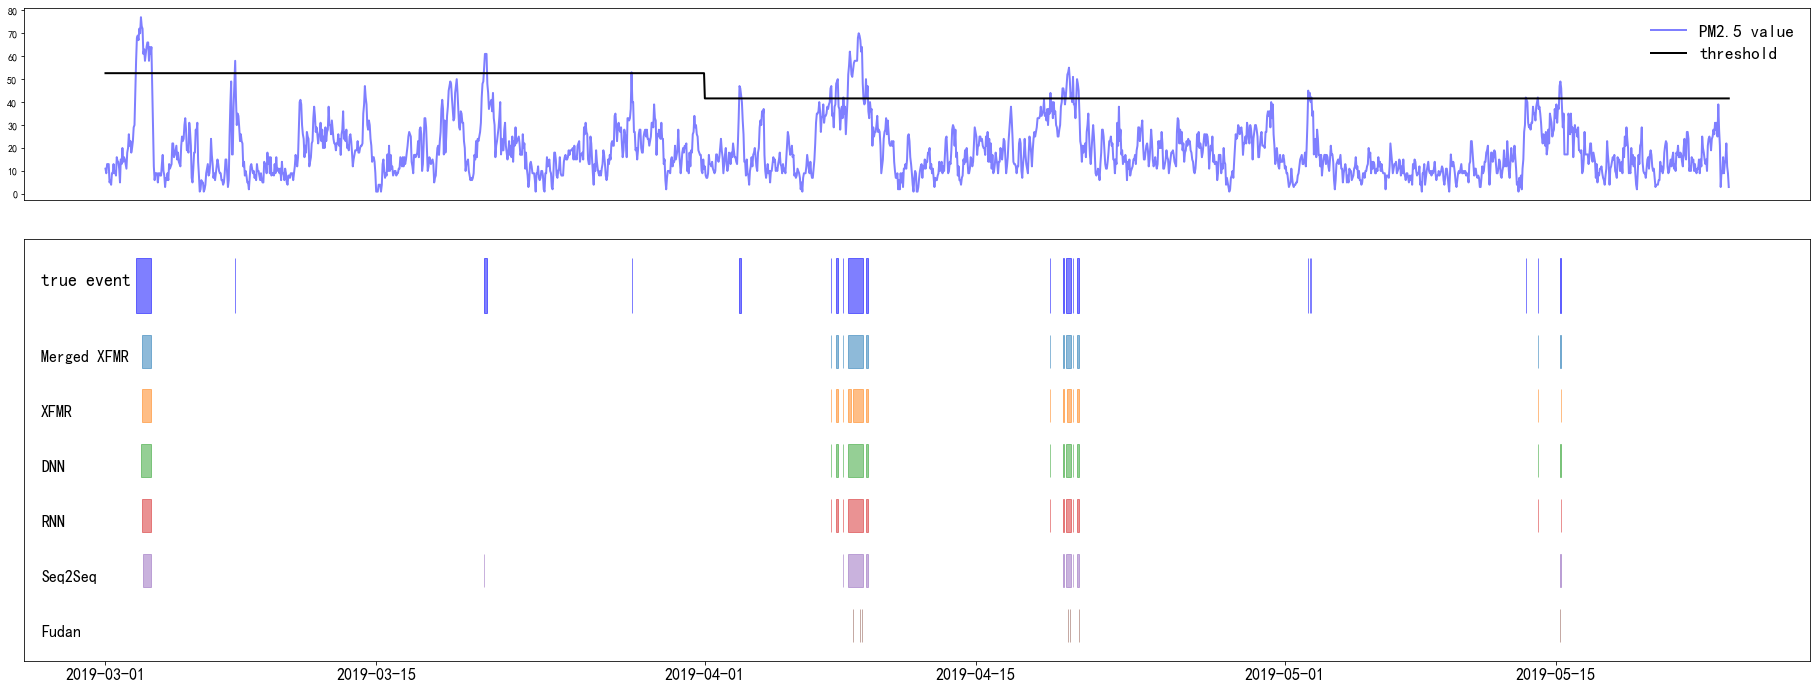

麥寮


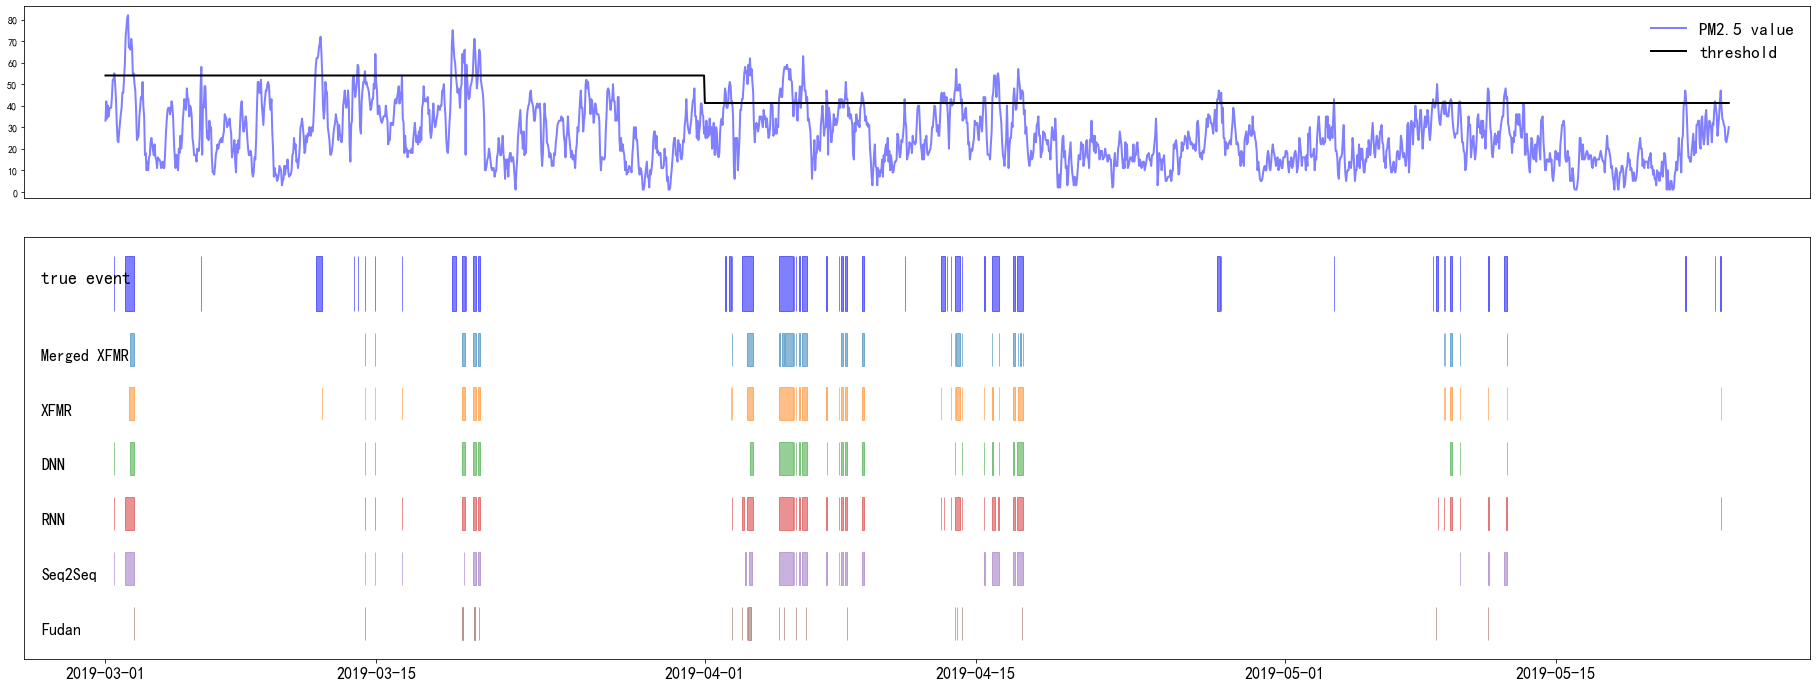

竹山


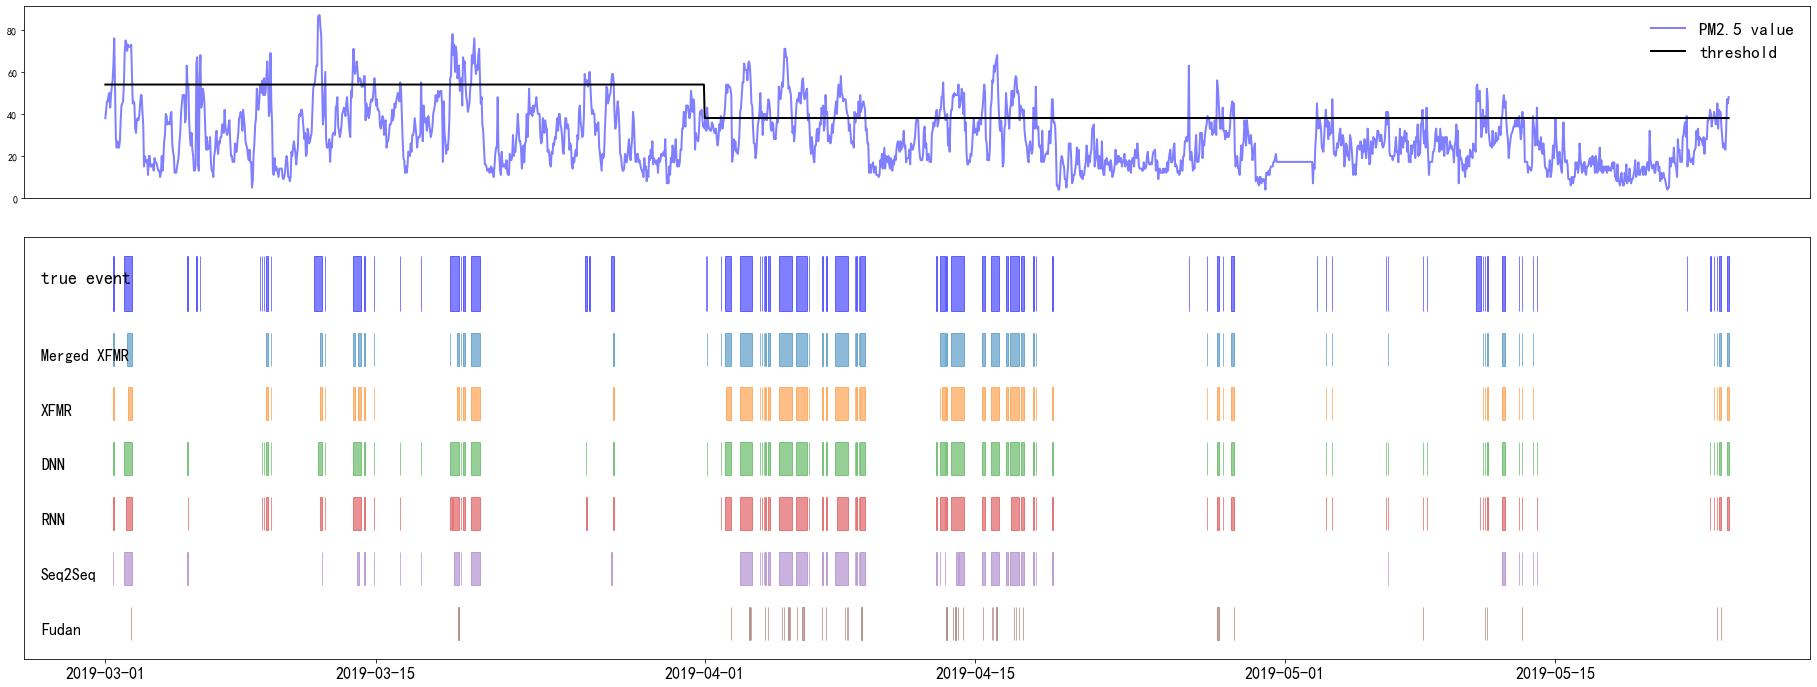

崙背


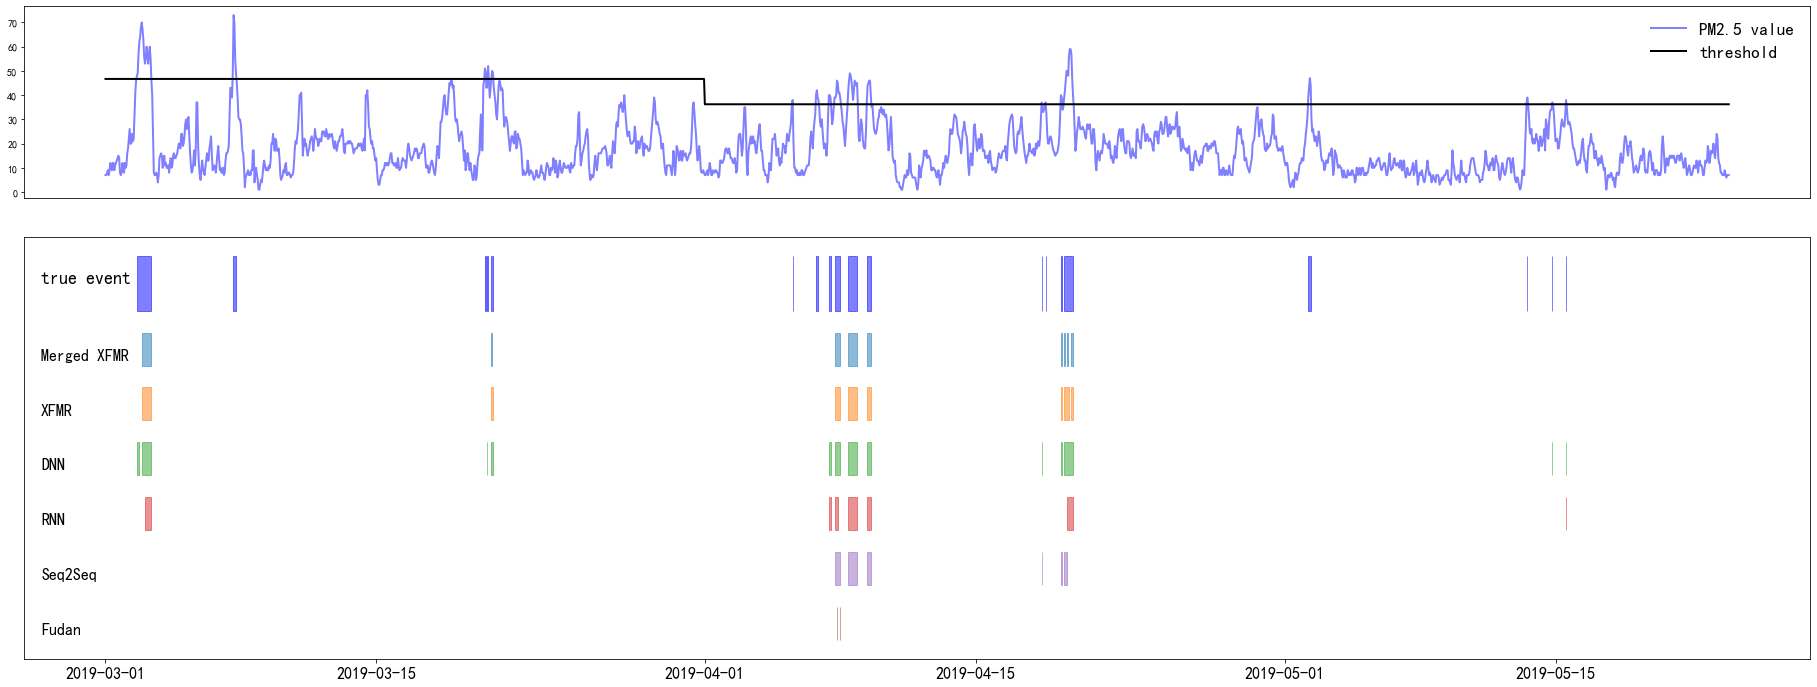

臺西


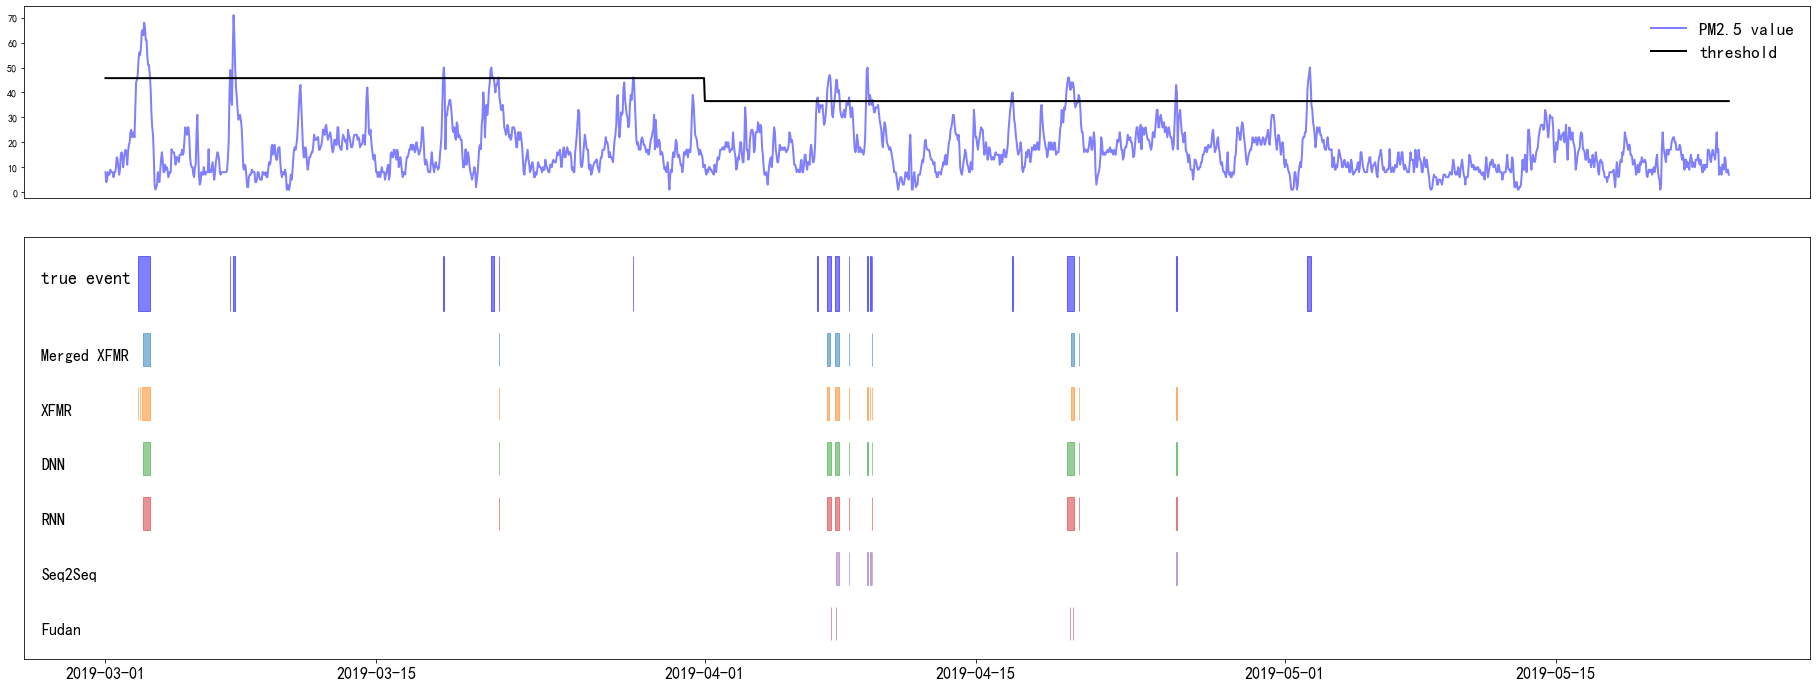

斗六


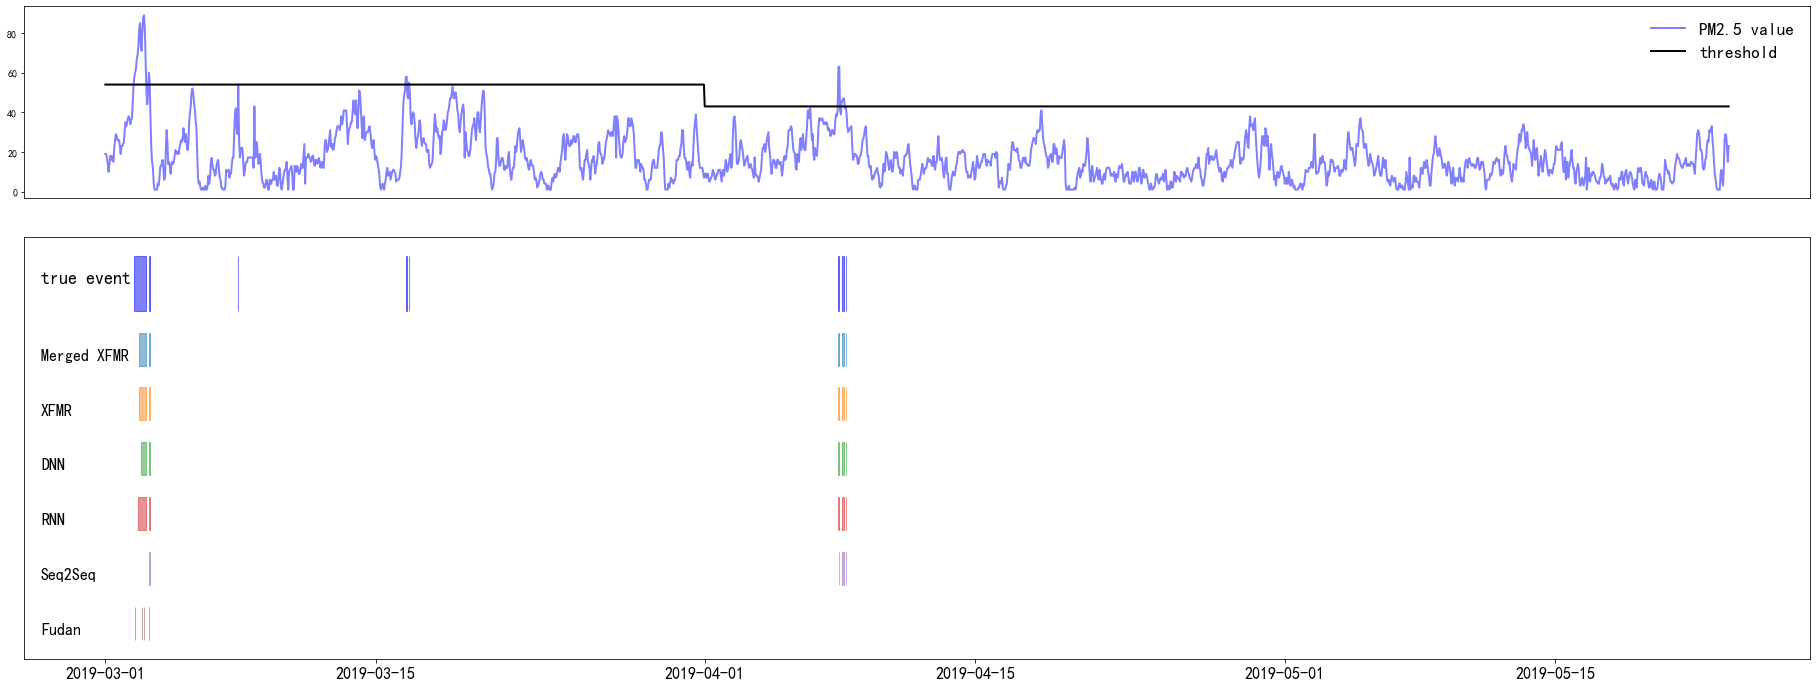

新港


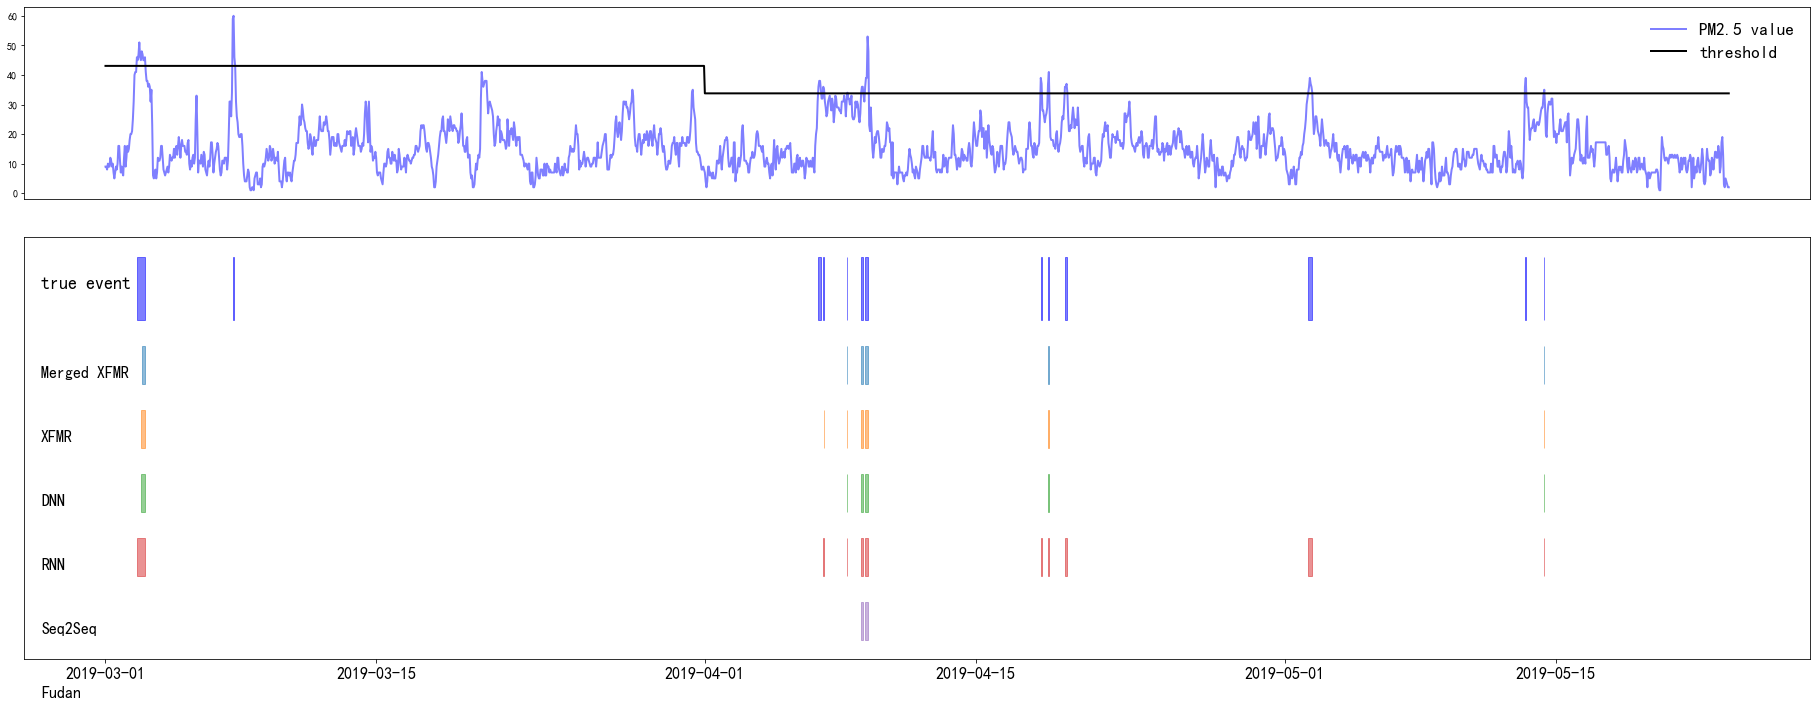

嘉義


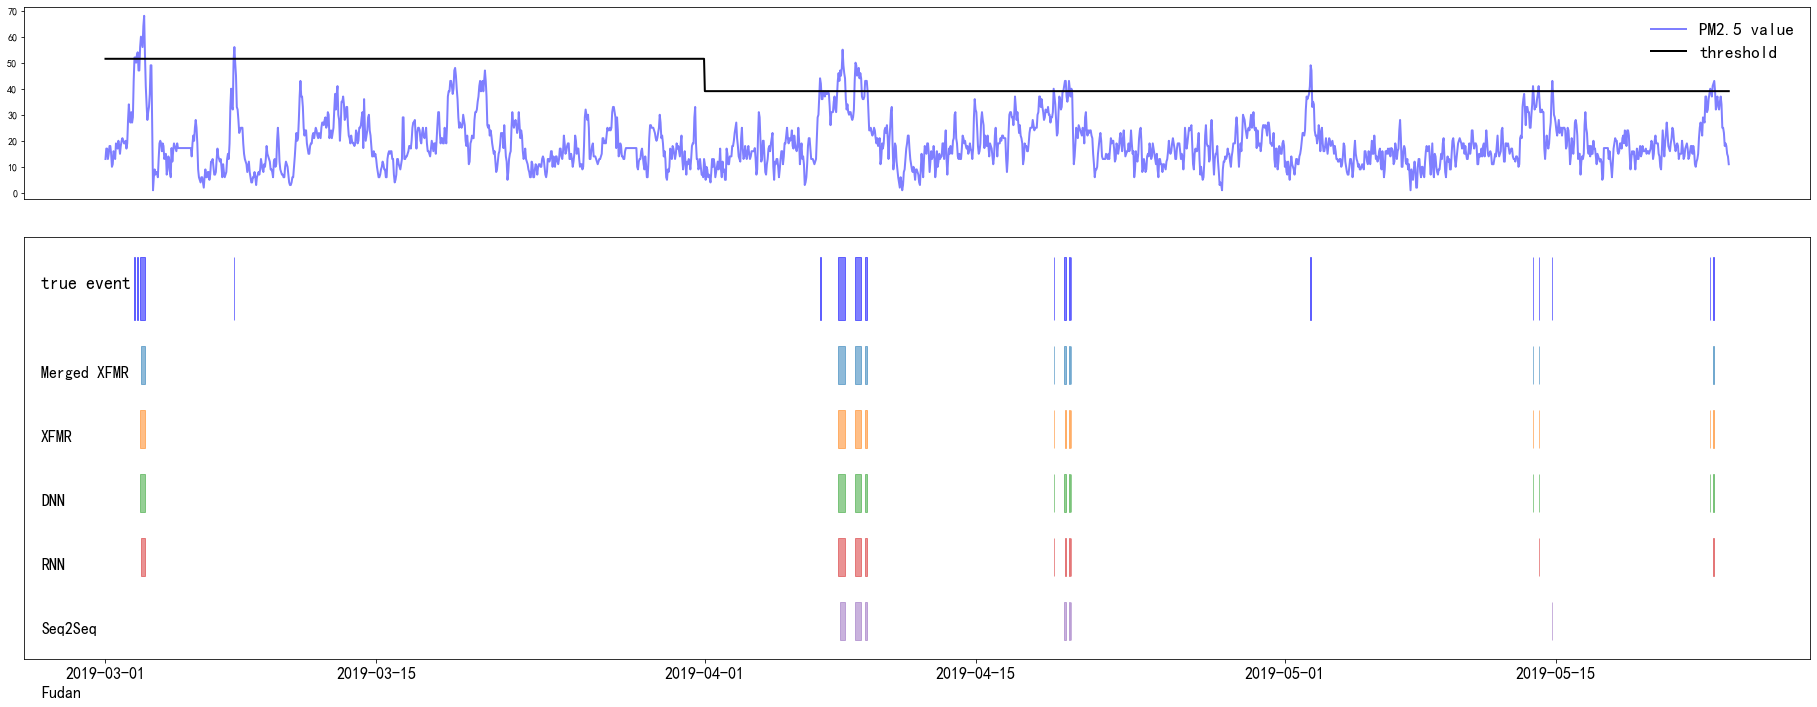

朴子


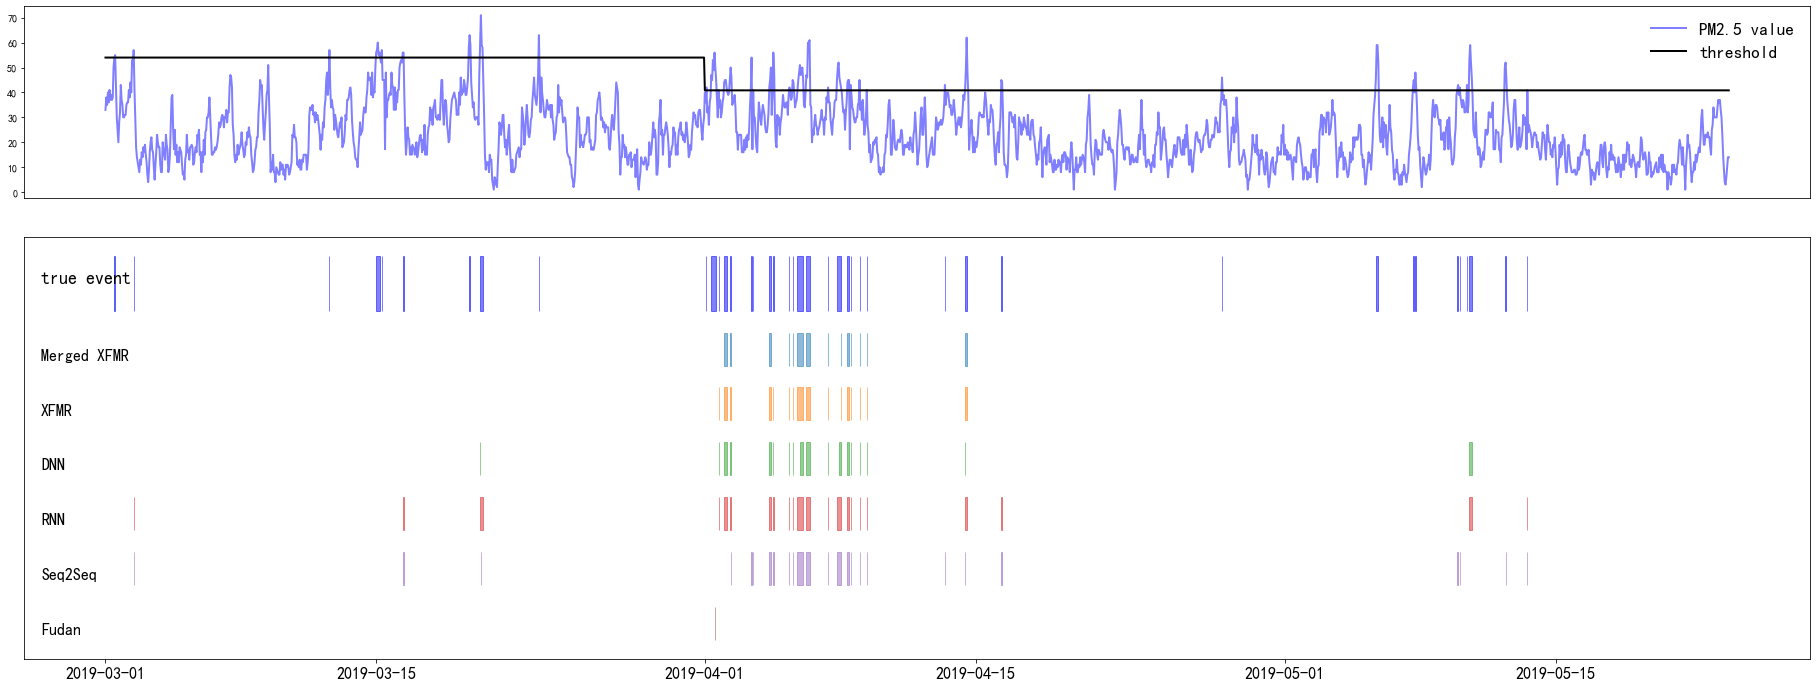

新營


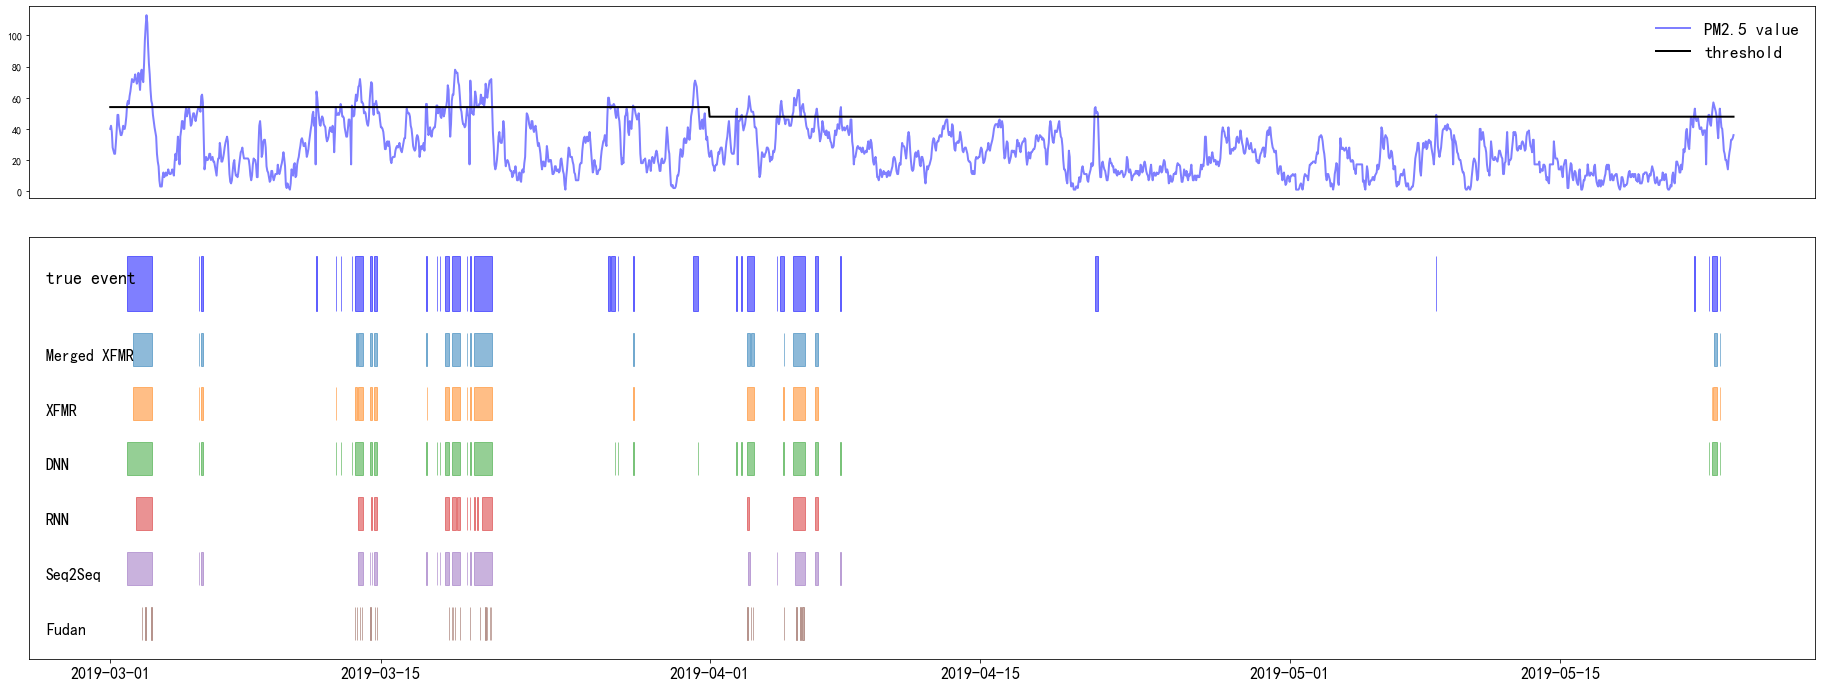

善化


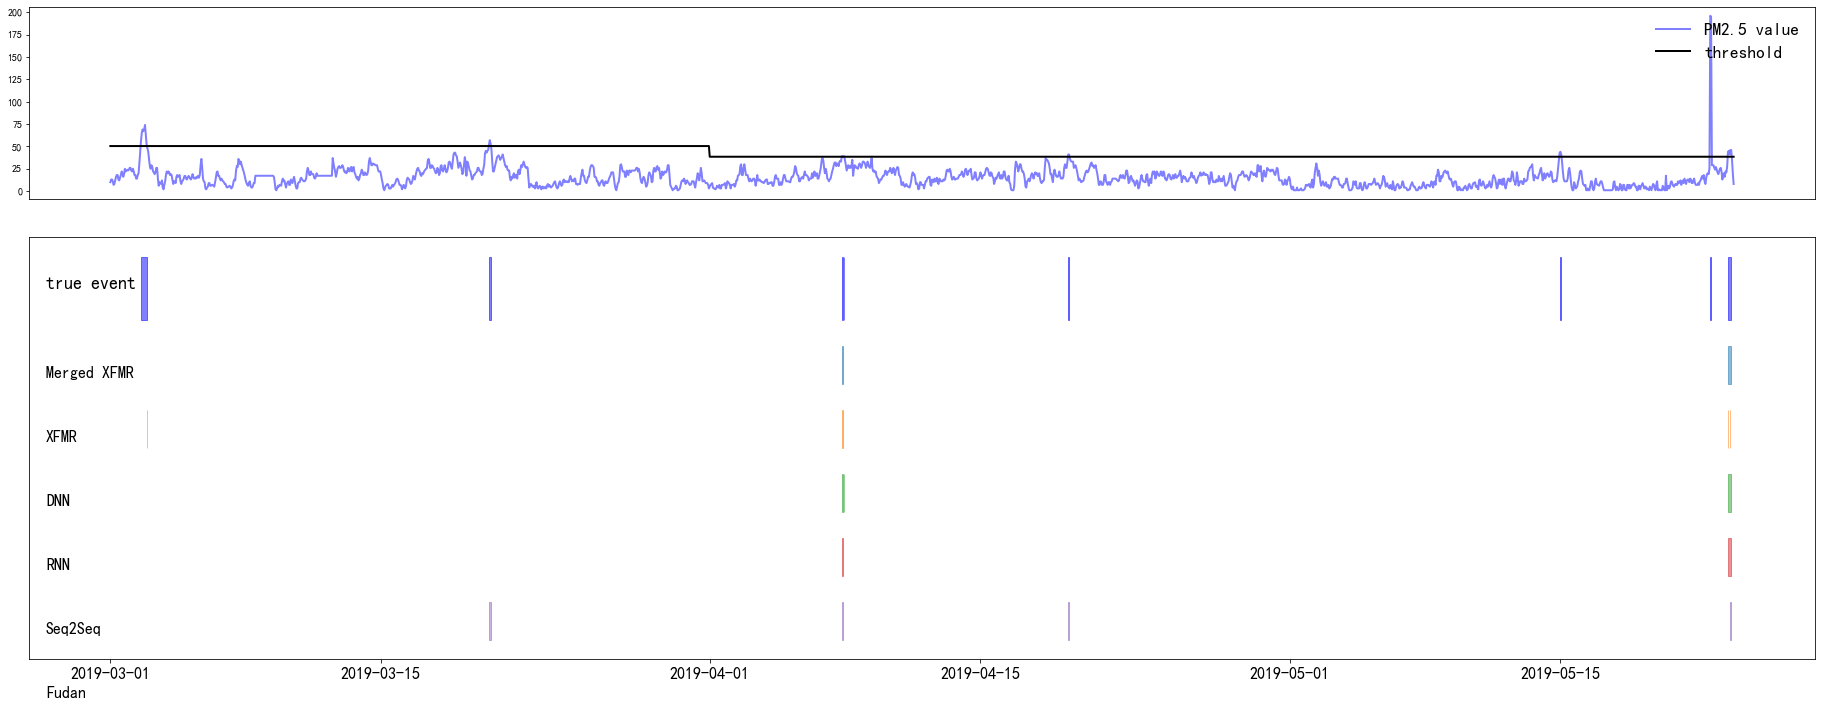

關山


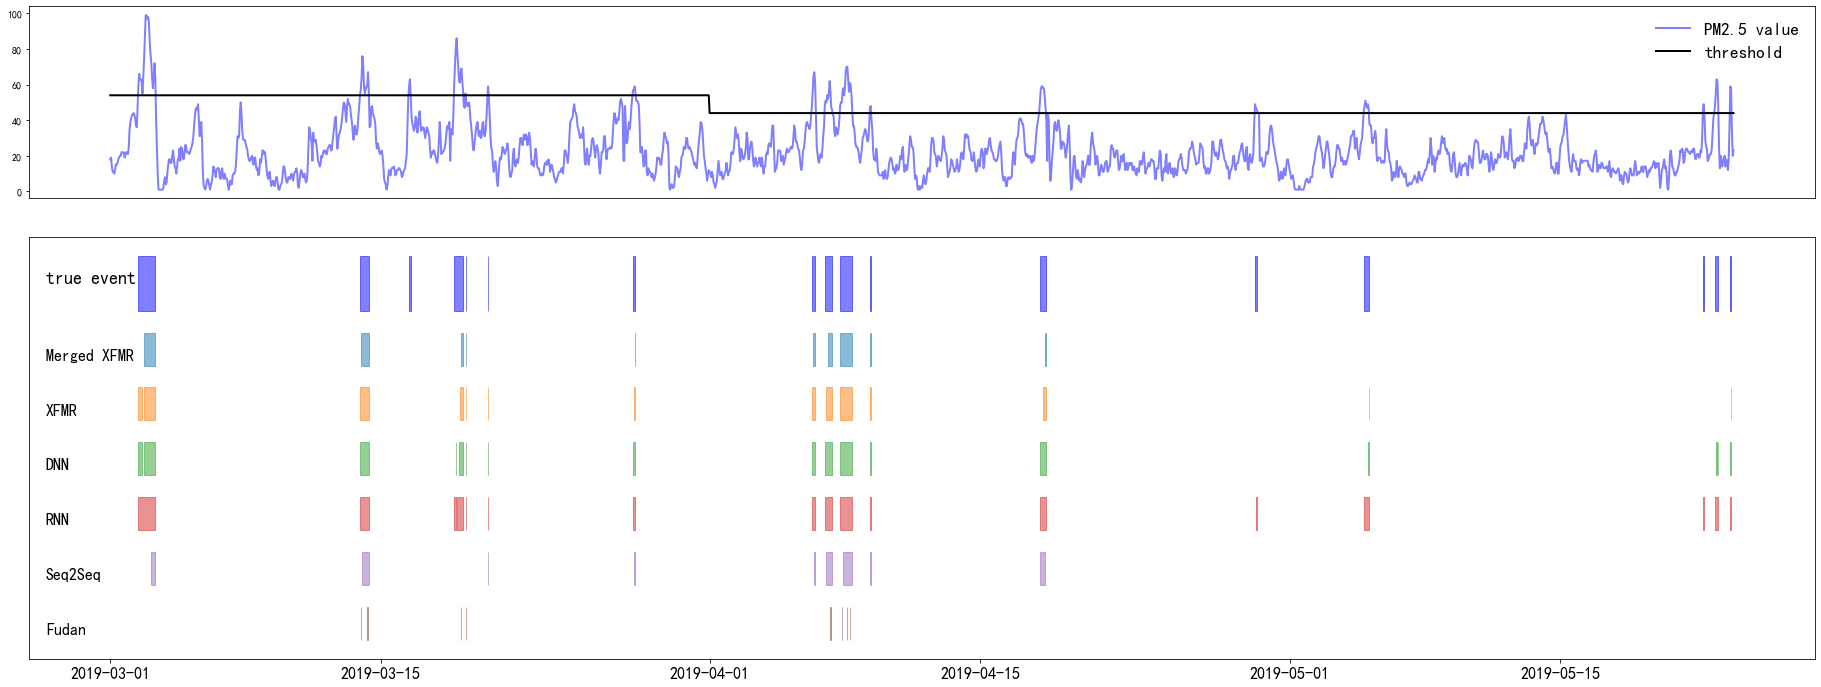

安南


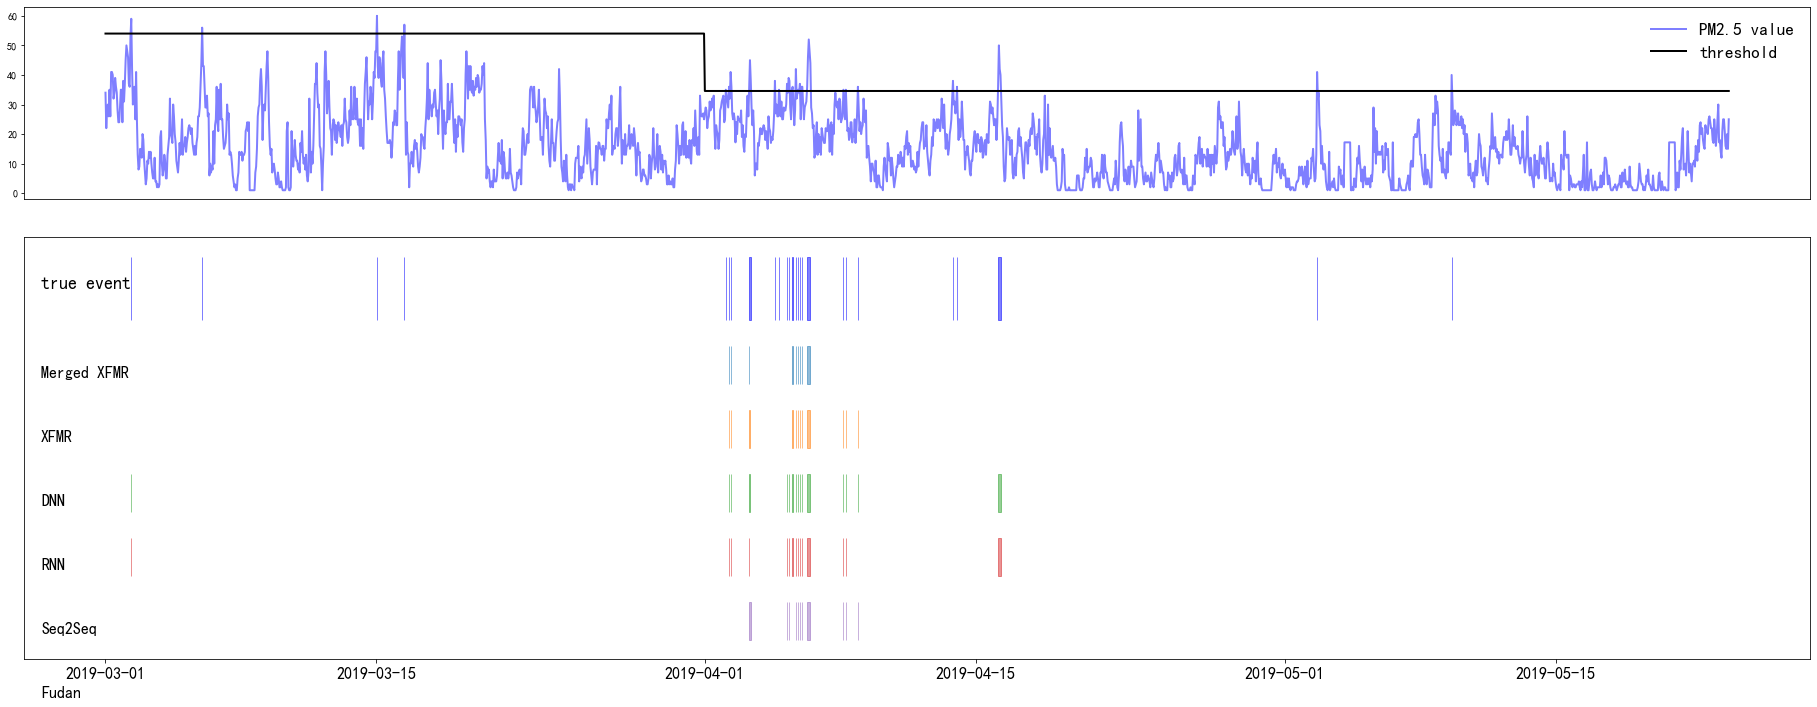

臺南


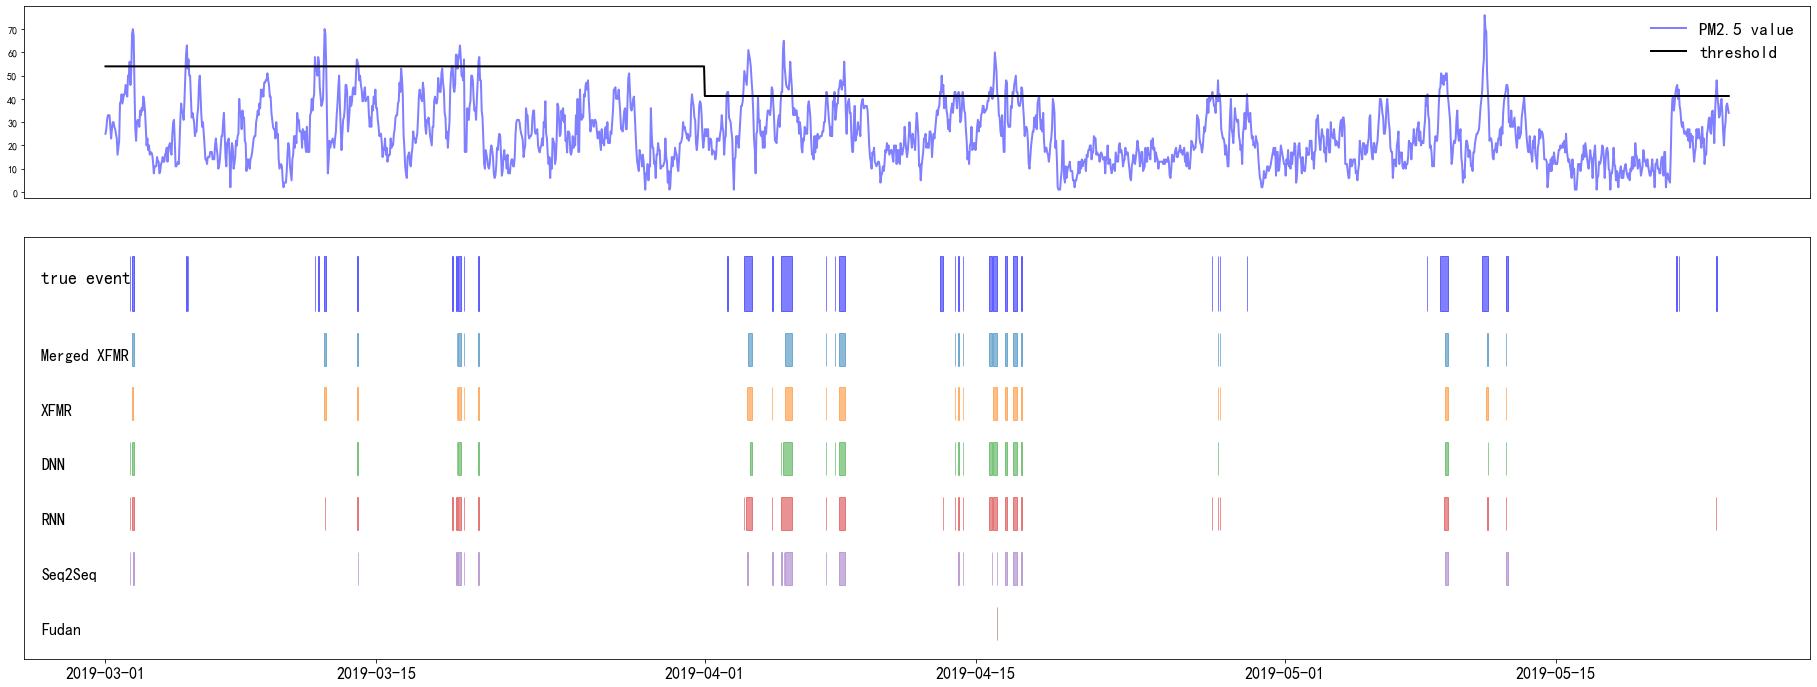

美濃


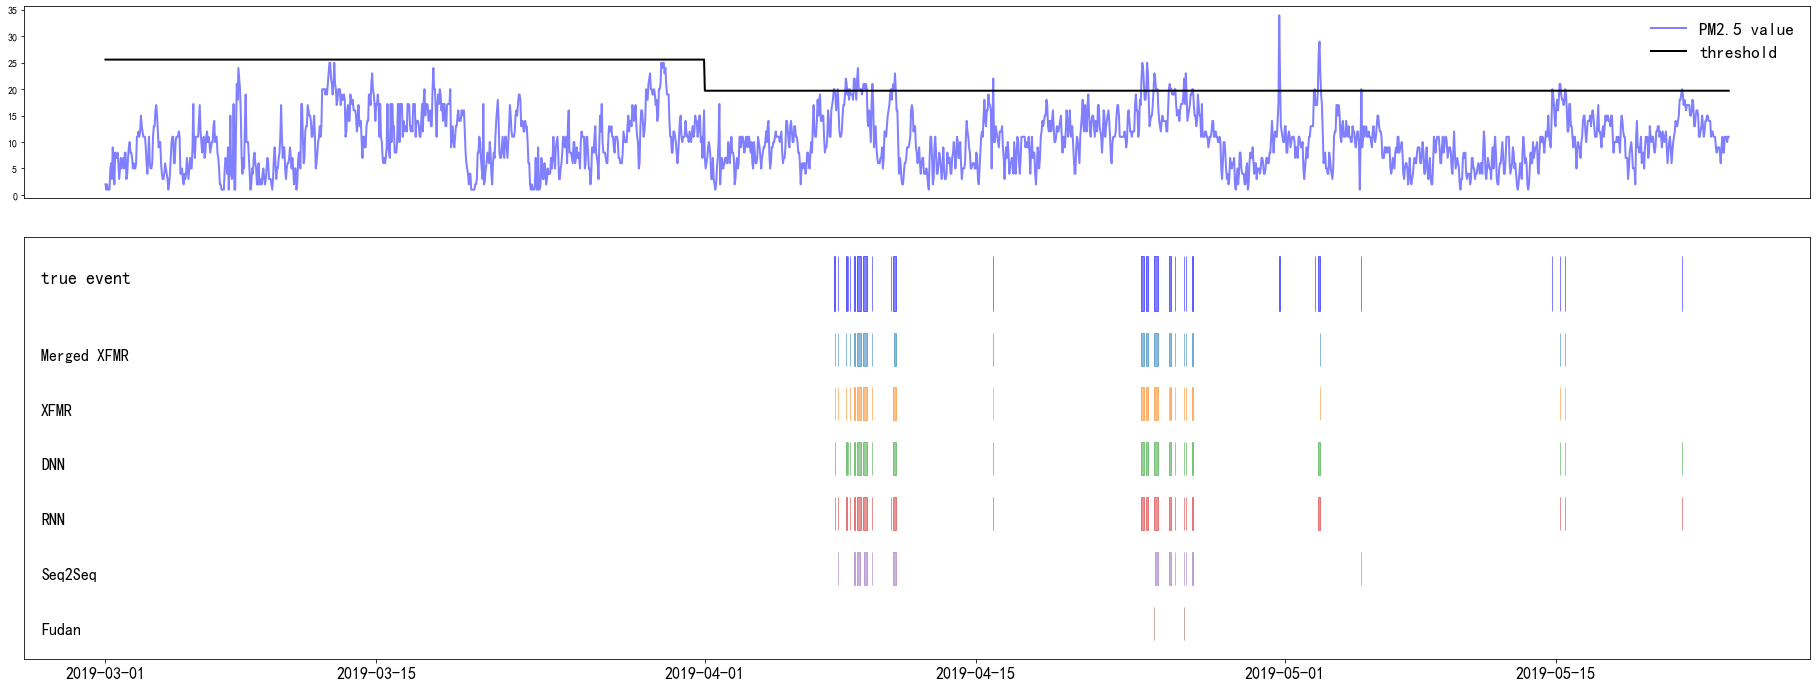

臺東


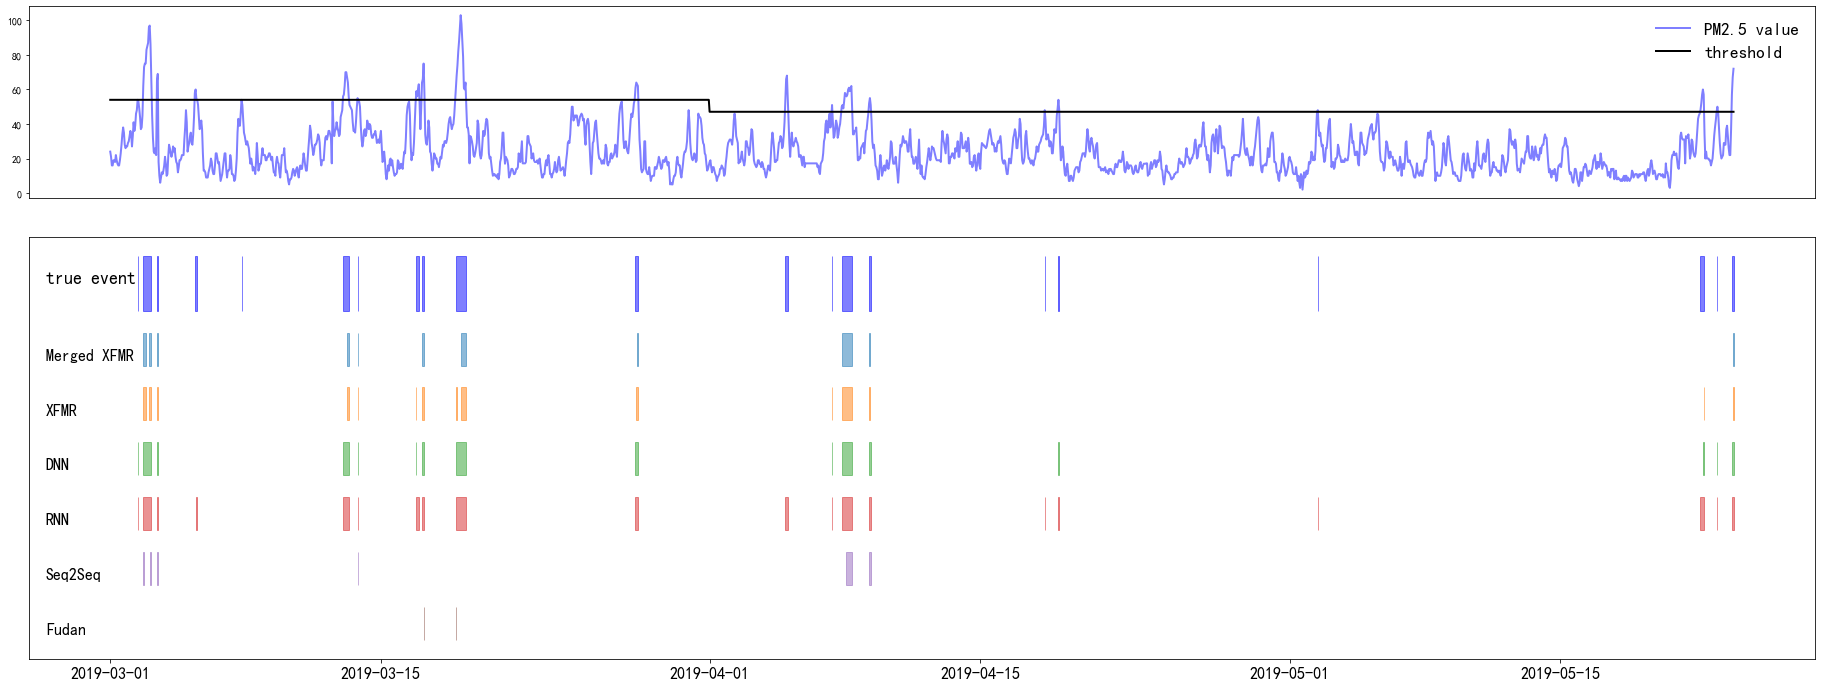

橋頭


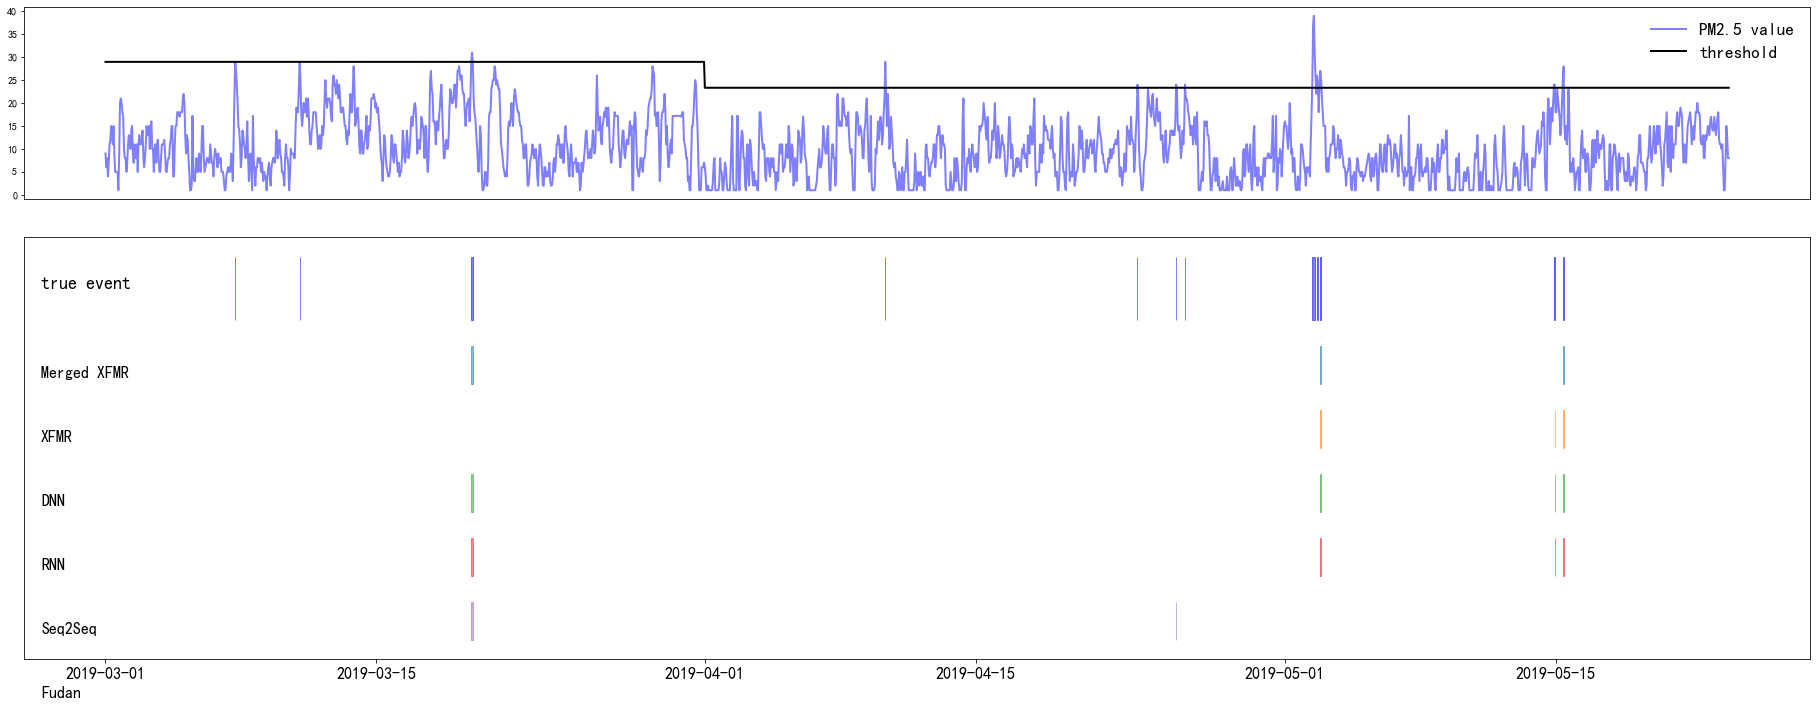

楠梓


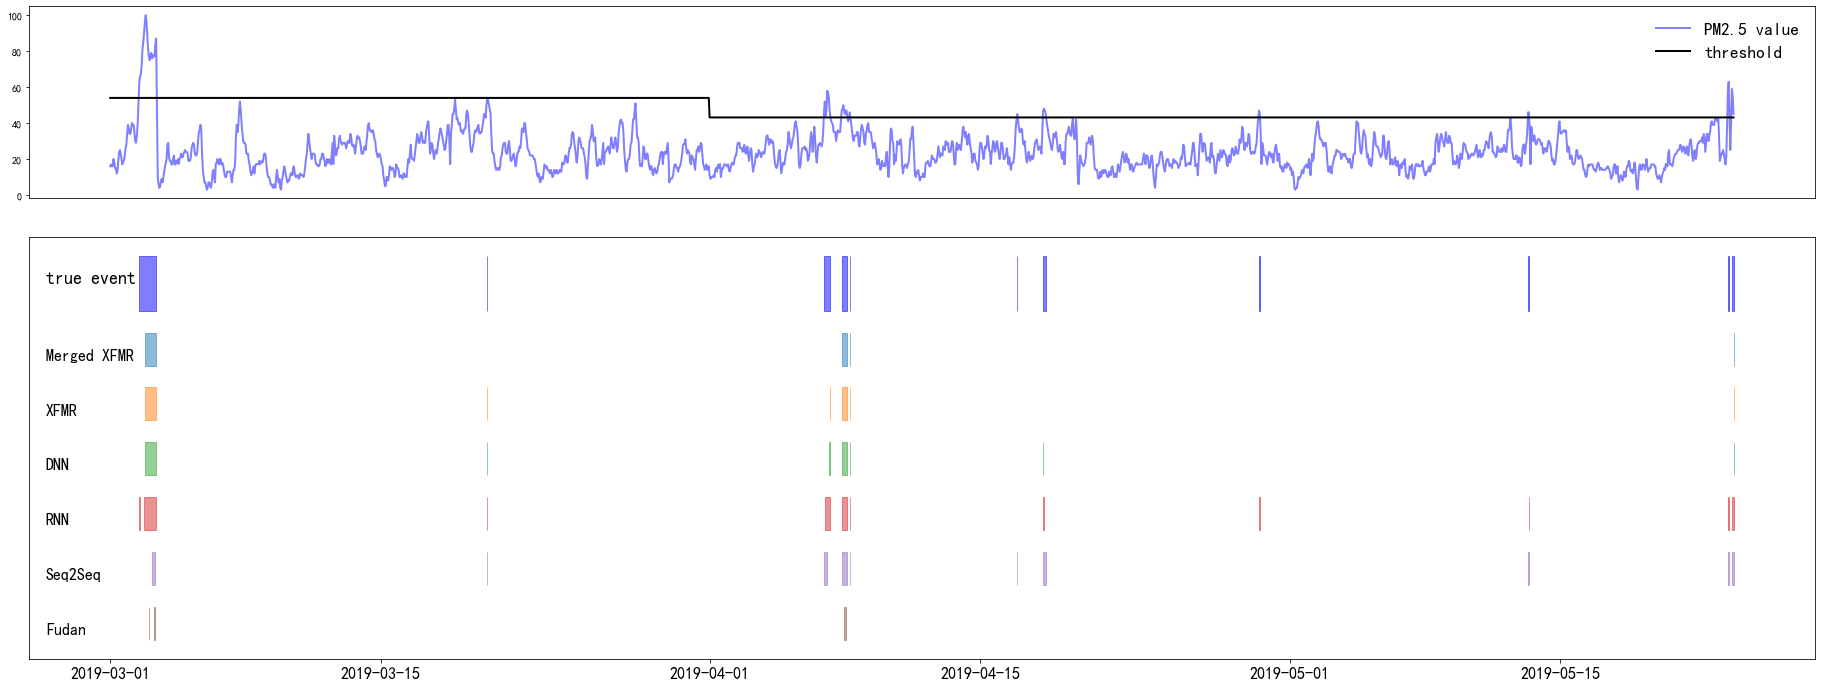

仁武


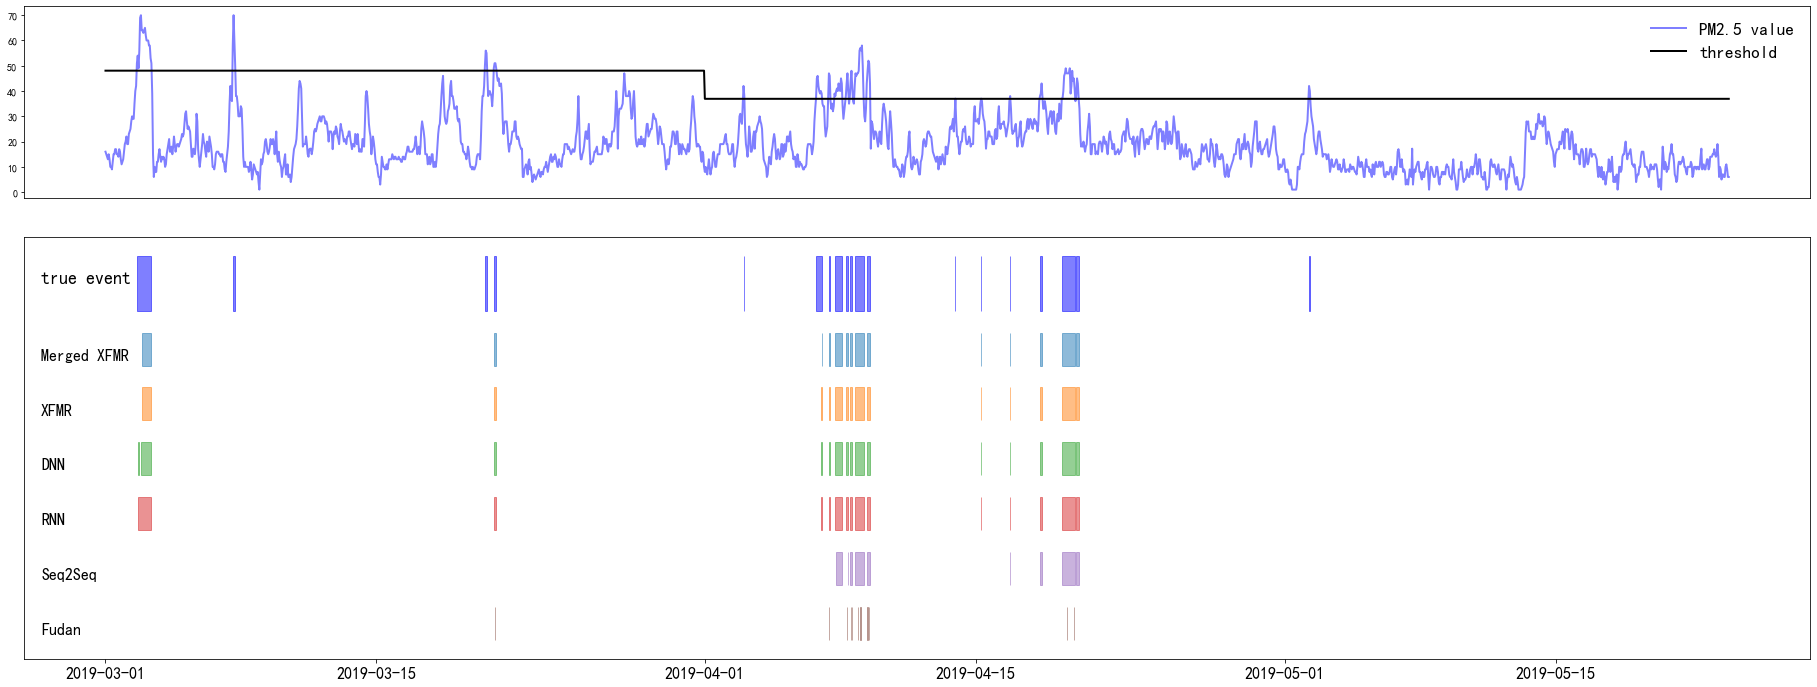

屏東


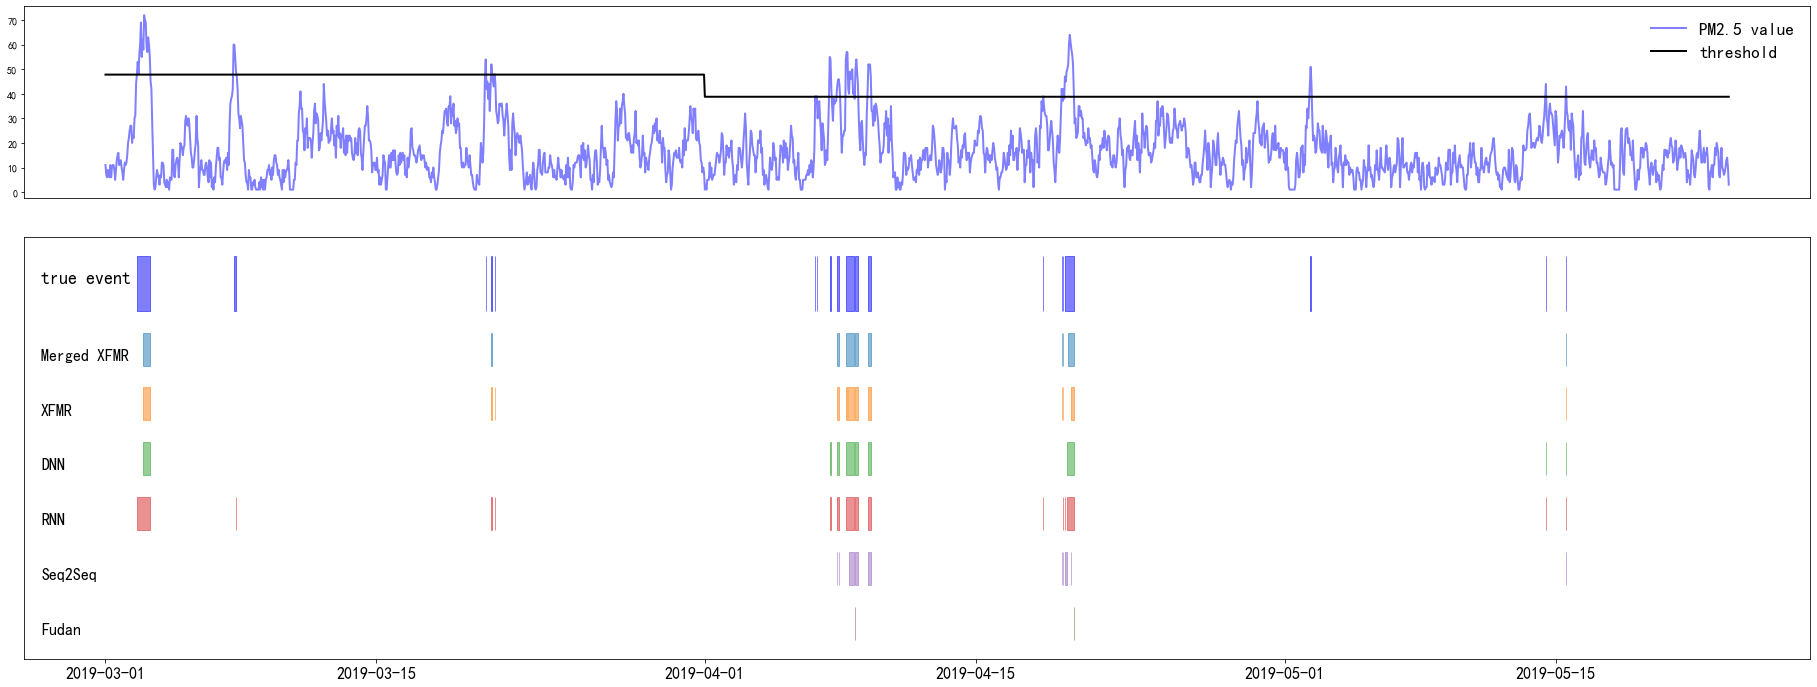

左營


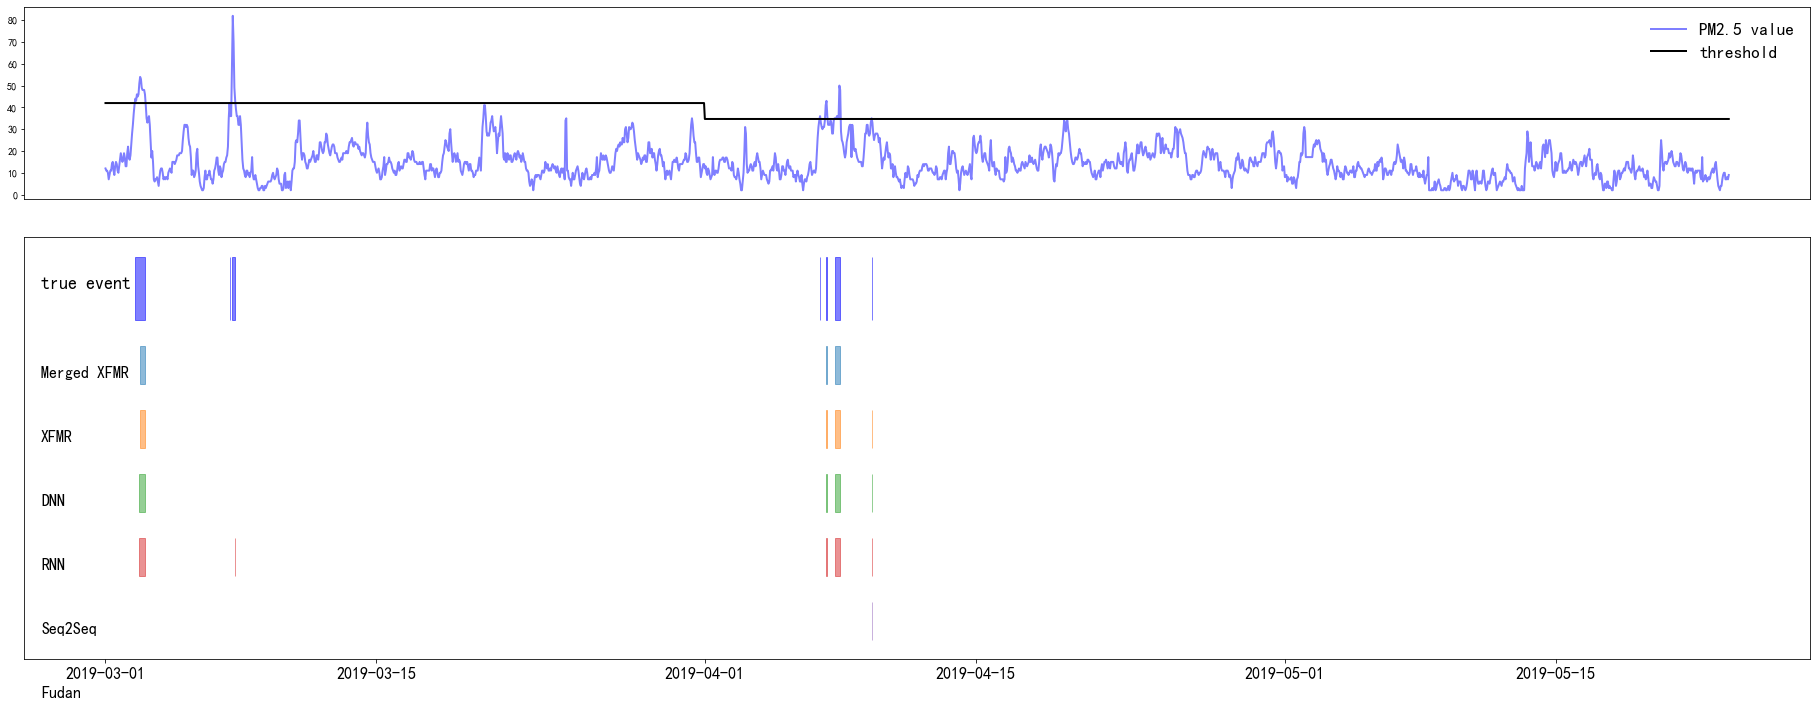

前金


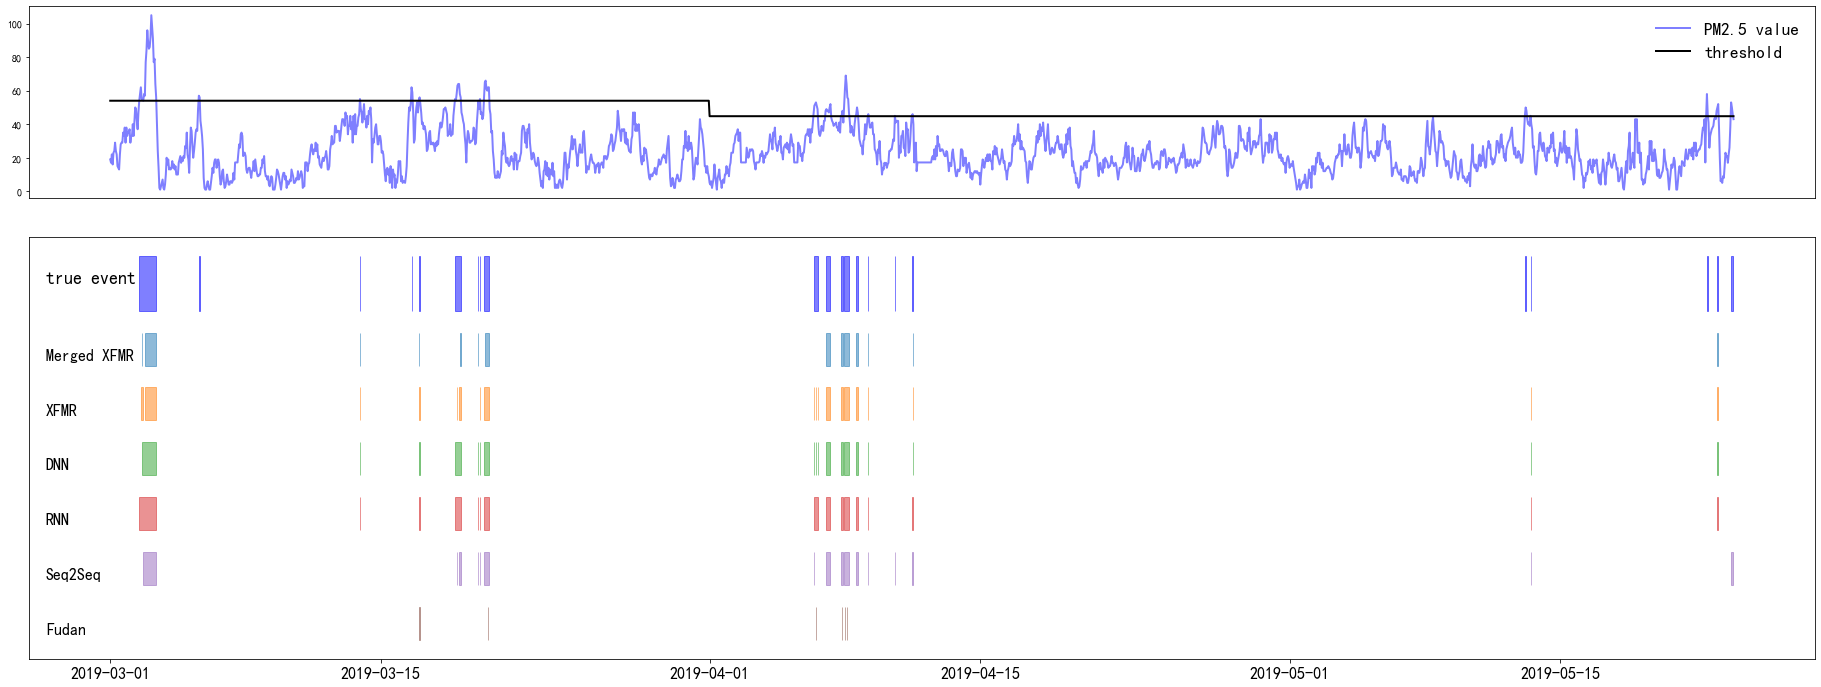

鳳山


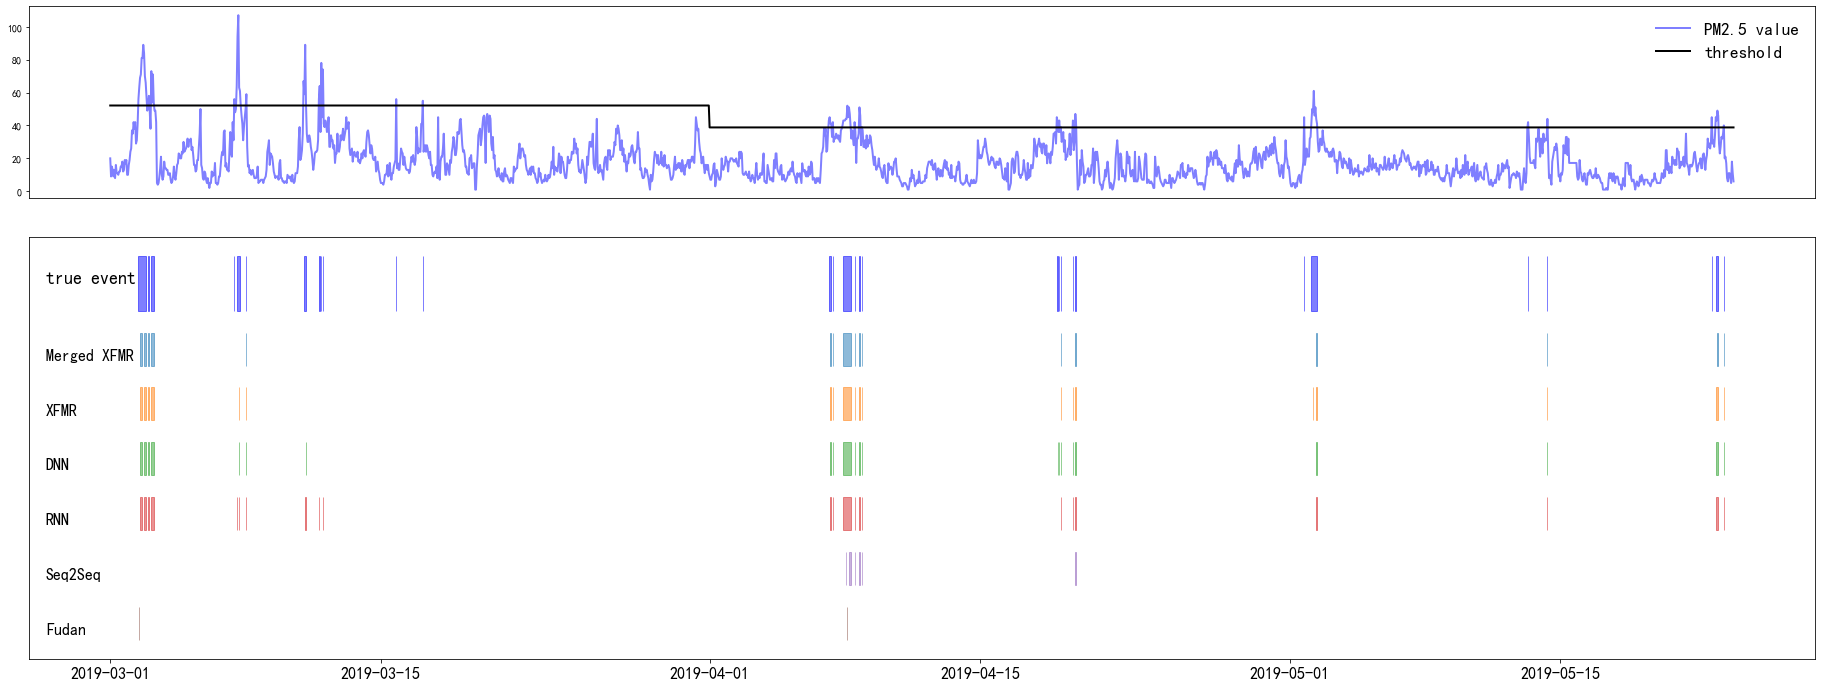

前鎮


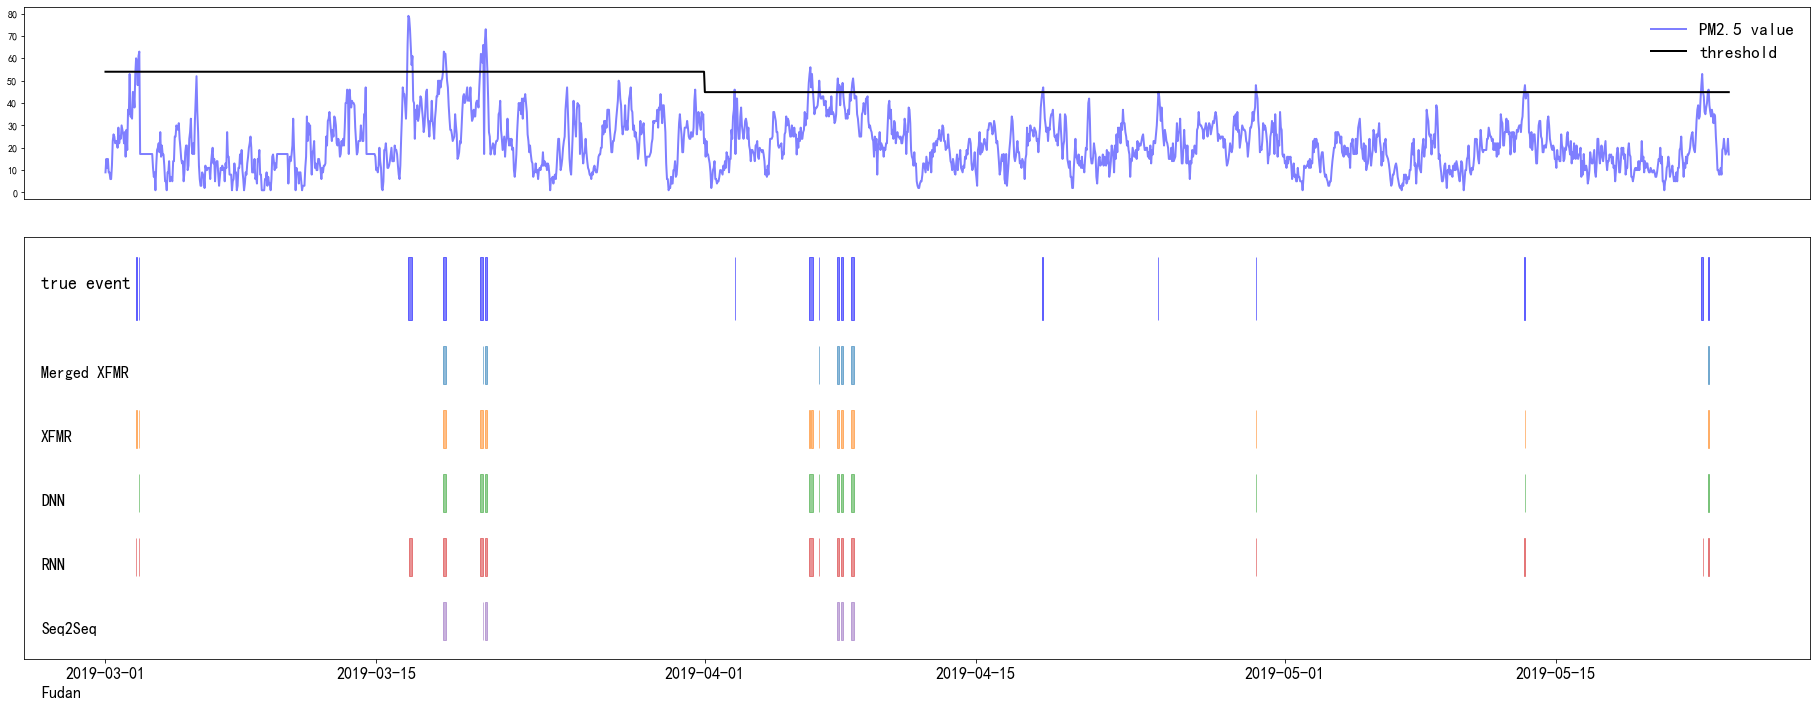

復興


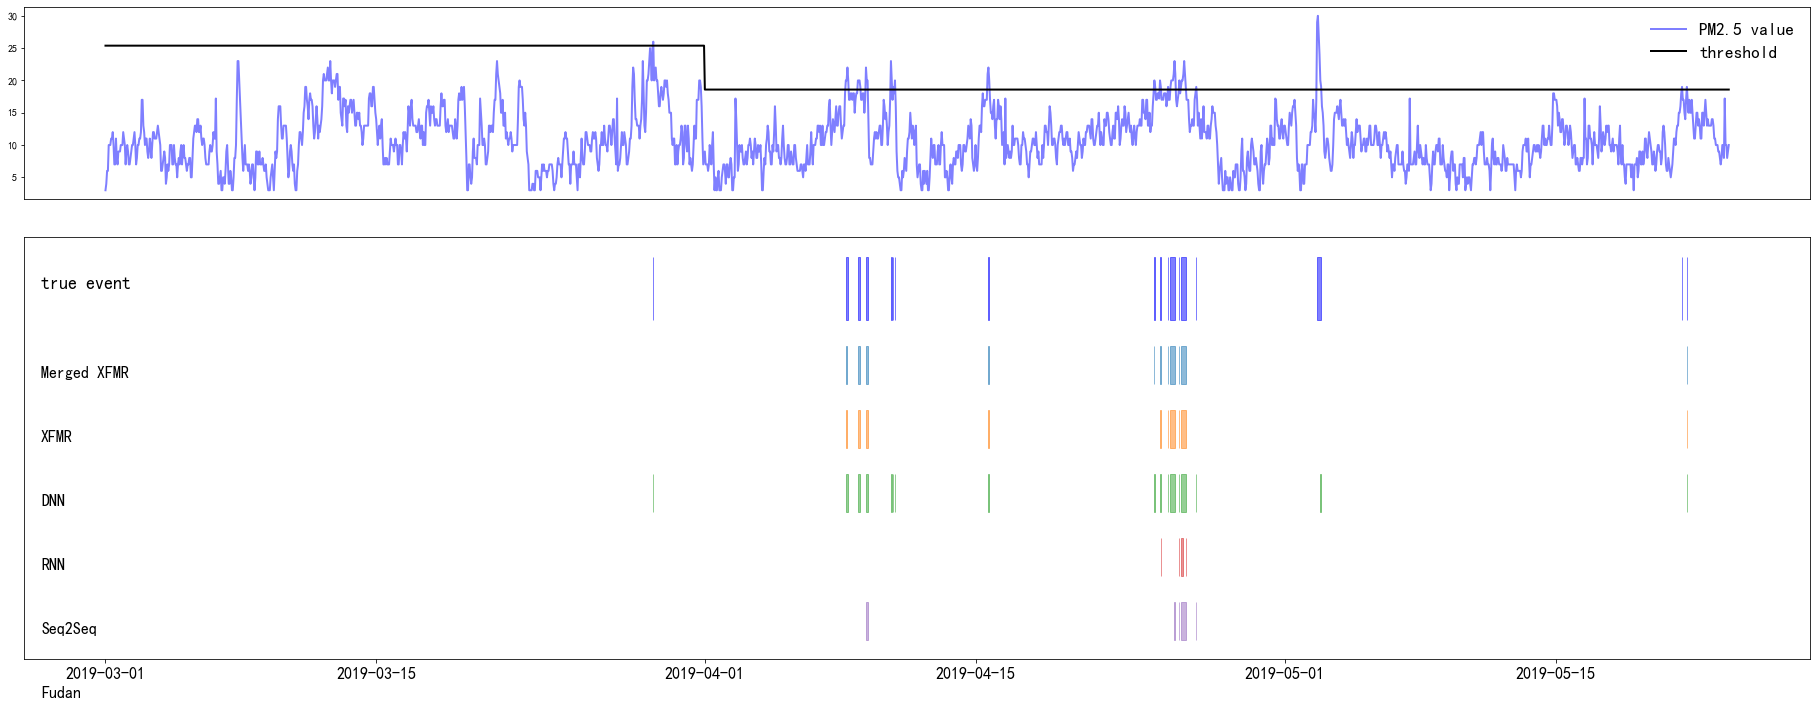

小港


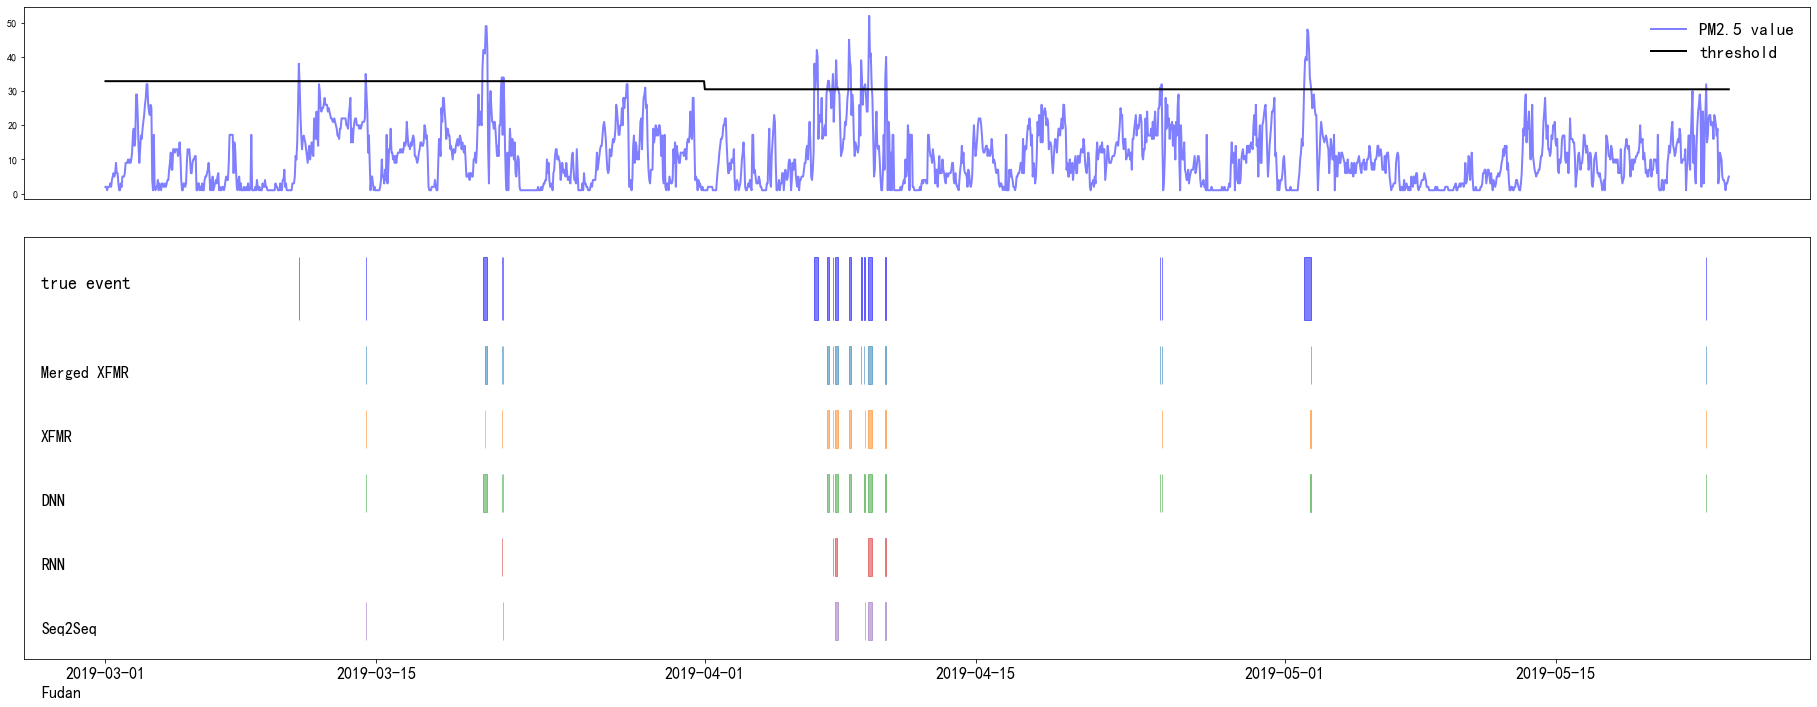

大寮


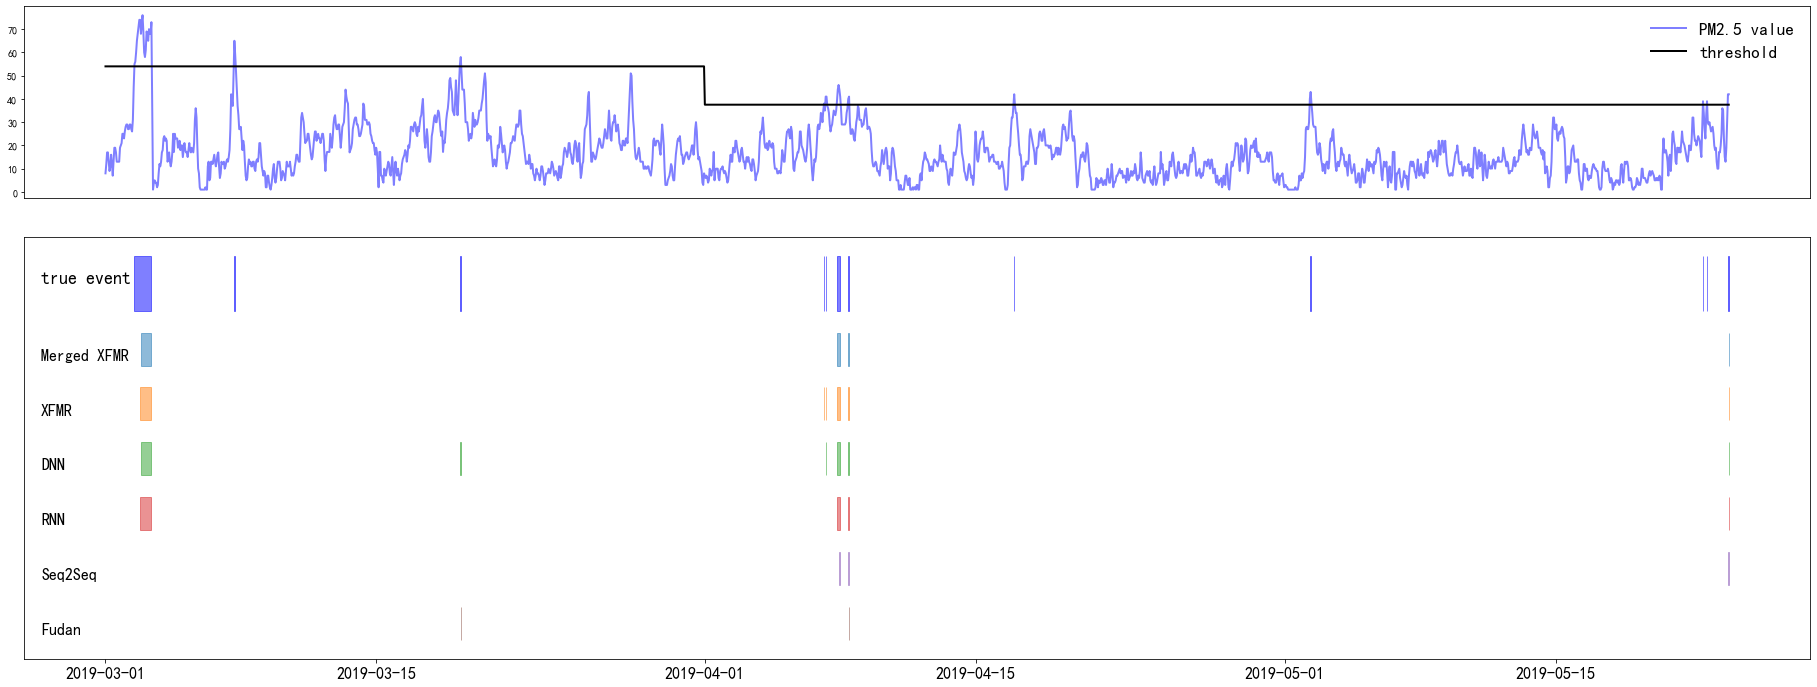

潮州


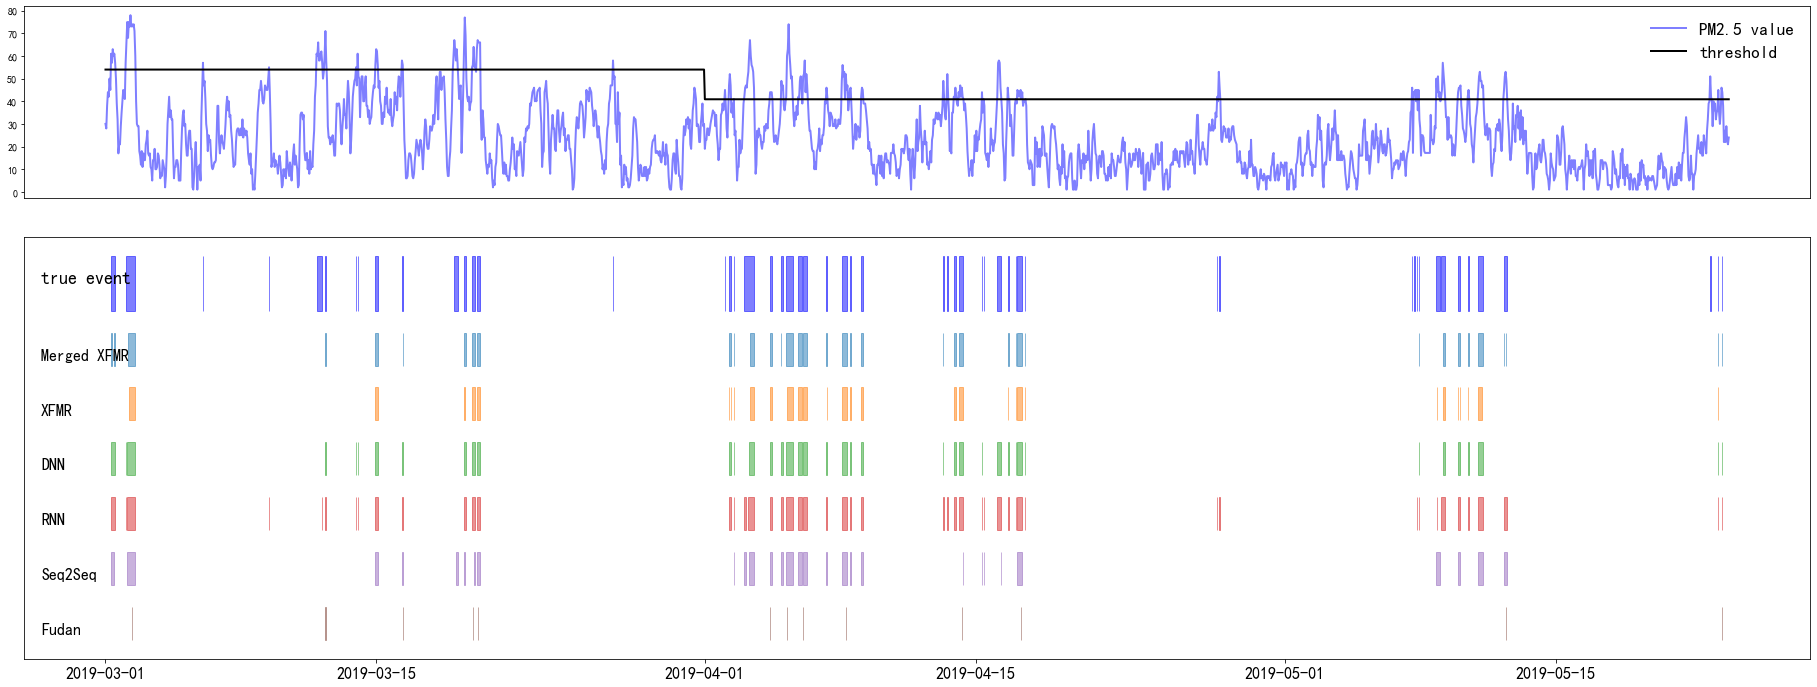

林園


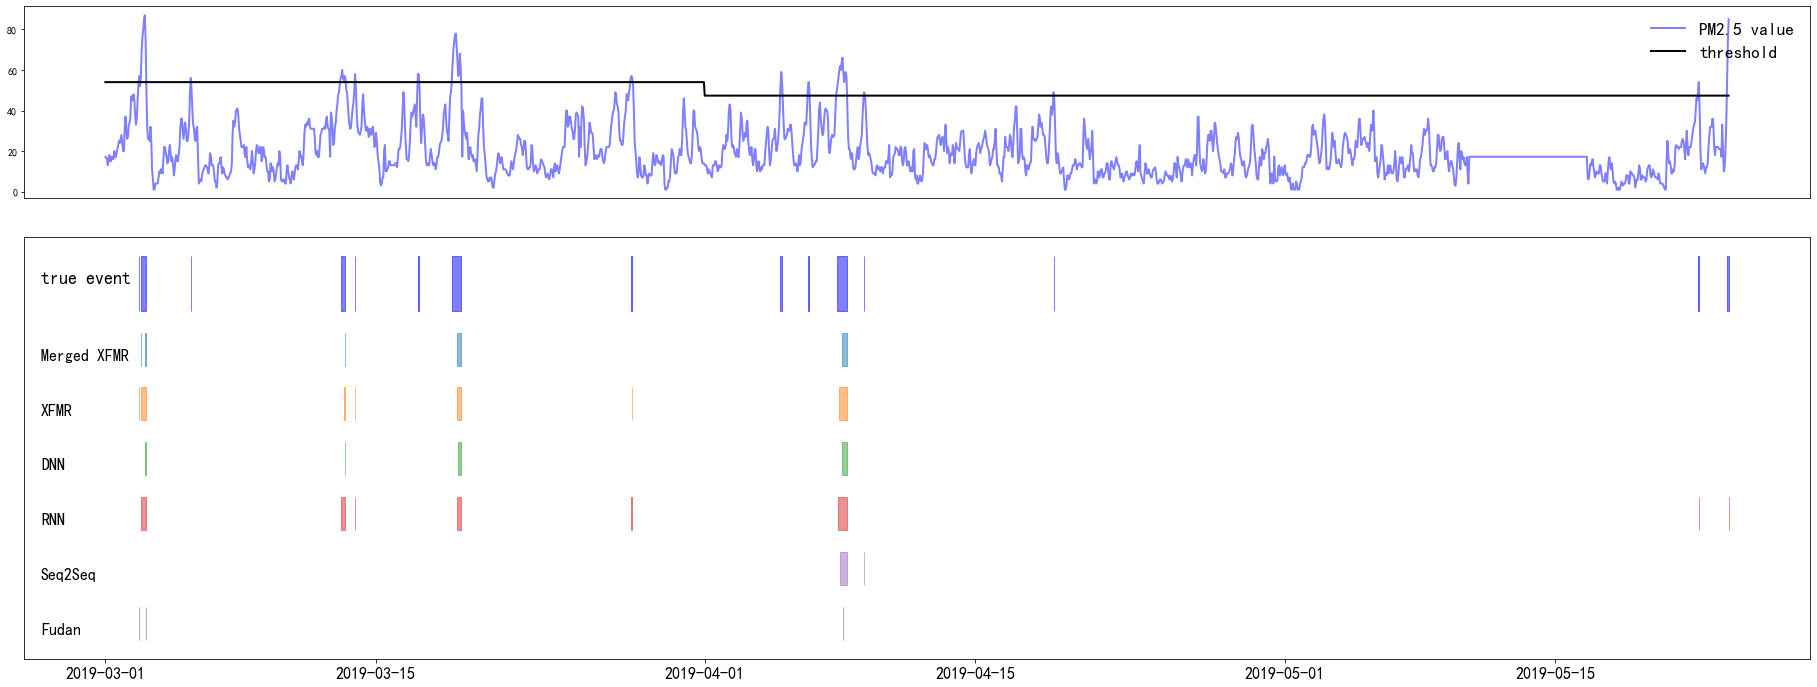

恆春


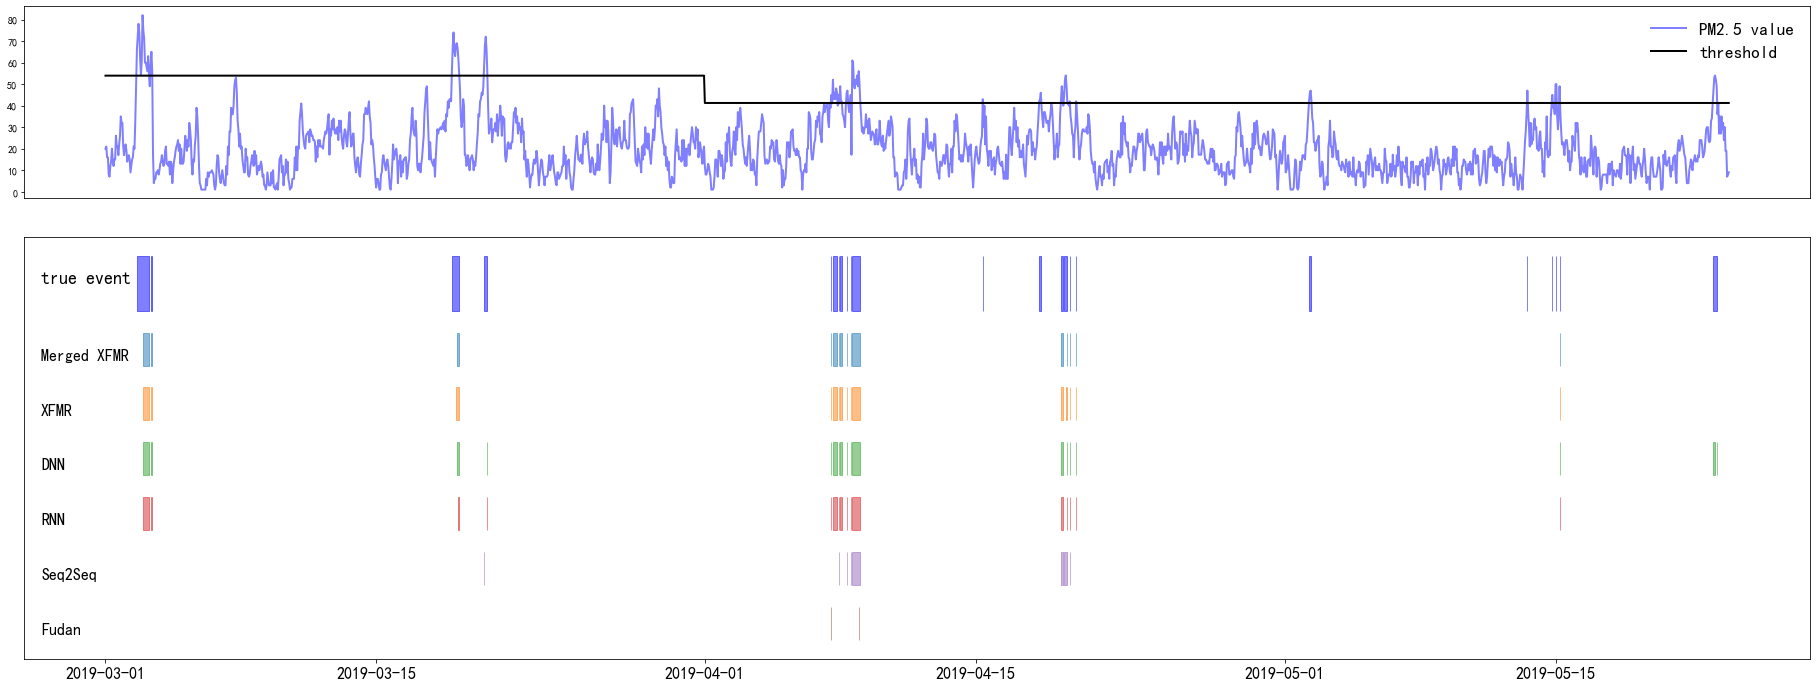

In [56]:
# For classification multiple site outputs
def multiplot(sitename, opt, no_dict):
    # -------------------------------
    # Load data
    # -------------------------------
    for key in no_dict:
        no = key['no']
        data = np.load(f"{opt.rst_dir}/{no}/{sitename}.npy")[:,:,0]
        data = data[:, -1]
        key['data'] = data
    true   = np.load(f"{opt.origin_valid_dir}/{sitename}.npy")
    thres  = np.load(f"{opt.thres_valid_dir}/{sitename}.npy") 
    date   = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    mask   = get_mask(opt, true, thres)
#     print("before: ", pred.shape, true.shape, thres.shape, date.shape, mask.shape)
    total_size = true.shape[0]
    # -------------------------------
    # Filter data
    # -------------------------------
    # Here we only consider PM2.5 feature
    true  = true [:, 7]
    thres = thres[:, 7]
    mask  = mask [:, 0]
    # -------------------------------
    # Shift data
    # -------------------------------
    ## shift [-1, -2, ...]
    # here only consider the last 1, that is, shift = -1
    min_size = total_size
    for key in no_dict:
        data = key['data']
        size = data.shape[0]
        min_size = min(min_size, size)
    for key in no_dict:
        data = key['data']
        key['data'] = data[-min_size:]
    
    true  = true [-min_size:]
    thres = thres[-min_size:]
    date  = date [-min_size:]
    mask  = mask [-min_size:]
    # -------------------------------
    # Zoom data
    # -------------------------------
    st = np.where(date == '2019/03/01 00:00')[0][0]
    ed = st + 24 * 28 * 3
#     st = 0
#     ed = -1
    true  = true [st:ed]
    thres = thres[st:ed]
    mask  = mask [st:ed]
    x     = date [st:ed]
    for key in no_dict:
        data = key['data']
        key['data'] = data[st:ed]
    # -------------------------------
    # Draw data
    # -------------------------------    
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(32,12), sharex=True)
#     fig.tight_layout()
    gs = axs[1].get_gridspec()
    for ax in axs[1:]:
        ax.remove()
    axb = fig.add_subplot(gs[1:], sharex=axs[0])
    
#     fig.suptitle(f"{sitename}", fontsize=18)
    
    axs[0].plot(x, true,  color='blue',  lw=2,  alpha=.5, label='PM2.5 value')
    axs[0].plot(x, thres, color='black',  lw=2,  alpha=1, label='threshold')
    axs[0].legend(loc='upper right', frameon=False, fontsize='xx-large')
#     axs[0].set_yscale('log')
    axs[0].get_xaxis().set_visible(False)
#     axs[0].tick_params(axis='both', which='major', labelsize=10)

#     axs[0].spines['bottom'].set_visible(False)
#     matplotlib.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': False,
#                             # Use the Computer modern font
#                             'mathtext.fontset': 'cm',
#                             })

    pos = np.arange(20) * -.5
    padding = -.2
    axb.fill_between(x, pos[0], pos[1], 
                    where=mask>=.5, 
                    color='blue', 
                    alpha=0.5, 
#                     transform=ax.get_xaxis_transform(),
                    label='true event'
                   )
    axb.text(x[0] - pd.Timedelta(hours=1) * 80, (pos[0]+pos[1])/2, 
                    'true event',fontsize=18)
    
    for i in range(len(no_dict)):
        axb.fill_between(x, pos[i+1]+padding, pos[i+2], 
                        where= np.logical_and(no_dict[i]['data']>=.5, mask>=.5),
                        color=colorname_list[i], 
                        alpha=0.5, 
                        label=f'{no_dict[i]["name"]}'
                       )
        axb.text(x[0] - pd.Timedelta(hours=1) * 80, (pos[i+1]+pos[i+2])/2+padding, 
                    f'{no_dict[i]["name"]}',fontsize=16)
    
#     axb.legend(loc='best', frameon=False, fontsize='xx-large')
    axb.get_yaxis().set_visible(False)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
#     plt.savefig(f'thesis_figures/all_year/{sitename}.png', dpi=300)
#     plt.savefig(f'thesis_figures/special_months/{sitename}.png')

no = 562
args = [f"--no={no}"]
opt = parse(args)
with open(f"{opt.cfg_dir}/{opt.no}.json", "r") as fp:
    opt = json.load(fp)
opt = Namespace(**opt)
same_seeds(opt.seed)
no_dict = [
    {"name": "Merged XFMR", "no": 562},
#     {"name": "Merged DNN", "no": 566},
#     {"name": "Merged RNN", "no": 570},
    {"name": "XFMR", "no": 491},
    {"name": "DNN", "no": 521},
    {"name": "RNN", "no": 526},
    {"name": "Seq2Seq", "no": 516},
    {"name": "Fudan", "no": 531},
]
colorname_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
                  "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan",
]

# for sitename in ['左營', '復興', '頭份', '竹山', '林口', '嘉義', '恆春', '臺東', '忠明']:
# for sitename in ['臺東','陽明','豐原','左營']:
# for sitename in ['小港', '關山', '復興']:
for sitename in SITENAMES:
    print(sitename)
    multiplot(sitename, opt, no_dict)
#     break

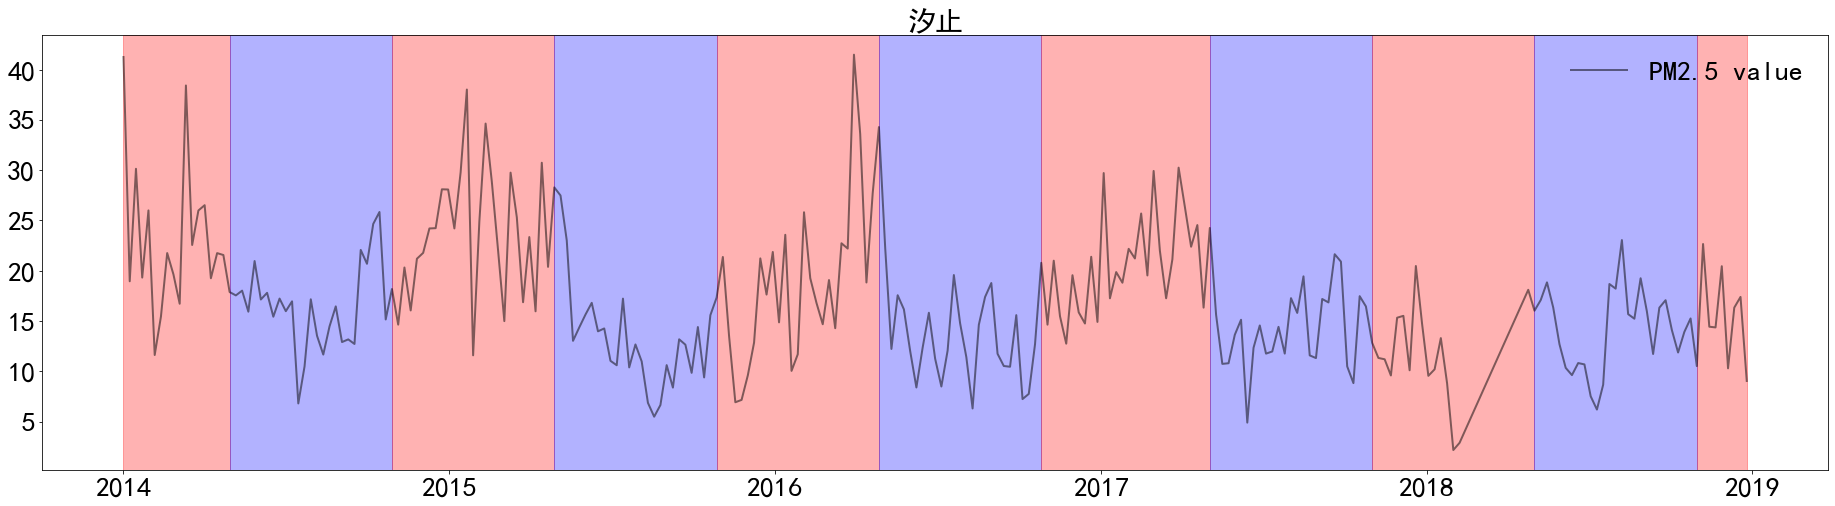

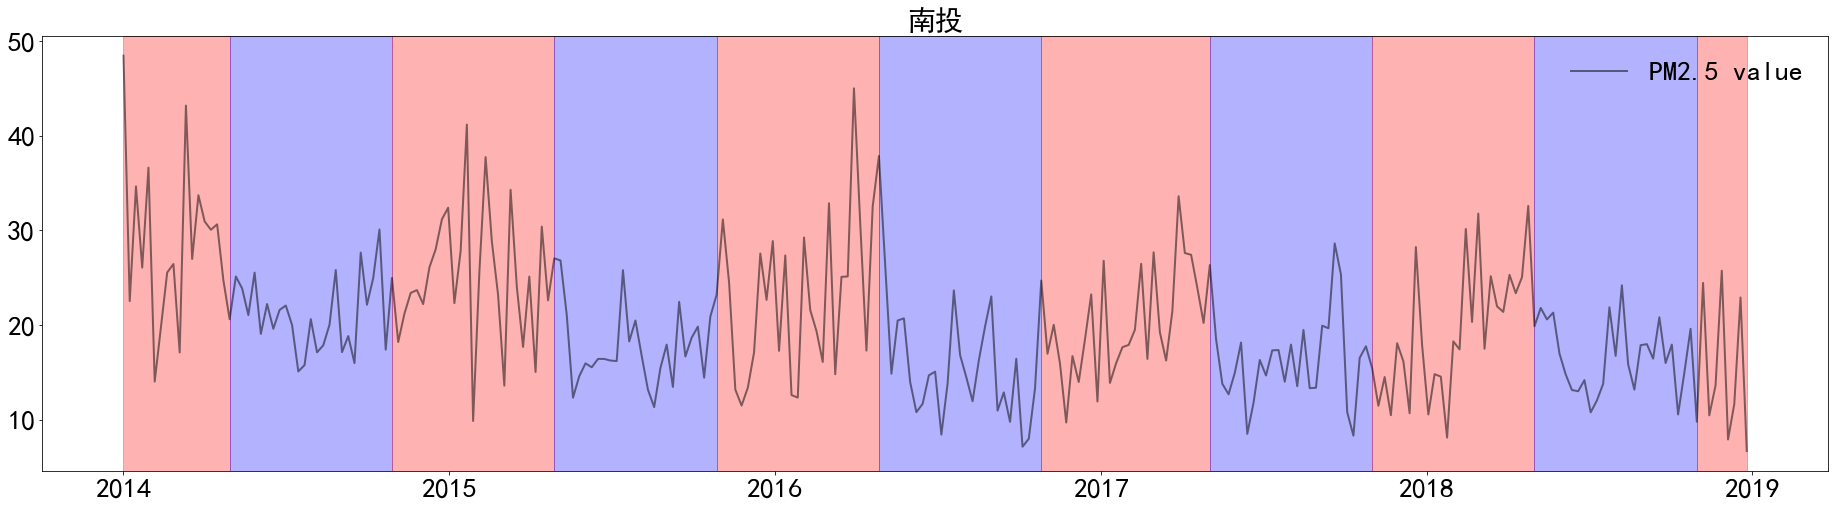

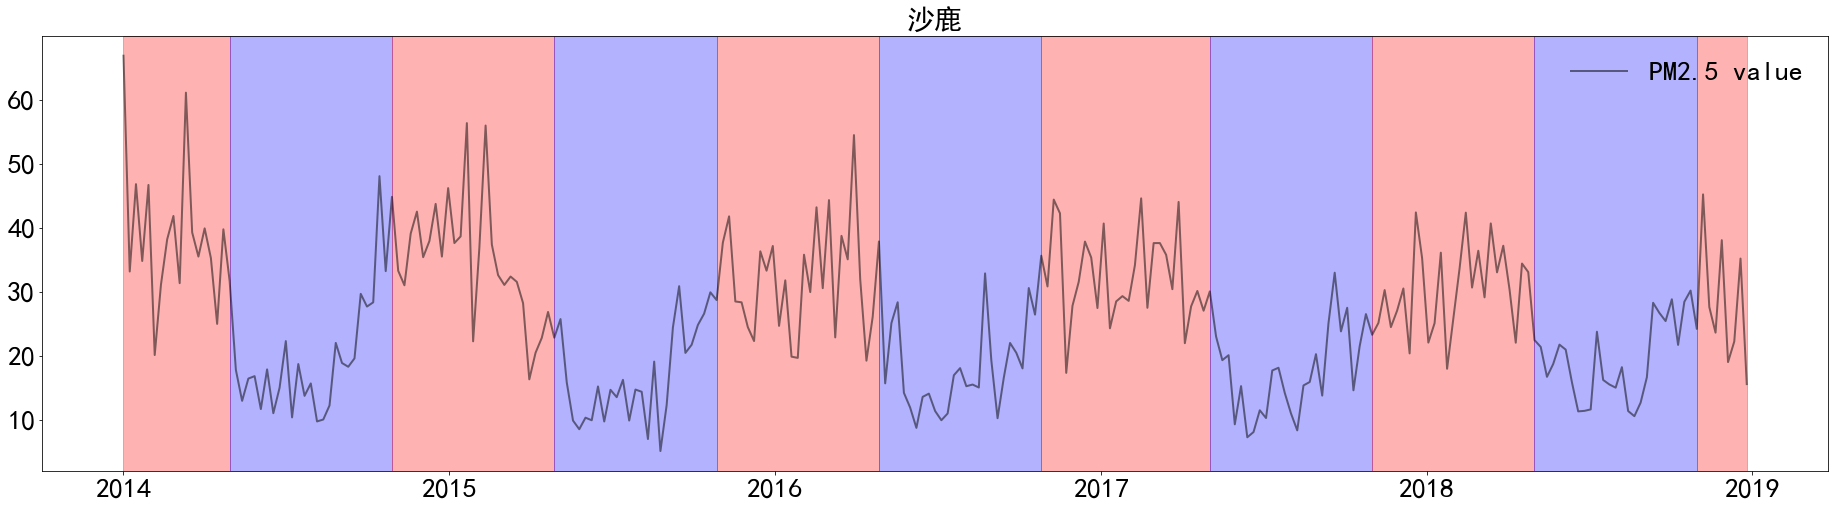

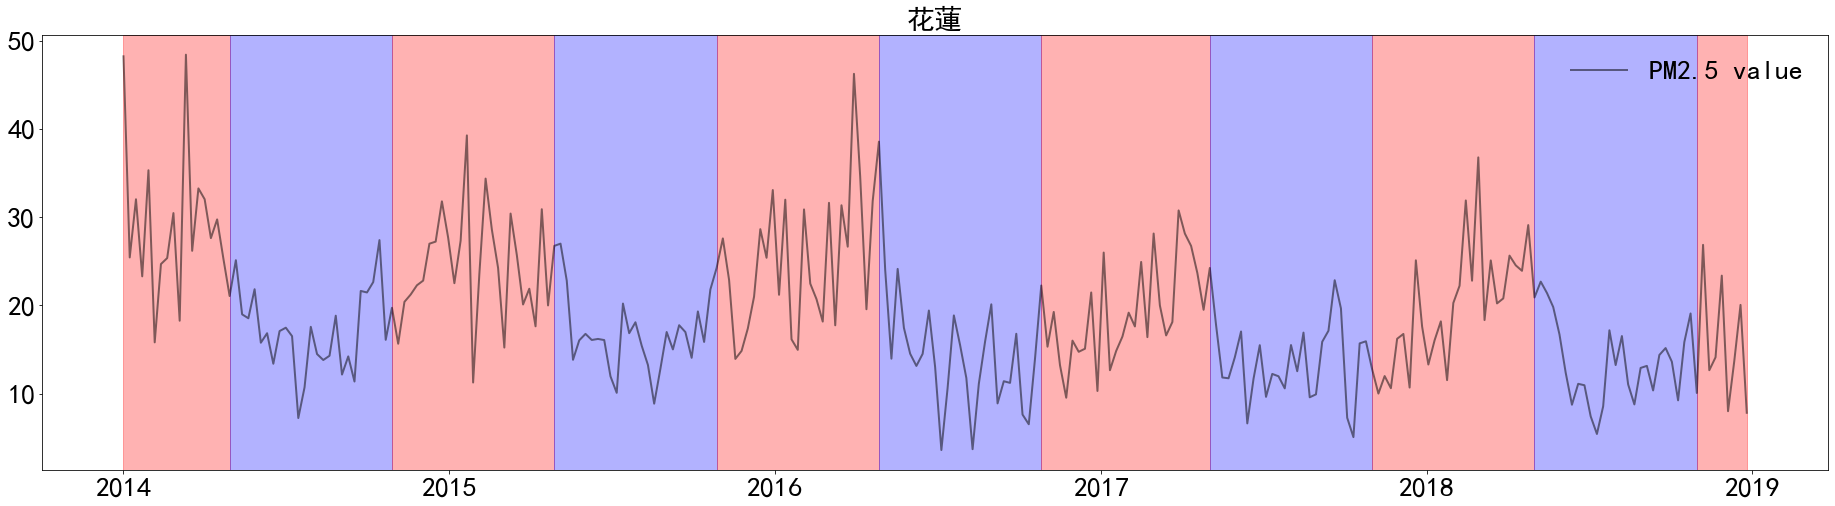

In [17]:
# For classification single model output
def plot(sitename, opt):
    no = opt.no
    # -------------------------------
    # Load data
    # -------------------------------
#     pred   = np.load(f"{opt.rst_dir}/{no}/{sitename}.npy")[:,:,0]
#     pred = pred[:, -1]
    read_path = opt.origin_all_dir
    true   = np.load(f"{read_path}/{sitename}.npy")
#     thres  = np.load(f"{opt.thres_all_dir}/{sitename}.npy") 
    date   = pd.date_range(start="2014-01-01 00:00",end="2019-01-01 23:00", freq='H')
#     mask   = get_mask(opt, true, thres)
#     print("before: ", pred.shape, true.shape, thres.shape, date.shape, mask.shape)
    true = true[:date.shape[0]]
    # -------------------------------
    # Filter data
    # -------------------------------
    # Here we only consider PM2.5 feature
    true  = true [:, 7]
    
    true = true.reshape(-1, 24).mean(-1)
    true = true.reshape(-1, 7).mean(-1)
    x = date[::24*7]
#     print(x.shape)
    # -------------------------------
    # Draw data
    # -------------------------------
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    
    ax.plot(x, true,  color='black',  lw=2,  alpha=.5, label='PM2.5 value')
#     ax.plot(x, thres, color='black', lw=2,  alpha=1, label='threshold')
    ax.legend(loc='upper right', frameon=False, fontsize=28)
    ax.axvspan(x[0], x[int(x.shape[0]/(12*5)*(4))], alpha=0.3, color='red')
    ax.axvspan(x[int(x.shape[0]/(12*5)* 4)], x[int(x.shape[0]/(12*5)*10)], alpha=0.3, color='blue')
    ax.axvspan(x[int(x.shape[0]/(12*5)*10)], x[int(x.shape[0]/(12*5)*16)], alpha=0.3, color='red')
    ax.axvspan(x[int(x.shape[0]/(12*5)*16)], x[int(x.shape[0]/(12*5)*22)], alpha=0.3, color='b')
    ax.axvspan(x[int(x.shape[0]/(12*5)*22)], x[int(x.shape[0]/(12*5)*28)], alpha=0.3, color='r')
    ax.axvspan(x[int(x.shape[0]/(12*5)*28)], x[int(x.shape[0]/(12*5)*34)], alpha=0.3, color='b')
    ax.axvspan(x[int(x.shape[0]/(12*5)*34)], x[int(x.shape[0]/(12*5)*40)], alpha=0.3, color='r')
    ax.axvspan(x[int(x.shape[0]/(12*5)*40)], x[int(x.shape[0]/(12*5)*46)], alpha=0.3, color='b')
    ax.axvspan(x[int(x.shape[0]/(12*5)*46)], x[int(x.shape[0]/(12*5)*52)], alpha=0.3, color='r')
    ax.axvspan(x[int(x.shape[0]/(12*5)*52)], x[int(x.shape[0]/(12*5)*58)], alpha=0.3, color='b')
    ax.axvspan(x[int(x.shape[0]/(12*5)*58)], x[int(x.shape[0])-1], alpha=0.3, color='red')
#     new_scale = matplotlib.scale.SymmetricalLogScale()
#     ax.set_yscale(new_scale)
    plt.title(f"{sitename}", fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.show()

no = 562
args = [f"--no={no}"]
opt = parse(args)
with open(f"{opt.cfg_dir}/{opt.no}.json", "r") as fp:
    opt = json.load(fp)
opt = Namespace(**opt)
same_seeds(opt.seed)
shift = -1 # -1 ... -target_size

# for sitename in SAMPLE_SITES:
# for sitename in ['左營', '復興', '頭份', '竹山', '林口', '嘉義', '恆春', '臺東', '忠明']:
# for sitename in ['臺東','陽明','豐原','左營']:
for sitename in ['汐止','南投','沙鹿','花蓮']:
# for sitename in ['小港', '關山', '復興']:
#     print(sitename)
    plot(sitename, opt)
#     break

汐止
norm kl=2.282e-01 loc= 16.69 scale= 12.26
gev kl=2.479e-02 shape= -0.16 loc= 10.83 scale= 7.8


<ipython-input-58-e5b743dd9c1b>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
<ipython-input-58-e5b743dd9c1b>:12: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


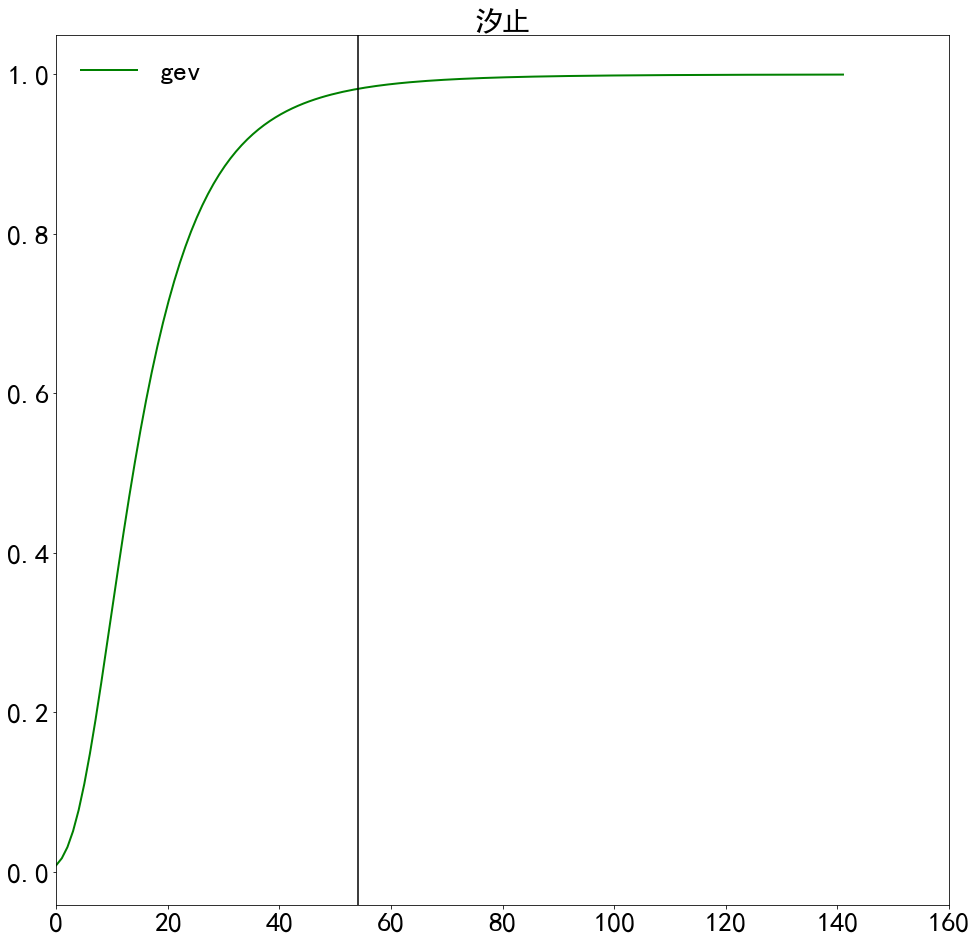

In [58]:
"""
    draw data distribution
"""

def gussion(x, position, width, height):
    return  height * math.sqrt(2*math.pi) * width * scipy.stats.norm.pdf(x, position, width)

def extreme(x, position, width, height, c=-0.1):
    return  height * math.sqrt(2*math.pi) * width * gev.pdf(x, c, position, width)

def kld(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def long_tailed():
    ## long tailed distribution test
    fig, ax = plt.subplots(1, 1, figsize=(16,4))
    shift = 5
    true_y = [np.sum(acc[i+shift:]) / (np.sum(acc[i:]) + 1e-8) for i in range(0, acc.shape[0]-2*shift)]
    norm_y = [np.sum(norm_dist[i+shift:]) / (np.sum(norm_dist[i:]) + 1e-8) for i in range(0, acc.shape[0]-2*shift)]
    gev_y  = [np.sum(gev_dist[i+shift:]) / (np.sum(gev_dist[i:]) + 1e-8) for i in range(0, acc.shape[0]-2*shift)]
    x = [i for i in range(0, acc.shape[0]-2*shift)]
    plt.plot(x, true_y, lw=2, label='true')
    plt.plot(x, norm_y, lw=2, label='norm')
    plt.plot(x, gev_y, lw=2, label='gev')
    plt.axhline(y=1, color='black', alpha=.5)
    plt.axhline(y=0, color='black', alpha=.5)
    plt.legend(loc='upper right', frameon=False, fontsize=20)
    plt.xlim(0, 160)
    plt.ylim(-0.05, 1.05)
    plt.title(f"{sitename}", fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.show()
#     break
        
    
origin_all_path = opt.origin_all_dir

sitenames = ['汐止','南投','沙鹿','花蓮']#'陽明','安南','復興','小港']

for idx, sitename in enumerate(sitenames):
# for idx, sitename in enumerate(SITENAMES):
    
    if opt.skip_site and sitename not in sample_sites:
        continue
    print(sitename)
    read_path = os.path.join(origin_all_path, f"{sitename}.npy")
    date = pd.date_range(start="2014-01-01 00:00",end="2019-12-31 23:00", freq='H')
    data = np.load(read_path)[:, 7].astype(np.int)
#     st_year = 2019
    st = np.where(date == f'2014/01/01 00:00')[0][0]
    ed = np.where(date == f'2018/12/31 23:00')[0][0]
    data = data[st: ed+1]
#     data = np.load(read_path)[:, 7]
#     delta_data = abs(data[1:] - data[:-1])
#     data = delta_data.astype(np.int)
    

    data[data<0] = 0
    ratio = 1
    max_bin = int(np.max(data)) // ratio + 1
#     print("max: ", np.max(x), "bins: ", max_bin) 
    
    bins = [i * ratio for i in range(max_bin)]
    hist, _ = np.histogram(data, bins=bins, density=True)
    
    # Prepare distribution
    x = np.linspace(0, max_bin-1, max_bin-1)
    
    gev_fit = gev.fit(data)
    gev_dist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_kl = kld(hist, gev_dist)
    
#     gumbel_r_fit = gumbel_r.fit(data)
#     gumbel_r_dist = gumbel_r.pdf(x, gumbel_r_fit[0], gumbel_r_fit[1])
#     gumbel_r_kl = kld(hist, gumbel_r_dist)
    
#     gompertz_fit = gompertz.fit(data)
#     gompertz_dist = gompertz.pdf(x, gompertz_fit[0], gompertz_fit[1], gompertz_fit[2])
#     gompertz_kl = kld(hist, gompertz_dist)
    
    norm_fit = norm.fit(data)
    norm_dist = norm.pdf(x, norm_fit[0], norm_fit[1])
    norm_kl = kld(hist, norm_dist)
    
    
    print(f'norm kl={norm_kl:.3e}'                                         ,'loc=',round(norm_fit[0],2), 'scale=',round(norm_fit[1],2))
#     print(f'gumbel_r kl={gumbel_r_kl:.3e}',                                    'loc=',round(gumbel_r_fit[0],2), 'scale=',round(gumbel_r_fit[1],2))
#     print(f'gompertz kl={gompertz_kl:.3e}', 'shape=',round(gompertz_fit[0],2), 'loc=',round(gompertz_fit[1],2), 'scale=',round(gompertz_fit[2],2))
    print(f'gev kl={gev_kl:.3e}',      'shape=',round(gev_fit[0],2),      'loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2))
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(16,16))
    ax.plot(x, norm_dist,    color='red', lw=2, alpha=1, label='norm')
#     ax.plot(x, gumbel_r_dist,    color='blue', lw=1, alpha=1, label='gumbel')
#     ax.plot(x, gompertz_dist,    color='purple', lw=1, alpha=1, label='gompertz')
    ax.plot(x, gev_dist,     color='green', lw=2, alpha=1, label='gev')
    ax.legend(loc='best', frameon=False, fontsize=28)
    ax.axvline(x=54, color='black', label='threshold')
    plt.xlim(0, 160)
#     plt.xlim(0, np.max(x)+1)
#     plt.ylim(0, .4)
    
    acc, bins, _ = ax.hist(data, 
            np.max(data),
            alpha=0.6,
            density=True,
            )
    
    plt.title(f"{sitename}", fontsize=28)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.show()
#     plt.clf()
    break
    
    ## draw long tailed chart
#     long_tailed()


In [3]:
"""
    analyze the ratio of dataset
"""
no = 0
args = [
    "--threshold=54",
    "--delta=10", 
#     "--use_threshold",
#     "--use_min_threshold",
#     "--use_delta", 
#     "--use_abs_delta",

]
opt = parse(args)

results = []
for sitename in SITENAMES:
#     print(sitename)
    train_dataset = get_dataset(opt=opt, sitename=sitename, isTrain=True)
    valid_dataset = get_dataset(opt=opt, sitename=sitename, isTrain=False)
    
    train_ratio = train_dataset.get_ratio()
    valid_ratio = valid_dataset.get_ratio()
    
    results.append({
        'sitename': sitename,
        'train ratio'     : f"{1-train_ratio:.3%}",
        'valid ratio'     : f"{1-valid_ratio:.3%}",
        'threshold'       : f"{opt.threshold}",
        'delta'           : f"{opt.delta}",
        "use_threshold"   : f"{opt.use_threshold}",
        'use_min_theshold': f"{opt.use_min_threshold}",
        'use_delta'       : f"{opt.use_delta}",
        'use_abs_delta'   : f"{opt.use_abs_delta}",

    })
df = pd.DataFrame(results)
df.to_csv(f"data_ratio.csv", index=False, encoding='utf_8_sig')



In [21]:
class Test(nn.Module):
    def __init__(self,):
        super().__init__()
#         self.dense = nn.Linear(16, 32)
#         self.out = nn.Linear(32, 64)
#         self.dummy = nn.Linear(64, 8)
        self.rnn = nn.GRU(3, 2, batch_first=True)
        self.leru = nn.ReLU()
    def forward(self, x):
        return self.out(self.dense(x))
model = Test()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

42


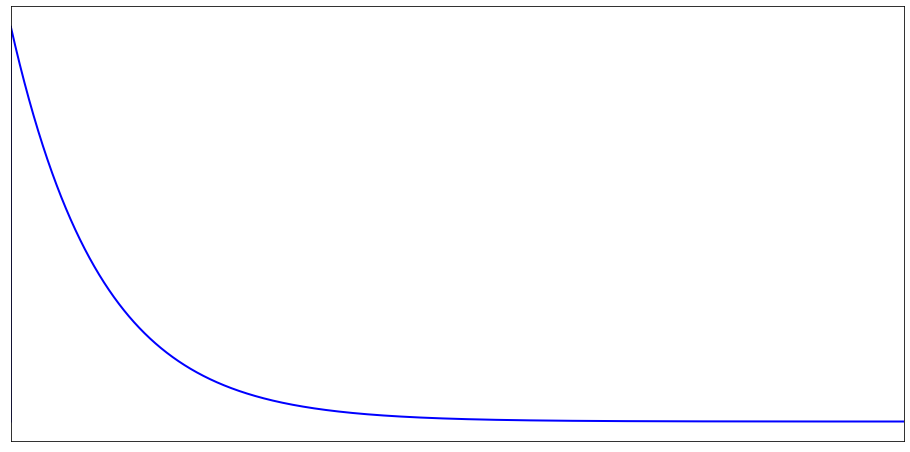

In [253]:
mu = 0
sigma = 1
shape = -0.001

colorname_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple",
                  "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan",]

# Prepare distribution
x = np.linspace(-1, 10, 10000)
gev_pdf = gev.pdf(x, shape, mu, sigma)
gev_cdf = gev.cdf(x, shape, mu, sigma)

pareto_pdf = genpareto.pdf(x, shape, mu, sigma)
pareto_cdf = genpareto.cdf(x, shape, mu, sigma)

gumbel_r_pdf = gumbel_r.pdf(x, mu, sigma)

norm_pdf = norm.pdf(x, mu, sigma)

# print(f'norm kl={norm_kl:.3e}'                                         ,'loc=',round(norm_fit[0],2), 'scale=',round(norm_fit[1],2))
#     print(f'gumbel_r kl={gumbel_r_kl:.3e}',                                    'loc=',round(gumbel_r_fit[0],2), 'scale=',round(gumbel_r_fit[1],2))
# print(f'gev kl={gev_kl:.3e}', 'shape=',round(gev_fit[0],2),      'loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2))

# Plot 
fig, ax = plt.subplots(1, 1, figsize=(16,8))
# ax.plot(x, norm_dist,    color='red', lw=5, alpha=1, label='norm')
# ax.plot(x, gev_cdf,     color='green', lw=5, alpha=1, label='gev')
ax.plot(x, pareto_pdf,     color='b', lw=2, alpha=1)
# ax.axhline(y=0, color='black', lw=2, alpha=1)
# ax.axhline(y=1, color='black', lw=2, alpha=1)
n = 7
# ax.fill_between(x, pareto_pdf, -.5, 
#                where=x>n,
#                interpolate=True,
#                color=colorname_list[0],
#                alpha=.6)
# ax.fill_between(x, pareto_pdf, -.5, 
#                where=x>n+2,
#                interpolate=True,
#                color=colorname_list[1],
#                alpha=.8)
# pos = np.argwhere(x>n)[0][0]
# ax.plot([-10, x[pos]], [pareto_cdf[pos], pareto_cdf[pos]], lw=4, alpha=1, color=colorname_list[0])
# ax.plot([x[pos], x[pos]], [0, pareto_cdf[pos]], lw=4, alpha=1, color=colorname_list[0])
# pos = np.argwhere(x>(n+2))[0][0]
# ax.plot([-10, x[pos]], [pareto_cdf[pos], pareto_cdf[pos]], lw=4, alpha=1, color=colorname_list[1])
# ax.plot([x[pos], x[pos]], [0, pareto_cdf[pos]], lw=4, alpha=1, color=colorname_list[1])

plt.xlim(0, 10)
# plt.ylim(-.5, 5)
# ax.legend(loc='best', frameon=False, fontsize=48)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)



plt.show()